In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
pd.options.display.max_rows = 999
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np
import networkx as nx
from  scipy.stats import spearmanr 

In [2]:
pd.set_option('display.max_colwidth', -1)


## Read table with RPKG (generated by parser_bbmap.py)

In [3]:
rpkg=pd.read_csv("TSV/RPKG.tsv",sep="\t")

## Read table with deepARG + plasflow + kaiju results (generated by parser_kaiju.py)

In [4]:
args=pd.read_table("TSV/deepARG_plasflow_kaiju.tsv",sep="\t")

In [5]:
rpkg.head()

ORF_ID  ERR594345  \
0  gene_756282|GeneMark.hmm|1215_nt|+|1342|2556|TARA_PSE_RAW  0.003365    
1  gene_4591261|GeneMark.hmm|1452_nt|-|2|1453|TARA_PSE_RAW    0.000000    
2  gene_3406871|GeneMark.hmm|783_nt|+|1951|2733|TARA_PSE_RAW  0.000000    
3  gene_6732935|GeneMark.hmm|792_nt|+|360|1151|TARA_PSE_RAW   0.000000    
4  gene_3501111|GeneMark.hmm|1065_nt|+|119|1183|TARA_PSE_RAW  0.000000    

   ERR599133  ERR594405  ERR599037  ERR594291  ERR599168  ERR599087  \
0  0.000000   0.000000   0.000284   0.0        0.0022     0.000000    
1  0.000748   0.000000   0.000000   0.0        0.0000     0.000000    
2  0.000412   0.000000   0.000000   0.0        0.0000     0.000499    
3  0.000000   0.000000   0.000000   0.0        0.0000     0.001338    
4  0.000585   0.010766   0.000000   0.0        0.0000     0.000000    

   ERR599024  ERR594412  ...  ERR598997  ERR599015  ERR594406  ERR599007  \
0  0.000501   0.005935   ...  0.003321   0.000000   0.0        0.001699    
1  0.000000   0.010127   ...  0.000000   0.000000   0.0        0.000000    
2  0.007779   0.000000   ...  0.000000   0.001131   0.0        0.000355    
3  0.000632   0.000000   ...  0.002792   0.000000   0.0        0.001270    
4  0.000000   0.000000   ...  0.000000   0.000000   0.0        0.000000    

   ERR599146  ERR599159  ERR594353  ERR599096  ERR594342  ERR594354  
0  0.000000   0.000136   0.0        0.000000   0.000292   0.000000   
1  0.002459   0.000462   0.0        0.000000   0.000498   0.000000   
2  0.000000   0.000255   0.0        0.000000   0.000000   0.000000   
3  0.001615   0.000000   0.0        0.001817   0.024539   0.003357   
4  0.000000   0.000000   0.0        0.000000   0.000000   0.000000   

[5 rows x 379 columns]

## Merge the tables

In [6]:
all_results=pd.merge(args,rpkg,on=["ORF_ID"])


In [7]:
all_results.head()

#ARG  query-start  query-end                                       read_id  \
0  PATA  78           452        gene_756282|GeneMark.hmm|1215_nt|+|1342|2556   
1  UPPP  20           185        gene_4591261|GeneMark.hmm|1452_nt|-|2|1453     
2  ERMC  10           239        gene_3406871|GeneMark.hmm|783_nt|+|1951|2733   
3  KSGA  11           262        gene_6732935|GeneMark.hmm|792_nt|+|360|1151    
4  CFR   7            349        gene_3501111|GeneMark.hmm|1065_nt|+|119|1183   

                   predicted_ARG-class  \
0  quinolone                             
1  bacitracin                            
2  macrolide-lincosamide-streptogramin   
3  kasugamycin                           
4  multidrug                             

                                                           best-hit  \
0  NP_417544.5|FEATURES|CARD|quinolone|patA                           
1  U2Q591|FEATURES|UNIPROT|bacitracin|uppP                            
2  YP_492693|FEATURES|ARDB|macrolide-lincosamide-streptogramin|ErmC   
3  YP_002847275|FEATURES|ARDB|kasugamycin|KsgA                        
4  A9KK15|FEATURES|UNIPROT|multidrug|cfr                              

   probability  identity  alignment-length  alignment-bitscore  ...  \
0  0.893879     33.8      382               192.6               ...   
1  0.999933     30.1      166               77.4                ...   
2  0.899664     30.2      258               65.1                ...   
3  0.989528     31.2      260               108.6               ...   
4  1.000000     31.2      356               161.8               ...   

   ERR598997  ERR599015 ERR594406 ERR599007 ERR599146 ERR599159  ERR594353  \
0  0.003321   0.000000   0.0       0.001699  0.000000  0.000136  0.0         
1  0.000000   0.000000   0.0       0.000000  0.002459  0.000462  0.0         
2  0.000000   0.001131   0.0       0.000355  0.000000  0.000255  0.0         
3  0.002792   0.000000   0.0       0.001270  0.001615  0.000000  0.0         
4  0.000000   0.000000   0.0       0.000000  0.000000  0.000000  0.0         

  ERR599096 ERR594342 ERR594354  
0  0.000000  0.000292  0.000000  
1  0.000000  0.000498  0.000000  
2  0.000000  0.000000  0.000000  
3  0.001817  0.024539  0.003357  
4  0.000000  0.000000  0.000000  

[5 rows x 410 columns]

## Read the table with the manual curation of ARGs and prepare a table "curation_yes" with ARGs that are not in any scenario and marked for quantification

In [8]:
curation=pd.read_csv("TSV/curation_ARGs.tsv",sep="\t")
curation["Quantification"]=curation["Quantification"].str.replace(" ","").str.replace("Yes","yes")
curation["Scenario"]=curation["Scenario"].str.replace(" ","")
curation.columns=["#ARG","Type","quantification","scenario"]
curation_yes=curation[curation["quantification"]=="yes"]

In [9]:
curation["quantification"].value_counts()

yes    313
no     281
Name: quantification, dtype: int64

In [10]:
curation["scenario"].value_counts()

v      187
iv     41 
i      34 
ii     10 
iii    9  
Name: scenario, dtype: int64

## Remove from all_results the scenario i, sequnces miss annotated that will not be used to any analysis

In [11]:
results_quantification=pd.merge(all_results,curation_yes,on="#ARG")

In [12]:
curation=curation[curation["scenario"]!="i"]
all_results=pd.merge(all_results,curation,on="#ARG")

## Select from all_results only ARGs marked for quantification, creating a new dataframe

In [13]:
results_quantification.head()

#ARG  query-start  query-end  \
0  BCR  11           370         
1  BCR  11           363         
2  BCR  26           365         
3  BCR  8            353         
4  BCR  23           352         

                                           read_id predicted_ARG-class  \
0  gene_3196191|GeneMark.hmm|1182_nt|+|3178|4359    multidrug            
1  gene_4124281|GeneMark.hmm|1215_nt|+|21074|22288  multidrug            
2  gene_2148178|GeneMark.hmm|1197_nt|+|29279|30475  multidrug            
3  gene_1187778|GeneMark.hmm|1221_nt|+|66870|68090  multidrug            
4  gene_1359064|GeneMark.hmm|1197_nt|+|53501|54697  multidrug            

                                   best-hit  probability  identity  \
0  ZP_03283366|FEATURES|ARDB|multidrug|Bcr   1.000000     30.6       
1  ZP_03283366|FEATURES|ARDB|multidrug|Bcr   0.948012     30.1       
2  ZP_03283366|FEATURES|ARDB|multidrug|Bcr   1.000000     30.9       
3  ZP_03837521|FEATURES|ARDB|multidrug|Bcr   1.000000     31.5       
4  YP_001177494|FEATURES|ARDB|multidrug|Bcr  1.000000     30.1       

   alignment-length  alignment-bitscore  ...  ERR599007  ERR599146 ERR599159  \
0  366               205.3               ...  0.0        0.0        0.000313   
1  366               153.7               ...  0.0        0.0        0.000000   
2  349               164.1               ...  0.0        0.0        0.000000   
3  356               171.8               ...  0.0        0.0        0.000314   
4  336               160.6               ...  0.0        0.0        0.000000   

  ERR594353 ERR599096 ERR594342  ERR594354     Type quantification scenario  
0  0.0       0.001247  0.0       0.000000   efflux   yes            NaN      
1  0.0       0.000000  0.0       0.000000   efflux   yes            NaN      
2  0.0       0.000000  0.0       0.000000   efflux   yes            NaN      
3  0.0       0.006264  0.0       0.004629   efflux   yes            NaN      
4  0.0       0.000000  0.0       0.000000   efflux   yes            NaN      

[5 rows x 413 columns]

In [14]:
#table with multiple ARGs (including scenarios ii-v) in the same contig
multiple_ARGS=all_results.groupby(["contig_id","plasmid"])["#ARG"].count()
multiple_ARGS=pd.DataFrame(multiple_ARGS)
multiple_ARGS=multiple_ARGS[multiple_ARGS["#ARG"]>1]

#formating a table with `multiple ARGs` in contig distribution
multiple_ARGS_distribution=pd.DataFrame(multiple_ARGS.groupby(["#ARG","plasmid"])["#ARG"].count())
multiple_ARGS_distribution.columns=["Number of contigs"]
multiple_ARGS_distribution.reset_index(inplace=True)
multiple_ARGS_distribution.columns=["Number of #ARGs","plasmid","Number of contigs"]
multiple_ARGS_distribution=multiple_ARGS_distribution.set_index("Number of #ARGs").pivot(columns="plasmid",values="Number of contigs").fillna("0").reset_index()
multiple_ARGS_distribution.index.name = None
multiple_ARGS_distribution.columns.names = [None]
multiple_ARGS_distribution.columns=["Number of ARGs","in chromosome","in plasmid"]
multiple_ARGS_distribution=multiple_ARGS_distribution.astype(int)

In [15]:
multiple_ARGS_distribution

Number of ARGs  in chromosome  in plasmid
0  2               3503           689       
1  3               365            37        
2  4               116            13        
3  5               35             2         
4  6               22             0         
5  7               10             0         
6  8               6              0         
7  9               2              0         
8  10              2              0         
9  11              2              0

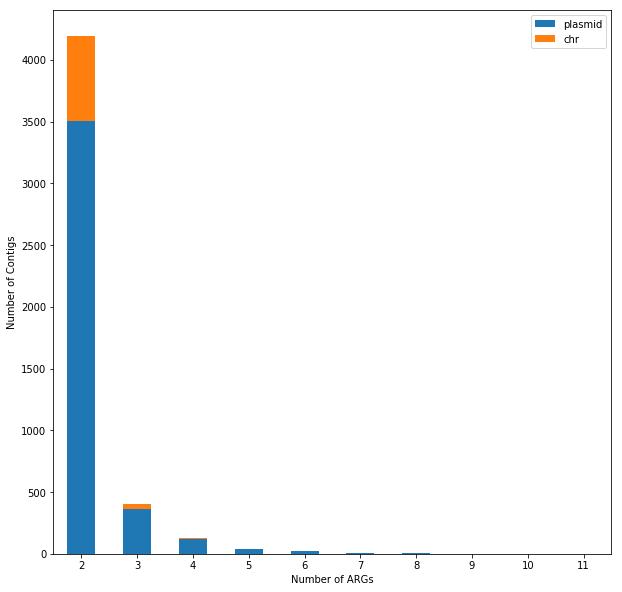

In [16]:
multiple_ARGS_distribution.set_index("Number of ARGs").plot(kind="bar",stacked=True,figsize=(10,10))
plt.legend(["plasmid","chr"])
plt.ylabel("Number of Contigs")
plt.xticks(rotation='horizontal')
plt.show()

In [17]:
len(all_results["taxon_name_kaiju"].dropna())

97244

In [18]:
len(all_results["taxon_name_kaiju"].dropna())/len(all_results)*100

98.02328511667758

In [19]:
#all_results[all_results["class"]=="Alphaproteobacteria"]

In [20]:
#all_results.groupby(["superkingdom"]).count()

In [21]:
all_results[all_results["superkingdom"]=="Viruses"]["taxon_name_kaiju"].value_counts()

unclassified Prymnesiovirus                   21
Chrysochromulina ericina virus                19
uncultured Mediterranean phage                9 
Cafeteria roenbergensis virus BV-PW1          8 
Megaviridae environmental sample              8 
Chlorovirus                                   4 
Vibrio phage pTD1                             4 
Mimivirus LCMiAC01                            4 
Oryctes rhinoceros nudivirus                  4 
Bacillus phage PBC2                           4 
Pacmanvirus A23                               3 
Bacillus phage Moonbeam                       3 
Lymphocystis disease virus - isolate China    3 
Whispovirus                                   2 
Klosneuvirus KNV1                             2 
Pseudomonas phage 201phi2-1                   2 
Salmonella phage SPAsTU                       2 
Catovirus CTV1                                1 
Asteriusvirus                                 1 
Vibrio phage 1.121.O._10N.286.46.C4           1 
Ranavirus           

In [22]:
set(all_results[all_results["superkingdom"]=="Viruses"]["scenario"])

{'v'}

In [23]:
# generate a list with contigs (ids) and how many ARGs found
full_Table_multiARGS=all_results[all_results["contig_id"].isin(list(multiple_ARGS.reset_index()["contig_id"]))]
#full_Table_multiARGS[["#ARG","predicted_ARG-class","contig_id","plasmid","taxon_name_kaiju"]].head()
multi_args_contigs=full_Table_multiARGS.groupby("contig_id")["#ARG"].count().sort_values(ascending=False)

In [24]:
multi_args_contigs

contig_id
TARA_ANW-k99_1343221     11
TARA_ANE-k99_4428305     11
TARA_ION-k99_13063158    10
TARA_PSW-k99_8257882     10
TARA_PON-k99_11447815    9 
                        .. 
TARA_PSE-k99_11048376    2 
TARA_PSE-k99_11025044    2 
TARA_PSE-k99_10958269    2 
TARA_PSE-k99_10938553    2 
TARA_ANE-k99_10006132    2 
Name: #ARG, Length: 4804, dtype: int64

In [25]:
all_results[all_results["contig_id"]=="TARA_ANE-k99_4428305"][["#ARG","taxon_name_kaiju"]]

#ARG      taxon_name_kaiju
26447  VANRI       Micavibrio sp. TMED2
26448  VANRI       Micavibrio sp. TMED2
28333  GOLS        Micavibrio sp. TMED2
30137  ILES1       Micavibrio sp. TMED2
31726  MTRA        Micavibrio sp. TMED2
65008  VANRA       Micavibrio sp. TMED2
67249  ADEL        Micavibrio sp. TMED2
67250  ADEL        Micavibrio sp. TMED2
86370  MEXL        Micavibrio sp. TMED2
89801  K678_12262  Micavibrio sp. TMED2
97519  RLMN2       Micavibrio sp. TMED2

In [26]:
all_results[all_results["contig_id"]=="TARA_ANE-k99_4428305"][["#ARG","predicted_ARG-class","taxon_name_kaiju_contig"]]

#ARG predicted_ARG-class taxon_name_kaiju_contig
26447  VANRI       glycopeptide        Micavibrio sp. TMED2  
26448  VANRI       glycopeptide        Micavibrio sp. TMED2  
28333  GOLS        multidrug           Micavibrio sp. TMED2  
30137  ILES1       mupirocin           Micavibrio sp. TMED2  
31726  MTRA        multidrug           Micavibrio sp. TMED2  
65008  VANRA       glycopeptide        Micavibrio sp. TMED2  
67249  ADEL        multidrug           Micavibrio sp. TMED2  
67250  ADEL        multidrug           Micavibrio sp. TMED2  
86370  MEXL        multidrug           Micavibrio sp. TMED2  
89801  K678_12262  beta_lactam         Micavibrio sp. TMED2  
97519  RLMN2       multidrug           Micavibrio sp. TMED2

In [27]:
all_results[all_results["contig_id"]=="TARA_ANW-k99_1343221"]["taxon_name_kaiju_contig"]

22766    Alphaproteobacteria bacterium HGW-Alphaproteobacteria-12
24653    Alphaproteobacteria bacterium HGW-Alphaproteobacteria-12
27336    Alphaproteobacteria bacterium HGW-Alphaproteobacteria-12
28927    Alphaproteobacteria bacterium HGW-Alphaproteobacteria-12
46319    Alphaproteobacteria bacterium HGW-Alphaproteobacteria-12
73372    Alphaproteobacteria bacterium HGW-Alphaproteobacteria-12
76477    Alphaproteobacteria bacterium HGW-Alphaproteobacteria-12
86485    Alphaproteobacteria bacterium HGW-Alphaproteobacteria-12
94930    Alphaproteobacteria bacterium HGW-Alphaproteobacteria-12
96668    Alphaproteobacteria bacterium HGW-Alphaproteobacteria-12
98746    Alphaproteobacteria bacterium HGW-Alphaproteobacteria-12
Name: taxon_name_kaiju_contig, dtype: object

In [28]:
all_results[all_results["contig_id"]=="TARA_ANW-k99_1343221"][["#ARG","predicted_ARG-class","taxon_name_kaiju"]]

#ARG                  predicted_ARG-class  \
22766  ARLR      multidrug                             
24653  VANRI     glycopeptide                          
27336  GOLS      multidrug                             
28927  ILES1     mupirocin                             
46319  VANRF     glycopeptide                          
73372  VANRO     glycopeptide                          
76477  TETB(60)  tetracycline                          
86485  MEXW      multidrug                             
94930  LMRD      macrolide-lincosamide-streptogramin   
96668  CEOB      multidrug                             
98746  ADEF      multidrug                             

                                               taxon_name_kaiju  
22766  Alphaproteobacteria bacterium HGW-Alphaproteobacteria-3   
24653  Alphaproteobacteria bacterium HGW-Alphaproteobacteria-12  
27336  Alphaproteobacteria bacterium HGW-Alphaproteobacteria-3   
28927  Alphaproteobacteria bacterium HGW-Alphaproteobacteria-3   
46319  Alphaproteobacteria                                       
73372  Alphaproteobacteria bacterium HGW-Alphaproteobacteria-3   
76477  Alphaproteobacteria bacterium HGW-Alphaproteobacteria-3   
86485  Parvibaculum lavamentivorans                              
94930  Alphaproteobacteria bacterium HGW-Alphaproteobacteria-3   
96668  uncultured Alphaproteobacteria bacterium                  
98746  Parvibaculum lavamentivorans

In [29]:
all_results[all_results["contig_id"]=="TARA_PSE-k99_4996023"][["#ARG","predicted_ARG-class","taxon_name_kaiju"]]

#ARG predicted_ARG-class   taxon_name_kaiju
23890  VANRI  glycopeptide        Tistrella mobilis
41811  BCR    multidrug           Tistrella mobilis
79157  VANXA  glycopeptide        Tistrella mobilis
81175  VANSO  glycopeptide        Tistrella mobilis
87587  MEXH   multidrug           Tistrella mobilis

In [30]:
all_results[all_results["contig_id"]=="TARA_PSE-k99_4996023"][["#ARG","predicted_ARG-class","taxon_name_kaiju_contig"]]

#ARG predicted_ARG-class taxon_name_kaiju_contig
23890  VANRI  glycopeptide        Tistrella mobilis     
41811  BCR    multidrug           Tistrella mobilis     
79157  VANXA  glycopeptide        Tistrella mobilis     
81175  VANSO  glycopeptide        Tistrella mobilis     
87587  MEXH   multidrug           Tistrella mobilis

In [31]:
contigs_all_args=pd.DataFrame(results_quantification[["contig_id","#ARG"]].groupby("contig_id")["#ARG"].apply(lambda x: (";".join(x))))
contigs_all_args.columns=["All ARGs in contig"]
contigs_all_args=pd.merge(results_quantification,contigs_all_args,on="contig_id")
count_arg=pd.DataFrame(results_quantification[["contig_id","#ARG"]].groupby("contig_id")["#ARG"].count())
count_arg.columns=["# ARGs in contig"]
contigs_all_args=pd.merge(contigs_all_args,count_arg,on="contig_id")
contigs_all_args["ORF_ID"]=contigs_all_args["ORF_ID"].str.split("|",expand=True)[0]
desc=pd.read_csv("TSV/desc.tsv",sep="\t")
desc.rename(columns={"ARG":"#ARG"},inplace=True)
contigs_all_args=pd.merge(contigs_all_args,desc,on="#ARG")
#contigs_all_args.to_csv("../resistome_app/data/deep_with_tax_levels.tsv",sep="\t",index=None)


In [271]:
contigs_all_args.head()

#ARG  query-start  query-end  \
0  BCR  11           370         
1  BCR  11           363         
2  BCR  26           365         
3  BCR  8            353         
4  BCR  23           352         

                                           read_id predicted_ARG-class  \
0  gene_3196191|GeneMark.hmm|1182_nt|+|3178|4359    multidrug            
1  gene_4124281|GeneMark.hmm|1215_nt|+|21074|22288  multidrug            
2  gene_2148178|GeneMark.hmm|1197_nt|+|29279|30475  multidrug            
3  gene_1187778|GeneMark.hmm|1221_nt|+|66870|68090  multidrug            
4  gene_1359064|GeneMark.hmm|1197_nt|+|53501|54697  multidrug            

                                   best-hit  probability  identity  \
0  ZP_03283366|FEATURES|ARDB|multidrug|Bcr   1.000000     30.6       
1  ZP_03283366|FEATURES|ARDB|multidrug|Bcr   0.948012     30.1       
2  ZP_03283366|FEATURES|ARDB|multidrug|Bcr   1.000000     30.9       
3  ZP_03837521|FEATURES|ARDB|multidrug|Bcr   1.000000     31.5       
4  YP_001177494|FEATURES|ARDB|multidrug|Bcr  1.000000     30.1       

   alignment-length  alignment-bitscore  ...  ERR594353  ERR599096 ERR594342  \
0  366               205.3               ...  0.0        0.001247   0.0        
1  366               153.7               ...  0.0        0.000000   0.0        
2  349               164.1               ...  0.0        0.000000   0.0        
3  356               171.8               ...  0.0        0.006264   0.0        
4  336               160.6               ...  0.0        0.000000   0.0        

  ERR594354     Type quantification  scenario All ARGs in contig  \
0  0.000000  efflux   yes            NaN       BCR                 
1  0.000000  efflux   yes            NaN       BCR                 
2  0.000000  efflux   yes            NaN       BCR                 
3  0.004629  efflux   yes            NaN       BCR;MEXH            
4  0.000000  efflux   yes            NaN       BCR                 

  # ARGs in contig                             description  
0  1                bicyclomycin/multidrug efflux system\n  
1  1                bicyclomycin/multidrug efflux system\n  
2  1                bicyclomycin/multidrug efflux system\n  
3  2                bicyclomycin/multidrug efflux system\n  
4  1                bicyclomycin/multidrug efflux system\n  

[5 rows x 416 columns]

In [263]:
argcount=pd.DataFrame(results_quantification.groupby(["#ARG"])["#ARG"].count().sort_values(ascending=False))
argcount.columns=["counts"]
argcount.reset_index(inplace=True)
argcount=pd.merge(argcount,results_quantification[["#ARG","predicted_ARG-class"]])
argcount.drop_duplicates(inplace=True)

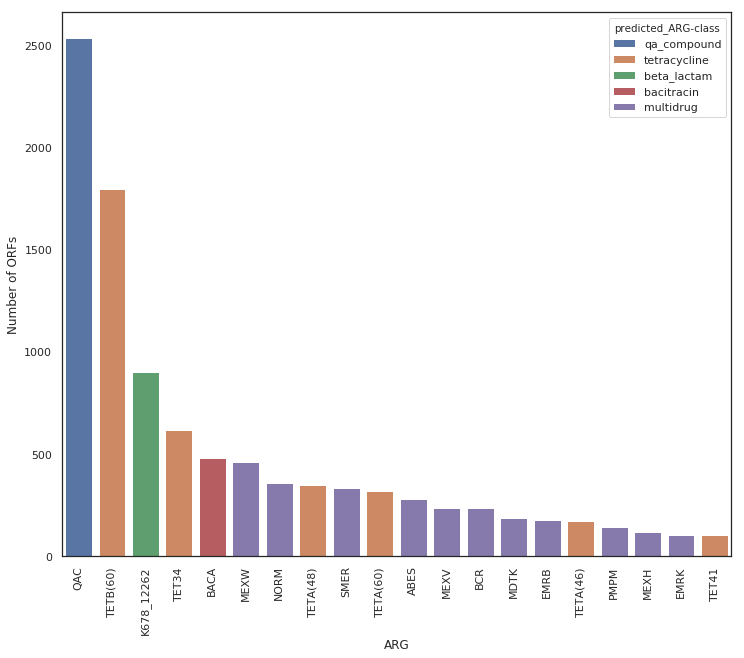

In [269]:
sns.set(style="white")
plt.figure(figsize=(12,10))

sns.barplot(data=argcount[0:20], y="counts",x="#ARG",hue="predicted_ARG-class",dodge=False,palette=["C0", "C1", "C2","C3","C4","C5","C6","C7","blue","yellow","red","k","green"])
plt.xticks(rotation=90)

plt.ylabel("Number of ORFs")
plt.xlabel("ARG")
plt.savefig("Figure_2_.png",format="png",resolution="300dpi")
plt.savefig("Figure_2_.svg",format="svg")
plt.savefig("Figure_2_.eps",format="eps")
plt.show()

In [33]:
# sum of RPKG of all ORFs for each ARG
ARGS_RPKG=results_quantification.groupby(["#ARG"])[[x for x in all_results.columns if "ERR" in x]].sum()
ARGS_RPKG=ARGS_RPKG.T
ARGS_RPKG.reset_index(inplace=True)
ARGS_RPKG["run_id"]=ARGS_RPKG["index"]
ARGS_RPKG.drop("index",axis=1,inplace=True)

# sum of RPKG of all ARGs for each class
class_RPKG=results_quantification.groupby(["predicted_ARG-class"])[[x for x in all_results.columns if "ERR" in x]].sum()
class_RPKG=class_RPKG.T
class_RPKG.reset_index(inplace=True)
class_RPKG["run_id"]=class_RPKG["index"]
class_RPKG.drop("index",axis=1,inplace=True)

In [34]:
ARGS_RPKG.head()

#ARG  AAC(2')-IB  AAC(3)-IA  AAC(3)-IC  AAC(3)-IIA  AAC(3)-IIB  AAC(3)-IIC  \
0     0.000000    0.0        0.003300   0.0         0.0         0.000000     
1     0.000000    0.0        0.013541   0.0         0.0         0.011959     
2     0.000000    0.0        0.000000   0.0         0.0         0.000000     
3     0.000669    0.0        0.004180   0.0         0.0         0.000456     
4     0.009093    0.0        0.000000   0.0         0.0         0.000000     

#ARG  AAC(3)-IIIA  AAC(3)-IIIB  AAC(3)-IV  AAC(3)-IXA  ...  WJ63_05905  \
0     0.0          0.000000     0.033254   0.000000    ...  0.005777     
1     0.0          0.000000     0.042889   0.004296    ...  0.000000     
2     0.0          0.015116     0.028709   0.000000    ...  0.000000     
3     0.0          0.000000     0.068754   0.000928    ...  0.000439     
4     0.0          0.000000     0.041236   0.000000    ...  0.035821     

#ARG  WM16_03815  WS68_16125  WS71_01720  WS86_20025  WT08_17490  XM57_27510  \
0     0.000000    0.114394    0.000000    0.000000    0.000000    0.013866     
1     0.000677    0.002032    0.009349    0.001705    0.000000    0.000000     
2     0.000000    0.523718    0.013767    0.000000    0.013767    0.000000     
3     0.000439    0.079927    0.000000    0.000000    0.000000    0.000000     
4     0.000000    0.011940    0.000000    0.000000    0.000000    0.000000     

#ARG      YFBG  YH67_08905     run_id  
0     0.000000  0.008997    ERR594345  
1     0.000913  0.000000    ERR599133  
2     0.000000  0.000000    ERR594405  
3     0.000000  0.055201    ERR599037  
4     0.002683  0.000000    ERR594291  

[5 rows x 314 columns]

In [35]:
class_RPKG.head()

predicted_ARG-class  aminoglycoside  bacitracin  beta_lactam  bleomycin  \
0                    0.113089        3.626901    6.774687     0.0         
1                    0.169852        1.956439    4.673196     0.0         
2                    7.724537        3.141729    16.546842    0.0         
3                    0.460290        0.936811    3.807054     0.0         
4                    0.203552        1.062067    4.048345     0.0         

predicted_ARG-class  chloramphenicol  fosfomycin  fosmidomycin  \
0                    3.684291         0.000000    0.001272       
1                    0.255936         0.033900    0.210209       
2                    25.880136        9.062190    0.559059       
3                    0.141872         0.027517    0.001995       
4                    0.472469         0.000000    0.117158       

predicted_ARG-class  macrolide-lincosamide-streptogramin   multidrug  \
0                    8.063829                             37.256312    
1                    0.836814                             15.729232    
2                    13.464074                            223.633203   
3                    0.808983                             6.523131     
4                    1.136423                             14.998656    

predicted_ARG-class   peptide  polymyxin  qa_compound  quinolone  rifampin  \
0                    0.027218  1.206318   3.406160     0.001021   0.003793   
1                    0.104756  0.114979   21.075838    0.013198   0.000703   
2                    0.280950  6.081802   13.048547    0.014410   0.000000   
3                    0.026986  1.087789   4.768618     0.001553   0.000870   
4                    0.048914  0.096175   16.720561    0.154478   0.031108   

predicted_ARG-class  sulfonamide  tetracycline  triclosan     run_id  
0                    0.238331     8.162053      0.492593   ERR594345  
1                    0.238539     27.631654     0.266815   ERR599133  
2                    0.772657     21.898546     21.144209  ERR594405  
3                    0.194552     15.902825     0.114893   ERR599037  
4                    0.209008     31.764691     0.422134   ERR594291

## reading metadata

In [36]:
# metadata from http://ocean-microbiome.embl.de/companion.html - http://ocean-microbiome.embl.de/data/OM.CompanionTables.xlsx
# meta -> tab W1 ; meta2 -> tab w8

meta=pd.read_csv("TSV/meta_runs.tsv",sep="\t")
meta.rename(columns={"value":"run_id"},inplace=True)
meta["Environmental_Feature"]=meta["Environmental Feature"].str.split(")",expand=True)[1].str.split("(",expand=True)[0]
meta["fraction"]=meta["Size fraction lower threshold [micrometre]"].astype(str)+" - "+ meta["Size fraction upper threshold [micrometre]"].astype(str)
meta.rename(columns={"Biogeographic biomes (Longhurst 2007)":"Biogeographic_biomes"},inplace=True)
meta["Ocean_sea_regions"]=meta["Ocean and sea regions (IHO General Sea Areas 1953) [MRGID registered at www.marineregions.com]"].str.split(")",expand=True)[1].str.split("[",expand=True)[0]
meta["Marine_provinces"]=meta["Marine provinces  (Longhurst 2007)"].str.split(")",expand=True)[1].str.split("[",expand=True)[0]
meta2=pd.read_csv("TSV/meta2.tsv",sep="\t")
meta2.rename(columns={"PANGAEA Sample ID":"PANGAEA sample identifier"},inplace=True)
meta=pd.merge(meta,meta2,on="PANGAEA sample identifier")


In [38]:
list_for_meta=["run_id","Marine_provinces","Environmental_Feature","Ocean_sea_regions",
                                                 "fraction","Biogeographic_biomes",'Mean_Lat*',
                                                 'Date/Time [yyyy-mm-ddThh:mm]','Latitude [degrees North]', 
                                                 'Longitude [degrees East]','Sampling depth [m]',
                                                   'Mean_Long*', 'Mean_Depth [m]*', 'Mean_Temperature [deg C]*',
                                                   'Mean_Salinity [PSU]*', 'Mean_Oxygen [umol/kg]*',
                                                   'Mean_Nitrates[umol/L]*', 'NO2 [umol/L]**', 'PO4 [umol/L]**',
                                                   'NO2NO3 [umol/L]**', 'SI [umol/L]**',
                                                   'AMODIS:PAR8d,Einsteins/m-2/d-1', 'Okubo-Weiss', 'Lyapunov_exp.',
                                                   'grad_SST_adv', u'retention', 'Mean Depth MLD Sigma [m]*',
                                                   'Mean Depth Max Fluo [m]*', 'Mean Depth Max N2 [m]*',
                                                   'Mean Depth Max O2 [m]*', 'Mean Depth Min O2 [m]*',
                                                   'Mean Depth Nitracline [m]*', 'miTAG.SILVA.Taxo.Richness',
                                                   'miTAG.SILVA.Phylo.Diversity', 'miTAG.SILVA.Chao', 'miTAG.SILVA.ace',
                                                   'miTAG.SILVA.Shannon', 'OG.Shannon', 'OG.Richness', 'OG.Evenness',
                                                   'FC - heterotrophs [cells/mL]', 'FC - autotrophs [cells/mL]',
                                                   'FC - bacteria [cells/mL]', 'FC - picoeukaryotes [cells/mL]',
                                                   'minimum generation time [h]']

In [39]:
class_RPKG=pd.merge(class_RPKG,meta[list_for_meta],on="run_id")

In [40]:
ARGS_RPKG=pd.merge(ARGS_RPKG,meta[list_for_meta],on="run_id")

In [41]:
ARGS_RPKG.head()

AAC(2')-IB  AAC(3)-IA  AAC(3)-IC  AAC(3)-IIA  AAC(3)-IIB  AAC(3)-IIC  \
0  0.000000    0.0        0.003300   0.0         0.0         0.000000     
1  0.000000    0.0        0.013541   0.0         0.0         0.011959     
2  0.000000    0.0        0.000000   0.0         0.0         0.000000     
3  0.000669    0.0        0.004180   0.0         0.0         0.000456     
4  0.009093    0.0        0.000000   0.0         0.0         0.000000     

   AAC(3)-IIIA  AAC(3)-IIIB  AAC(3)-IV  AAC(3)-IXA  ...  miTAG.SILVA.ace  \
0  0.0          0.000000     0.033254   0.000000    ... NaN                
1  0.0          0.000000     0.042889   0.004296    ...  4263.0            
2  0.0          0.015116     0.028709   0.000000    ... NaN                
3  0.0          0.000000     0.068754   0.000928    ...  4988.0            
4  0.0          0.000000     0.041236   0.000000    ... NaN                

   miTAG.SILVA.Shannon  OG.Shannon  OG.Richness  OG.Evenness  \
0 NaN                  NaN         NaN          NaN            
1  6.70                 7.17        17195.0      0.735         
2 NaN                  NaN         NaN          NaN            
3  5.49                 7.22        17308.0      0.739         
4 NaN                  NaN         NaN          NaN            

   FC - heterotrophs [cells/mL]  FC - autotrophs [cells/mL]  \
0  174925.0                      0.0                          
1  302791.0                      123447.0                     
2  598682.0                      48034.0                      
3  972004.0                      0.0                          
4  521106.0                      64001.0                      

   FC - bacteria [cells/mL]  FC - picoeukaryotes [cells/mL]  \
0  174925.0                  0.0                              
1  426238.0                  3263.0                           
2  646716.0                  669.0                            
3  972004.0                  0.0                              
4  585107.0                  6166.0                           

   minimum generation time [h]  
0 NaN                           
1  14.0                         
2 NaN                           
3  46.0                         
4 NaN                           

[5 rows x 358 columns]

In [42]:
class_RPKG.head()

aminoglycoside  bacitracin  beta_lactam  bleomycin  chloramphenicol  \
0  0.113089        3.626901    6.774687     0.0        3.684291          
1  0.169852        1.956439    4.673196     0.0        0.255936          
2  7.724537        3.141729    16.546842    0.0        25.880136         
3  0.460290        0.936811    3.807054     0.0        0.141872          
4  0.203552        1.062067    4.048345     0.0        0.472469          

   fosfomycin  fosmidomycin  macrolide-lincosamide-streptogramin   multidrug  \
0  0.000000    0.001272      8.063829                             37.256312    
1  0.033900    0.210209      0.836814                             15.729232    
2  9.062190    0.559059      13.464074                            223.633203   
3  0.027517    0.001995      0.808983                             6.523131     
4  0.000000    0.117158      1.136423                             14.998656    

    peptide  ...  miTAG.SILVA.ace  miTAG.SILVA.Shannon  OG.Shannon  \
0  0.027218  ... NaN              NaN                  NaN           
1  0.104756  ...  4263.0           6.70                 7.17         
2  0.280950  ... NaN              NaN                  NaN           
3  0.026986  ...  4988.0           5.49                 7.22         
4  0.048914  ... NaN              NaN                  NaN           

   OG.Richness  OG.Evenness  FC - heterotrophs [cells/mL]  \
0 NaN          NaN           174925.0                       
1  17195.0      0.735        302791.0                       
2 NaN          NaN           598682.0                       
3  17308.0      0.739        972004.0                       
4 NaN          NaN           521106.0                       

   FC - autotrophs [cells/mL] FC - bacteria [cells/mL]  \
0  0.0                         174925.0                  
1  123447.0                    426238.0                  
2  48034.0                     646716.0                  
3  0.0                         972004.0                  
4  64001.0                     585107.0                  

  FC - picoeukaryotes [cells/mL] minimum generation time [h]  
0  0.0                           NaN                          
1  3263.0                         14.0                        
2  669.0                         NaN                          
3  0.0                            46.0                        
4  6166.0                        NaN                          

[5 rows x 62 columns]

In [43]:
args


#ARG  query-start  query-end  \
0       PATA  78           452         
1       UPPP  20           185         
2       ERMC  10           239         
3       KSGA  11           262         
4       CFR   7            349         
...     ...  ..            ...         
116420  MSRB  8            126         
116421  MEXW  29           1028        
116422  KDPE  4            225         
116423  EMRA  49           325         
116424  CFR   72           341         

                                             read_id  \
0       gene_756282|GeneMark.hmm|1215_nt|+|1342|2556   
1       gene_4591261|GeneMark.hmm|1452_nt|-|2|1453     
2       gene_3406871|GeneMark.hmm|783_nt|+|1951|2733   
3       gene_6732935|GeneMark.hmm|792_nt|+|360|1151    
4       gene_3501111|GeneMark.hmm|1065_nt|+|119|1183   
...                                              ...   
116420  gene_2741234|GeneMark.hmm|375_nt|-|249|623     
116421  gene_1096690|GeneMark.hmm|3018_nt|+|3|3020     
116422  gene_3367092|GeneMark.hmm|669_nt|-|2440|3108   
116423  gene_1795476|GeneMark.hmm|1038_nt|+|119|1156   
116424  gene_1083466|GeneMark.hmm|858_nt|+|2|859       

                        predicted_ARG-class  \
0       quinolone                             
1       bacitracin                            
2       macrolide-lincosamide-streptogramin   
3       kasugamycin                           
4       multidrug                             
...           ...                             
116420  macrolide-lincosamide-streptogramin   
116421  multidrug                             
116422  aminoglycoside                        
116423  multidrug                             
116424  multidrug                             

                                                                  best-hit  \
0       NP_417544.5|FEATURES|CARD|quinolone|patA                             
1       U2Q591|FEATURES|UNIPROT|bacitracin|uppP                              
2       YP_492693|FEATURES|ARDB|macrolide-lincosamide-streptogramin|ErmC     
3       YP_002847275|FEATURES|ARDB|kasugamycin|KsgA                          
4       A9KK15|FEATURES|UNIPROT|multidrug|cfr                                
...                                       ...                                
116420  NP_416292.1|FEATURES|CARD|macrolide-lincosamide-streptogramin|msrB   
116421  AAG07763.1|FEATURES|CARD|multidrug|mexW                              
116422  NP_415222.1|FEATURES|CARD|aminoglycoside|kdpE                        
116423  BAA16547.1|FEATURES|CARD|multidrug|emra                              
116424  G4HC14|FEATURES|UNIPROT|multidrug|cfr                                

        probability  identity  alignment-length  alignment-bitscore  ...  \
0       0.893879     33.8      382               192.6               ...   
1       0.999933     30.1      166               77.4                ...   
2       0.899664     30.2      258               65.1                ...   
3       0.989528     31.2      260               108.6               ...   
4       1.000000     31.2      356               161.8               ...   
...          ...      ...      ...                 ...               ...   
116420  0.994966     47.9      119               115.5               ...   
116421  0.927156     30.1      1008              421.4               ...   
116422  0.887477     31.0      229               68.9                ...   
116423  0.979547     30.8      315               128.3               ...   
116424  0.999997     32.5      277               135.6               ...   

                            taxon_name_kaiju  superkingdom  \
0       Vibrio caribbeanicus                  Bacteria       
1       Flammeovirgaceae bacterium TMED290    Bacteria       
2       Gammaproteobacteria bacterium TMED34  Bacteria       
3       Candidatus Pelagibacter sp. FZCC0015  Bacteria       
4       SAR86 cluster bacterium               Bacteria       
...                         ...                    ...       
11642

In [44]:
# Removing samples from fraction virus and girus
ARGS_RPKG=ARGS_RPKG[(ARGS_RPKG["fraction"]!="< - 0.22")&(ARGS_RPKG["fraction"]!="0.1 - 0.22")]
class_RPKG=class_RPKG[(class_RPKG["fraction"]!="< - 0.22")&(class_RPKG["fraction"]!="0.1 - 0.22")]

In [45]:
ARGS_RPKG.to_csv("TSV/table_env.tsv",index=None,sep="\t")

In [46]:
class_RPKG.to_csv("TSV/table_env_class.tsv",index=None,sep="\t")

In [47]:
classes=[x for x in list(set(all_results["predicted_ARG-class"])) if x in class_RPKG.columns]


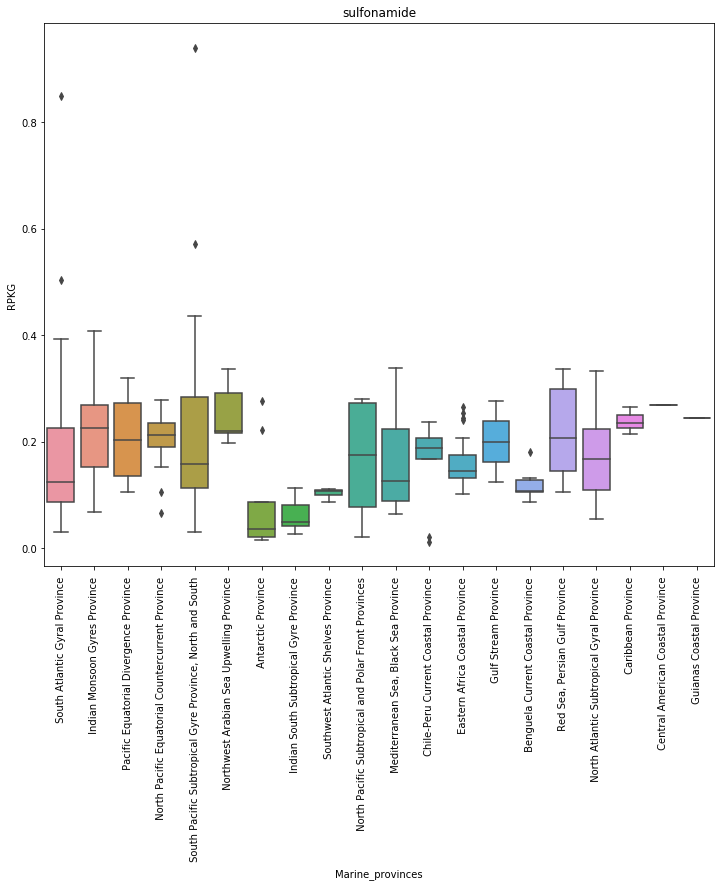

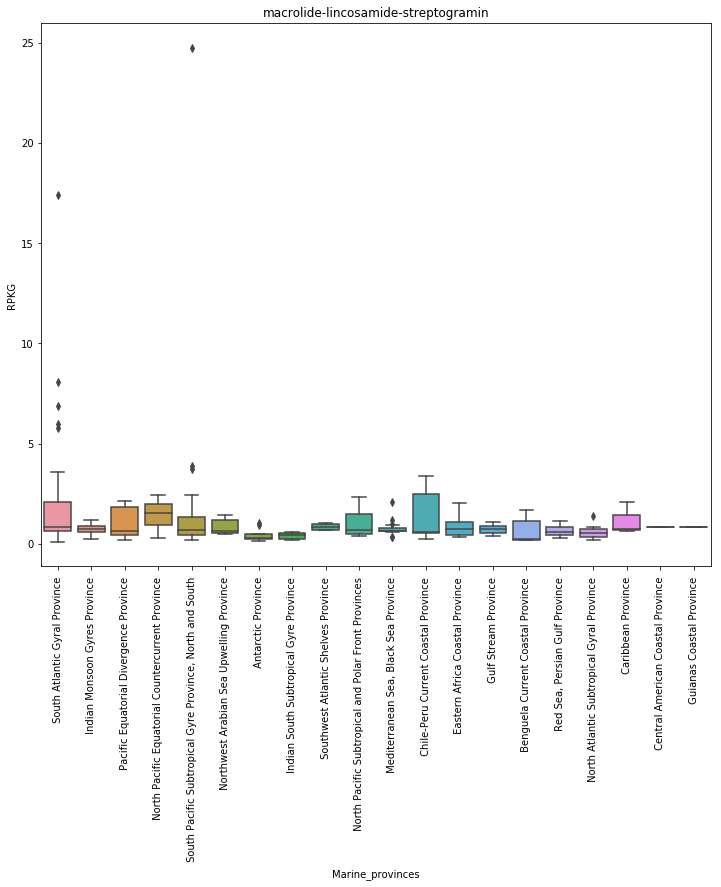

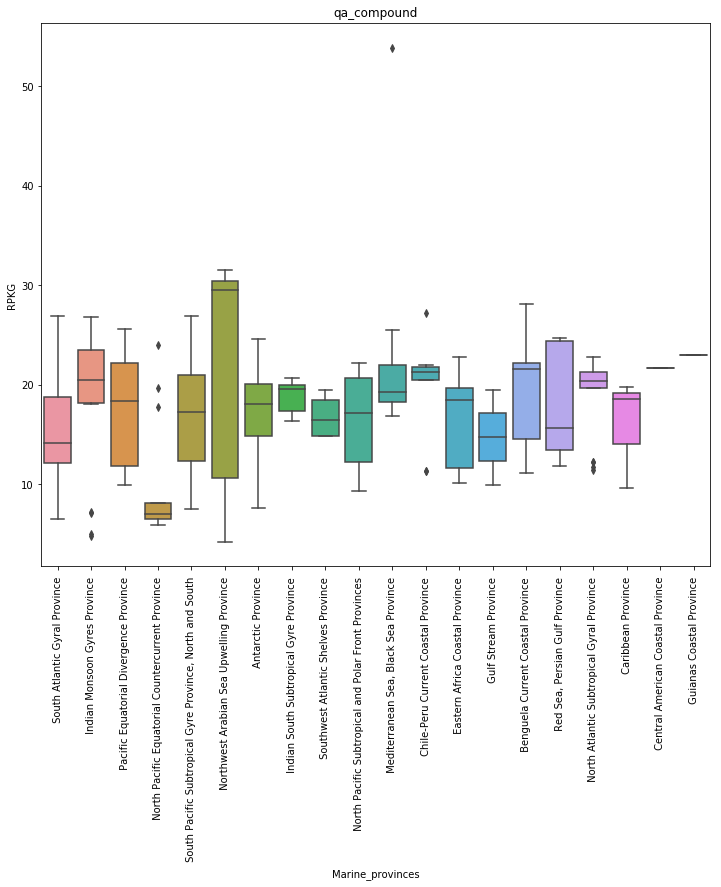

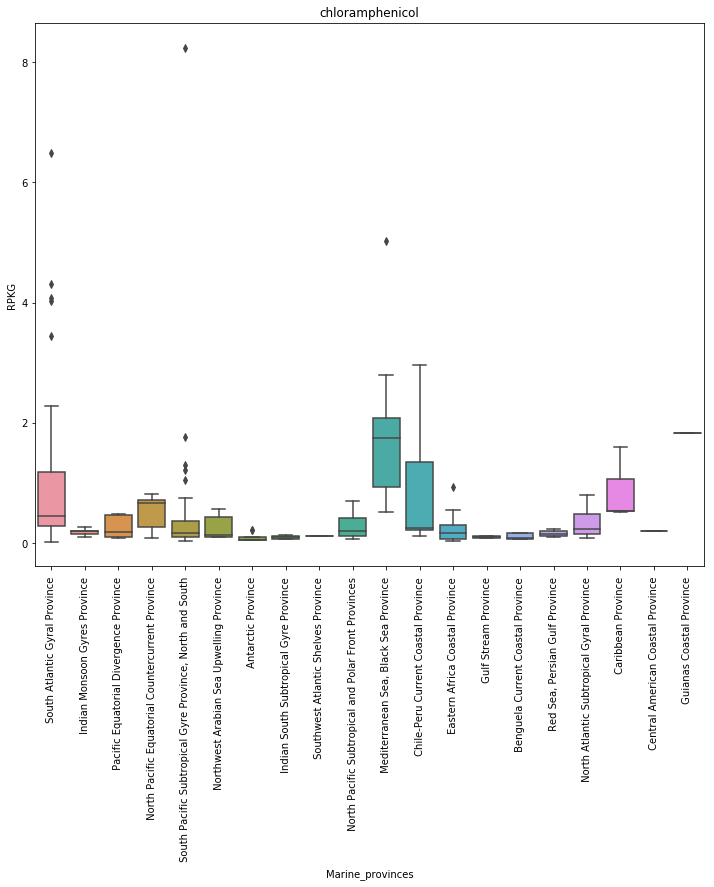

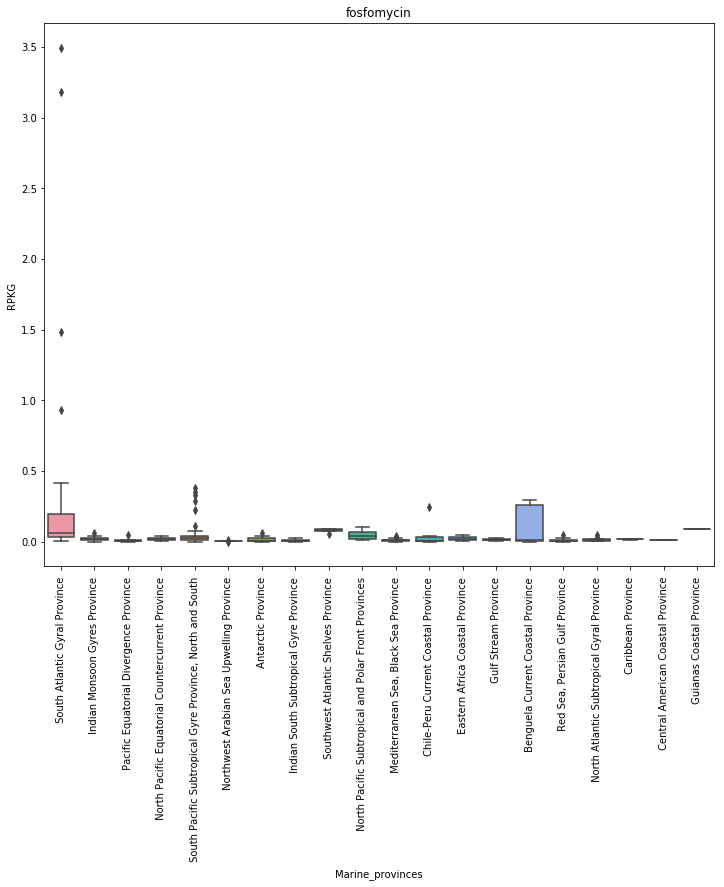

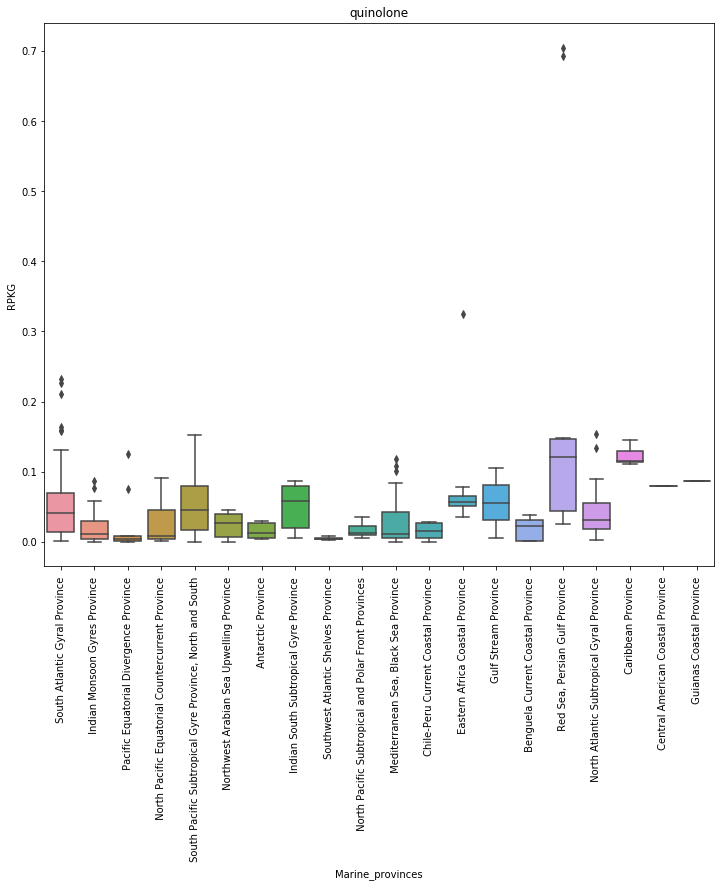

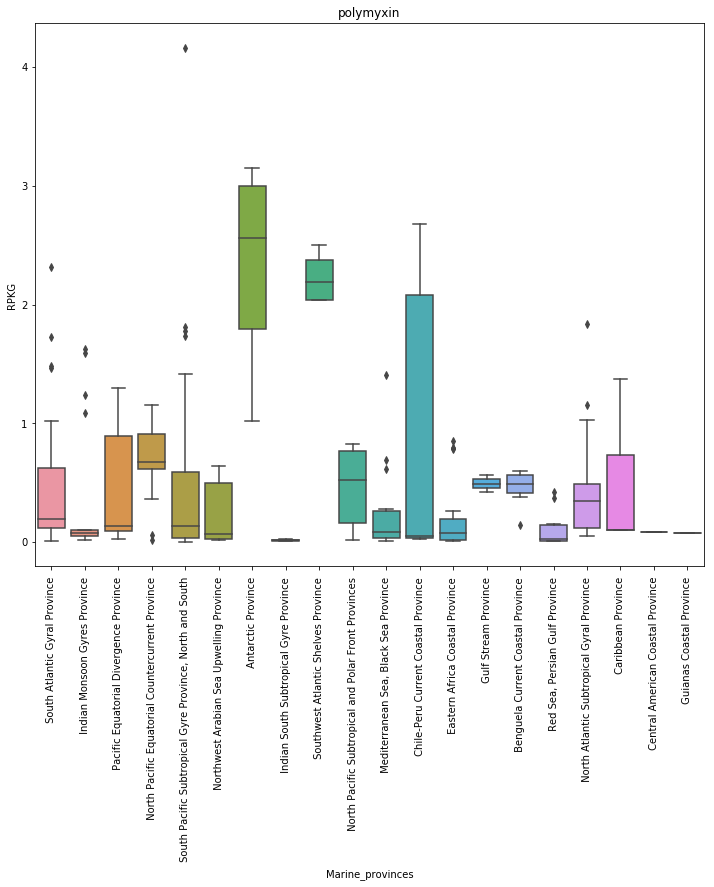

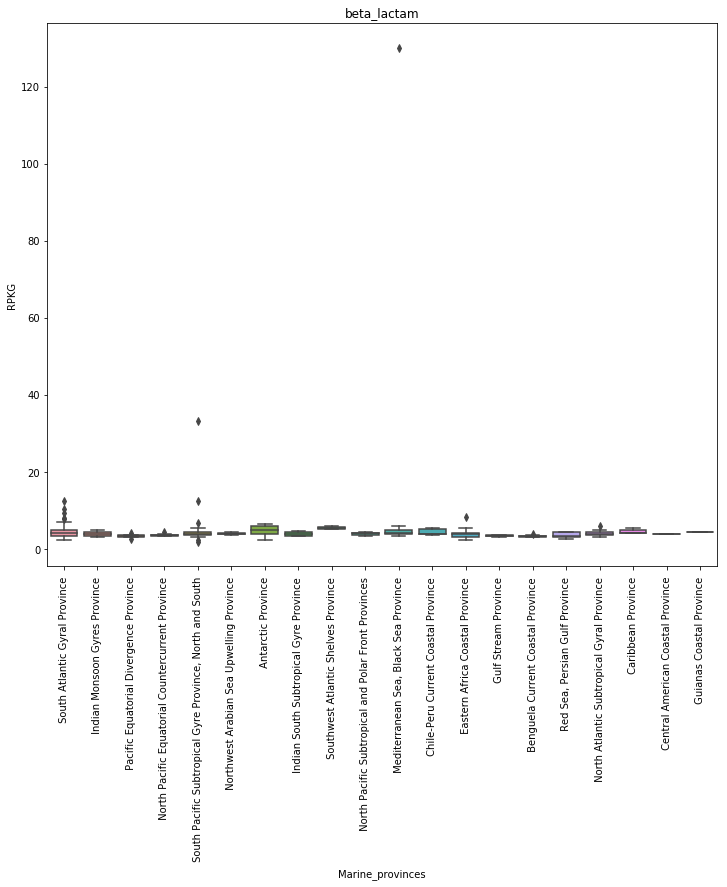

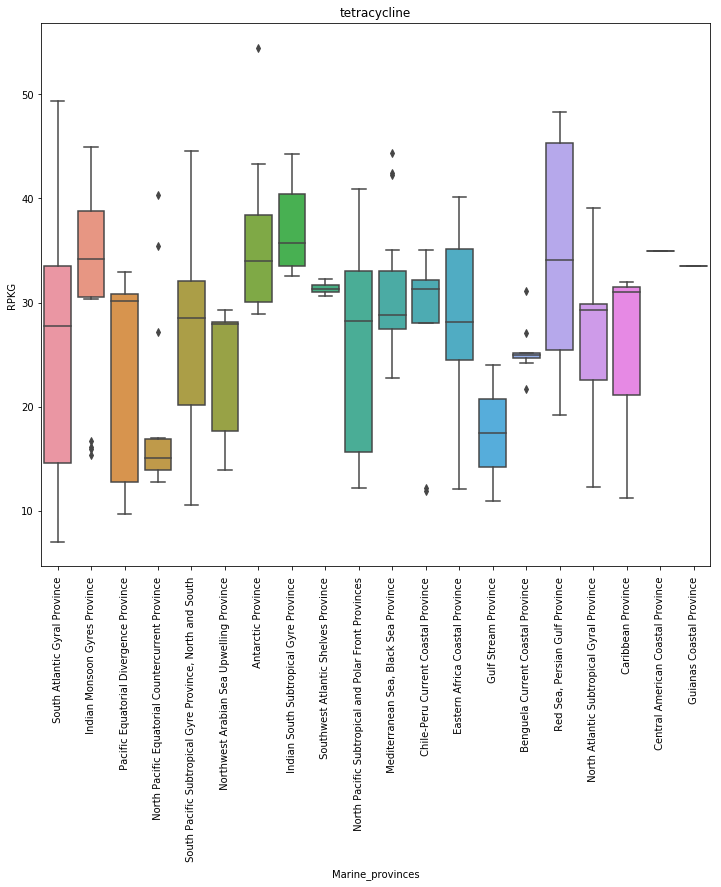

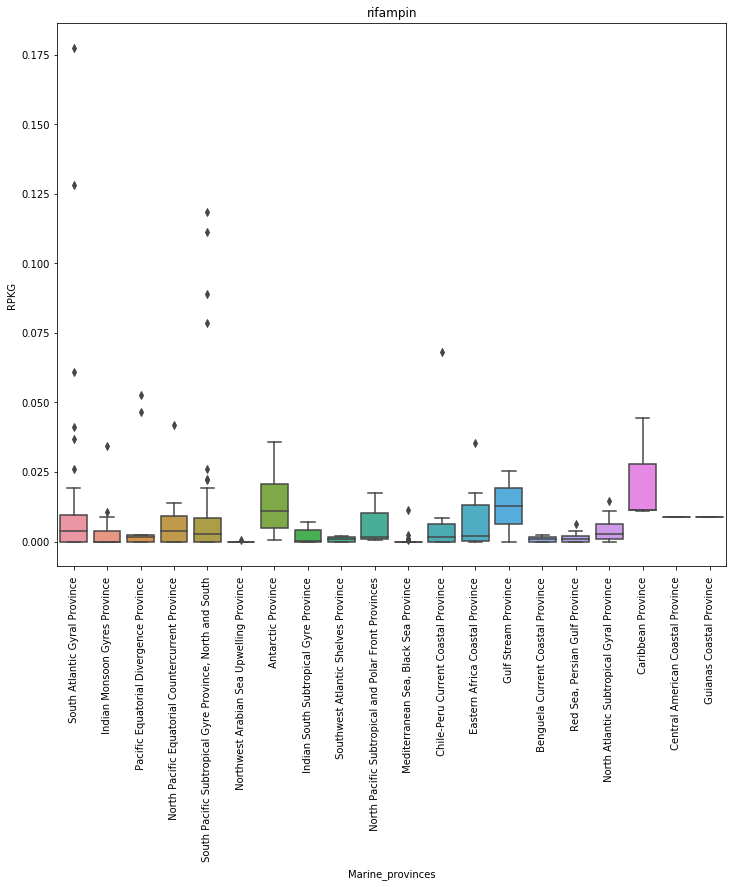

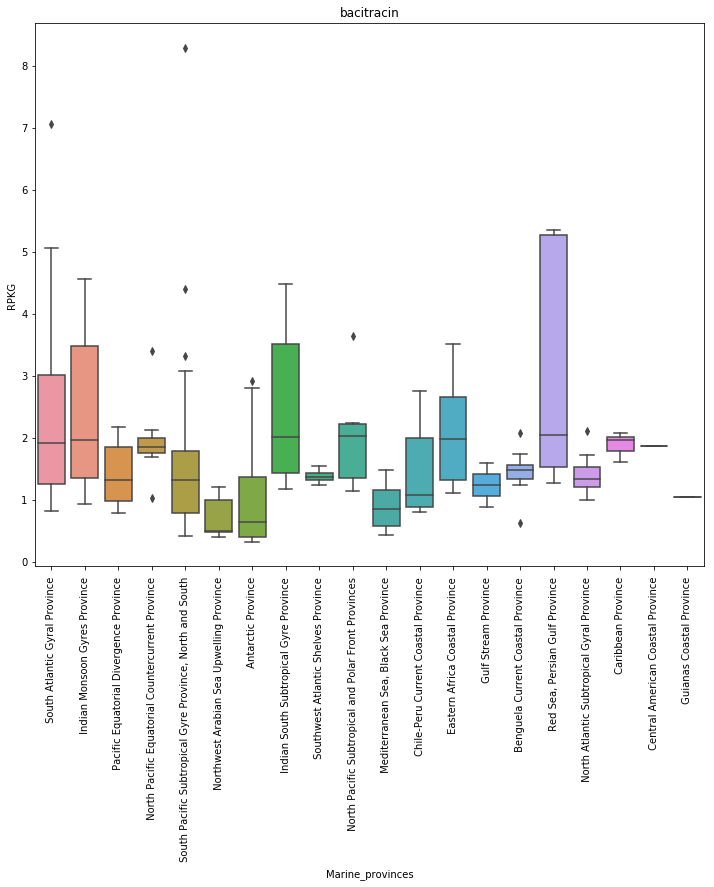

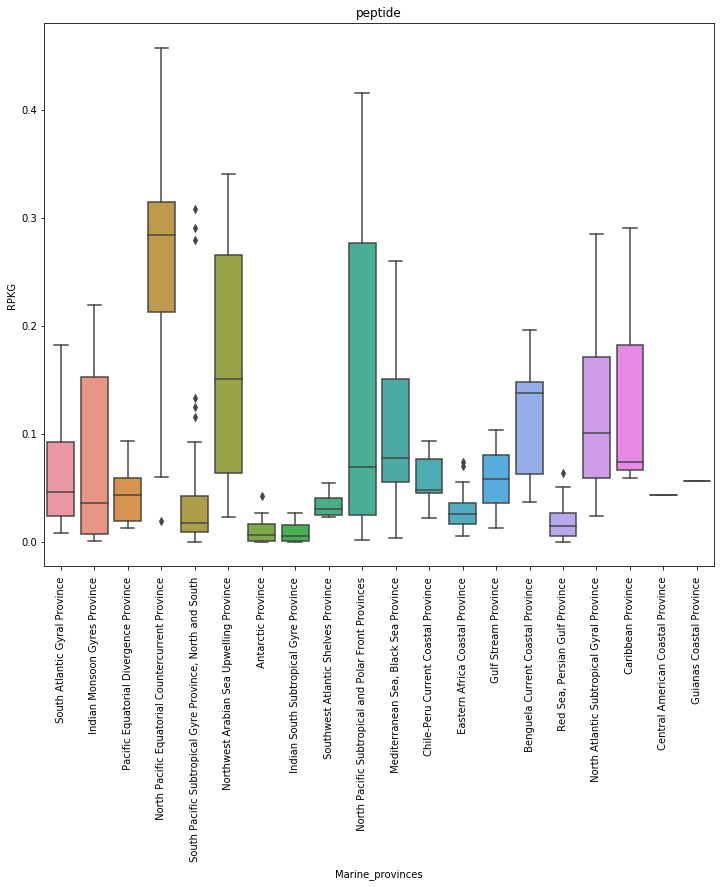

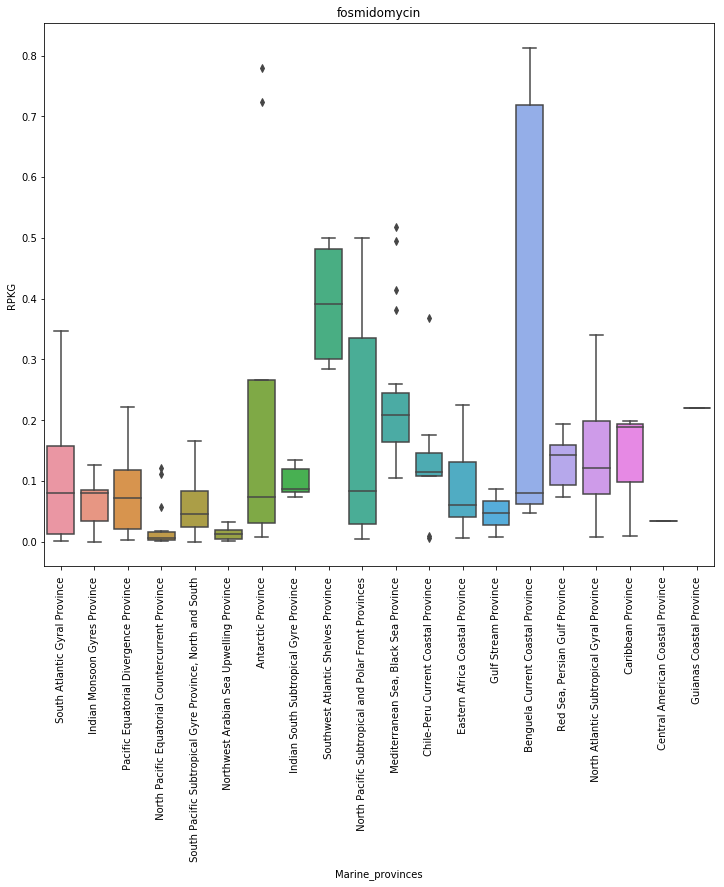

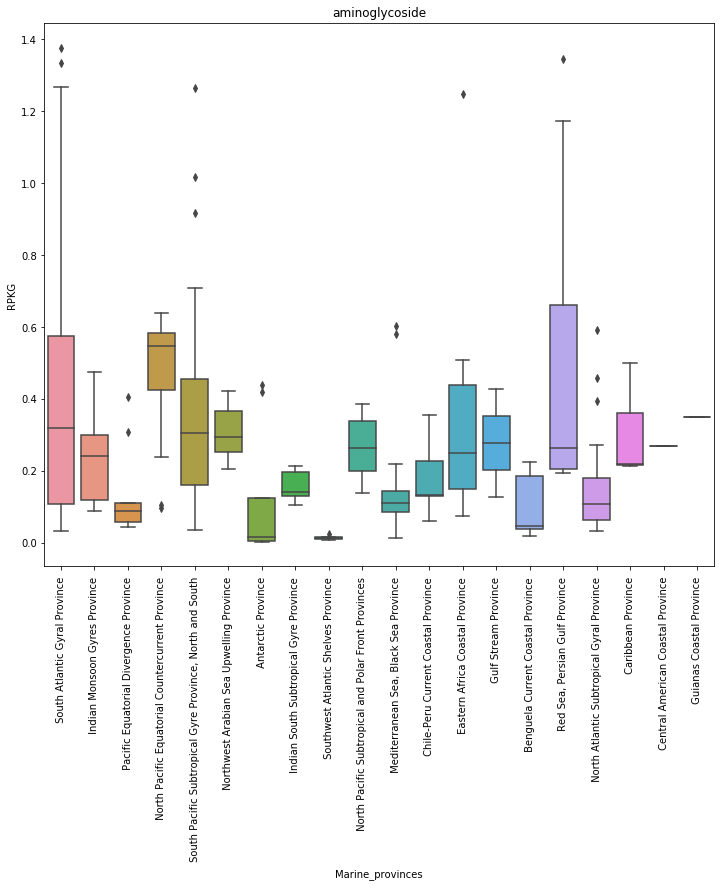

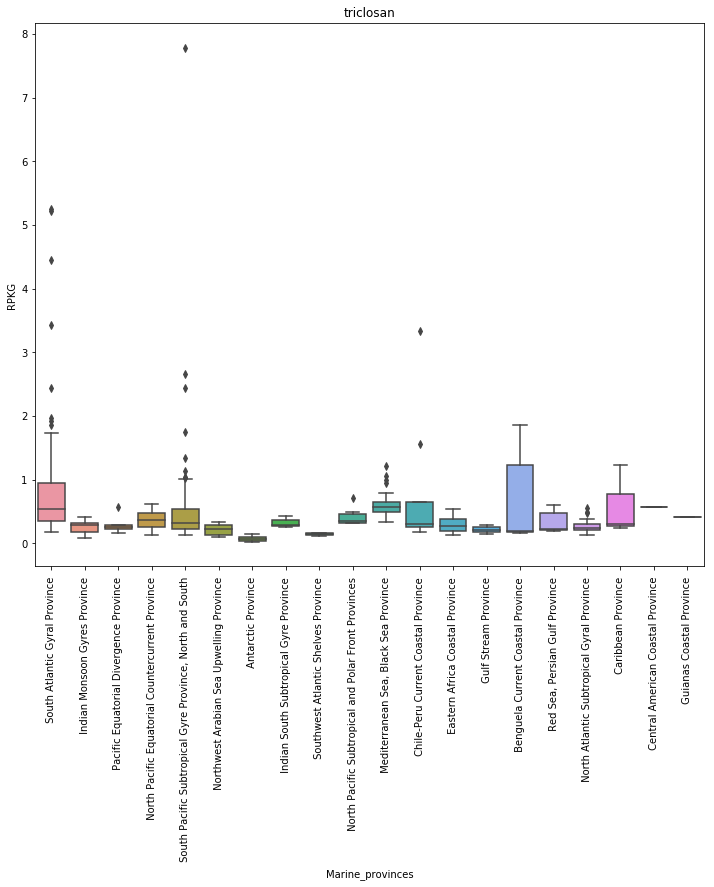

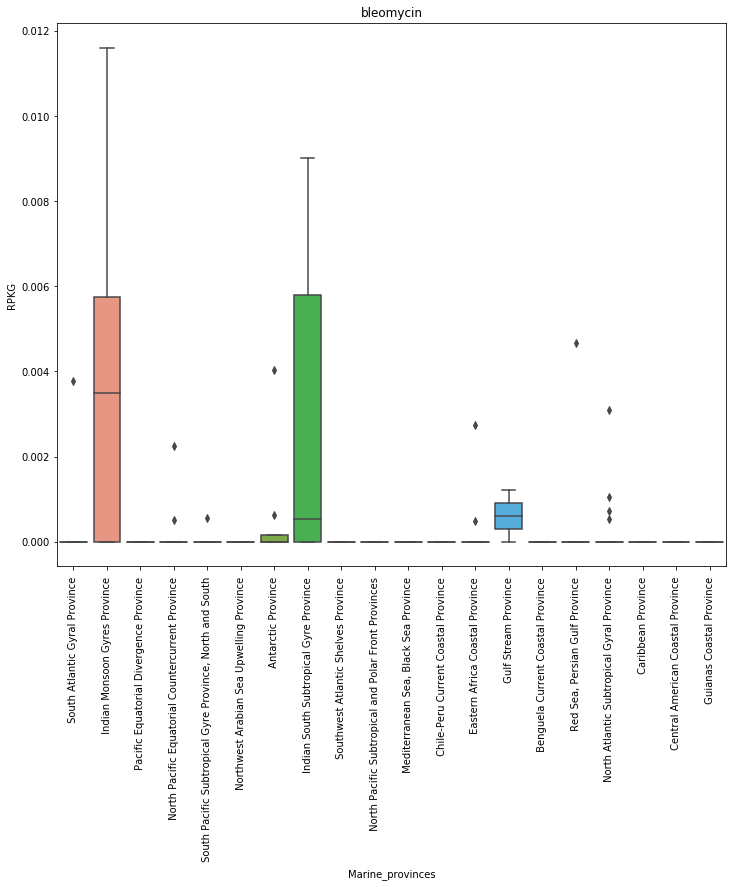

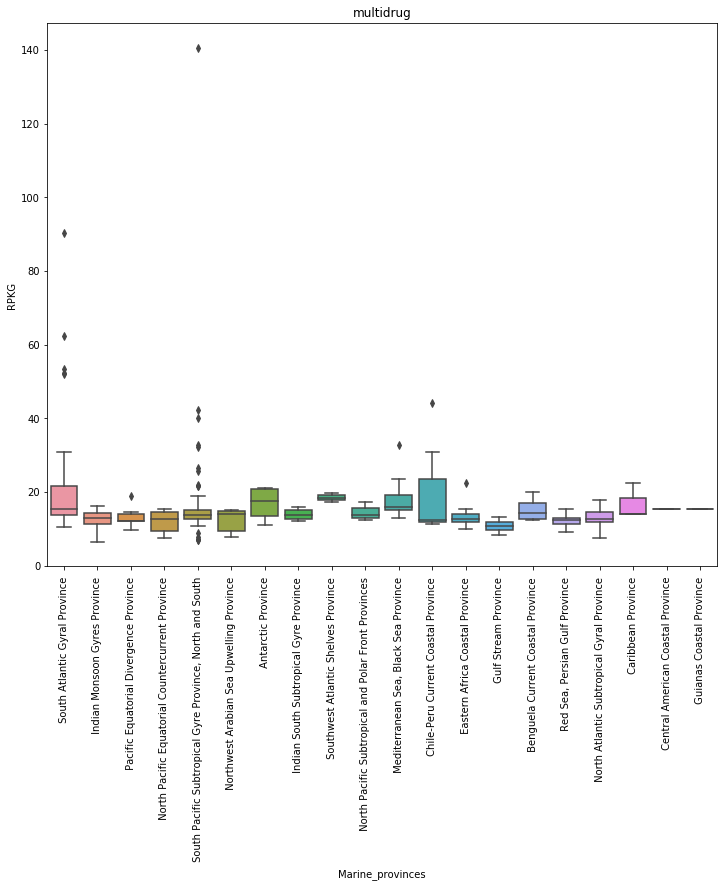

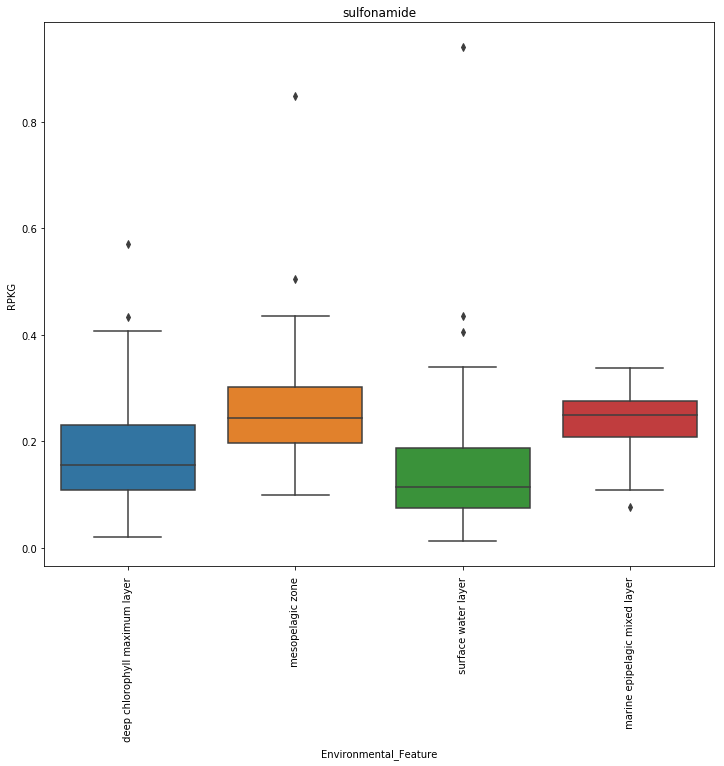

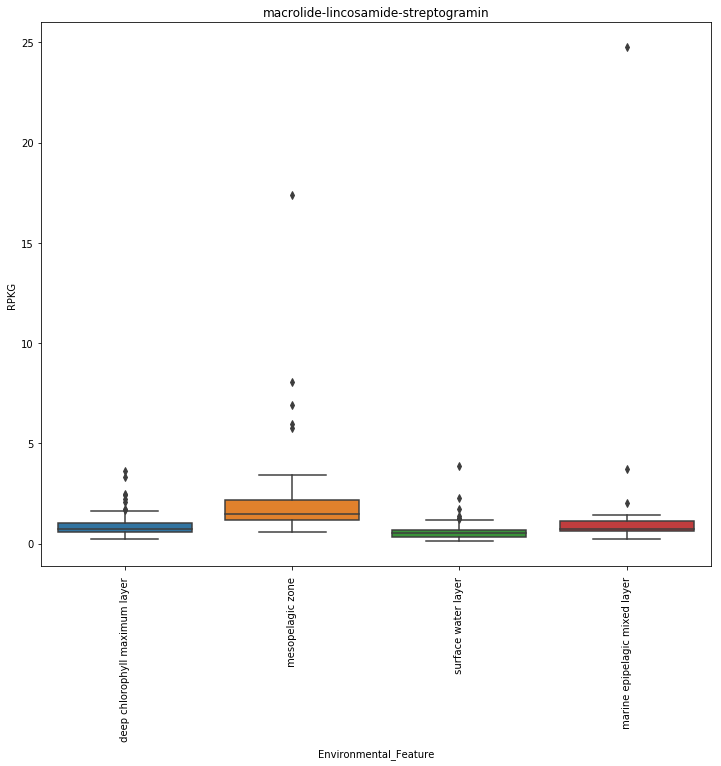

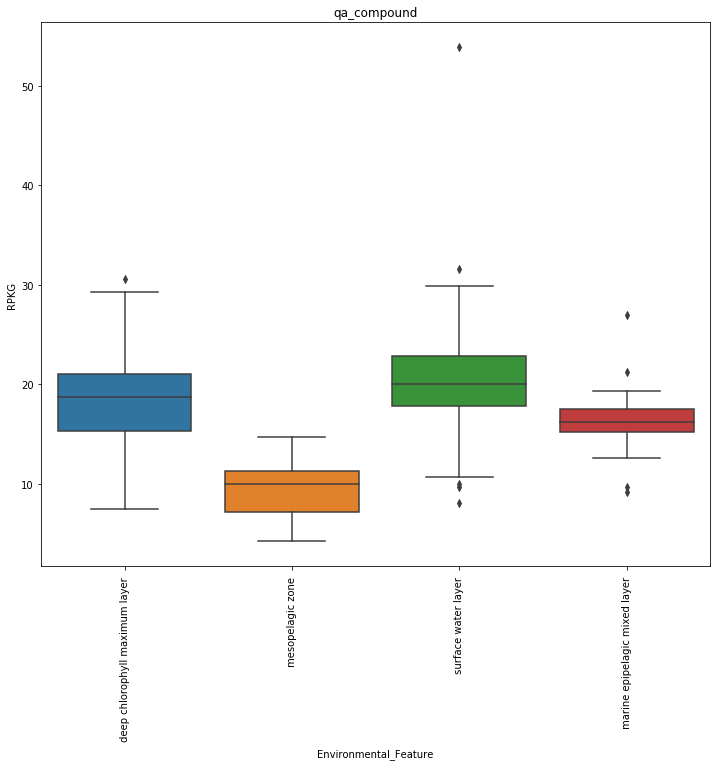

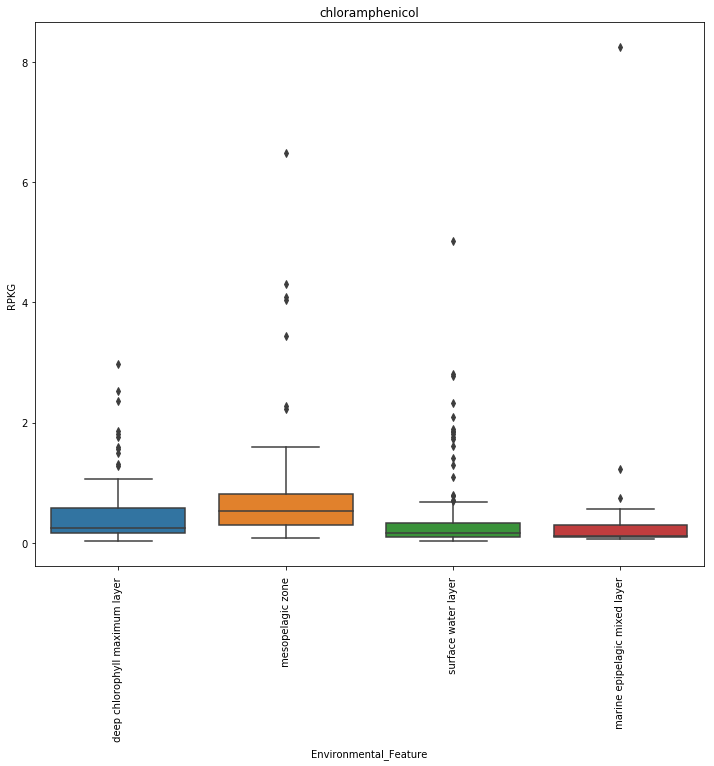

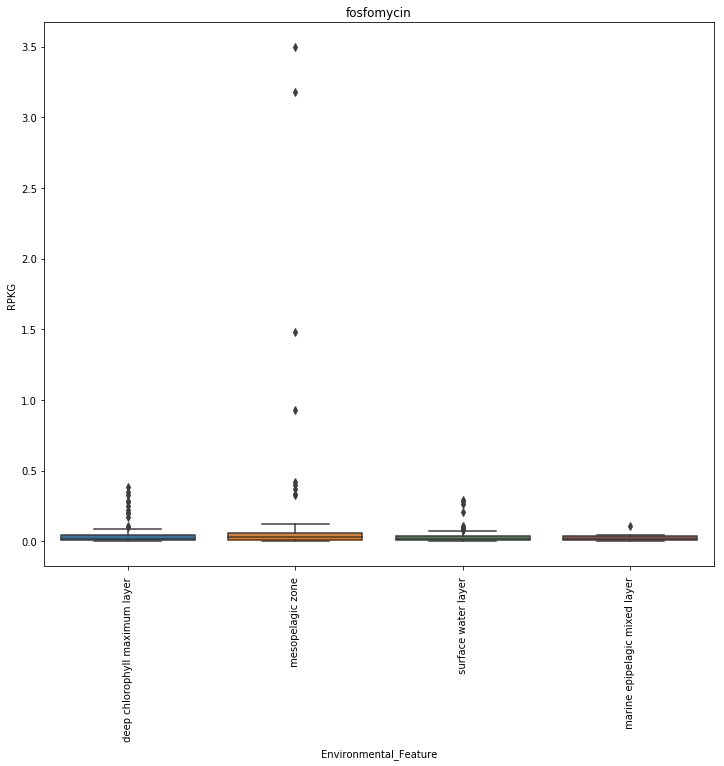

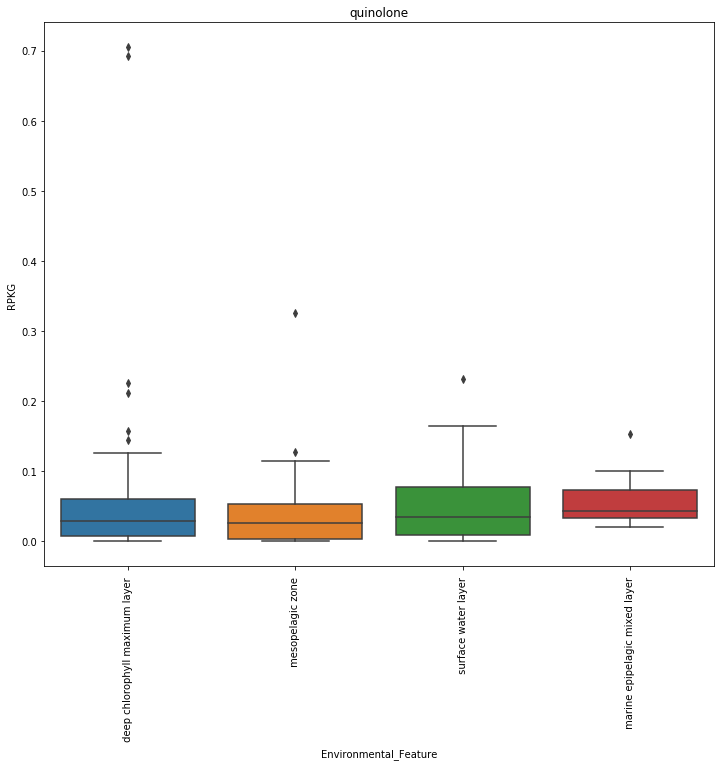

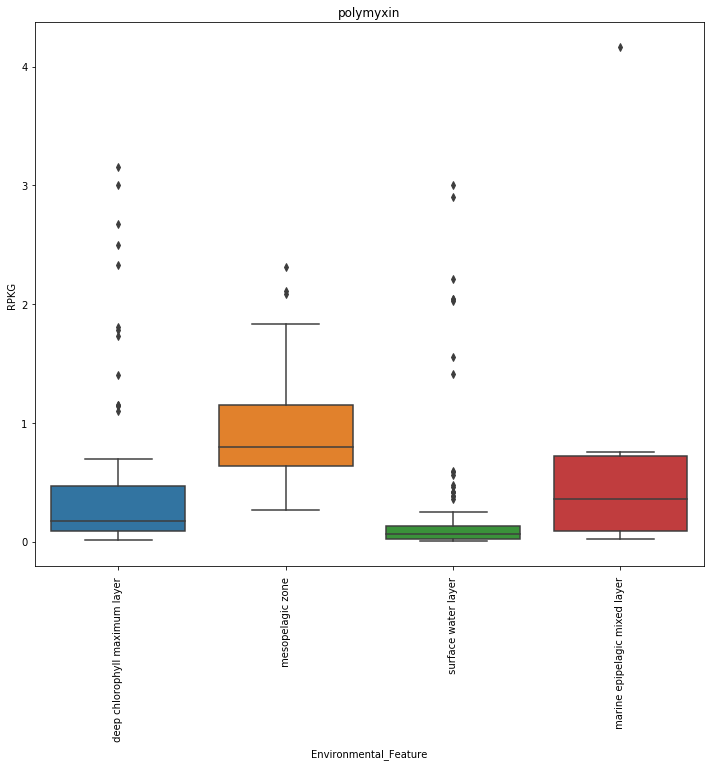

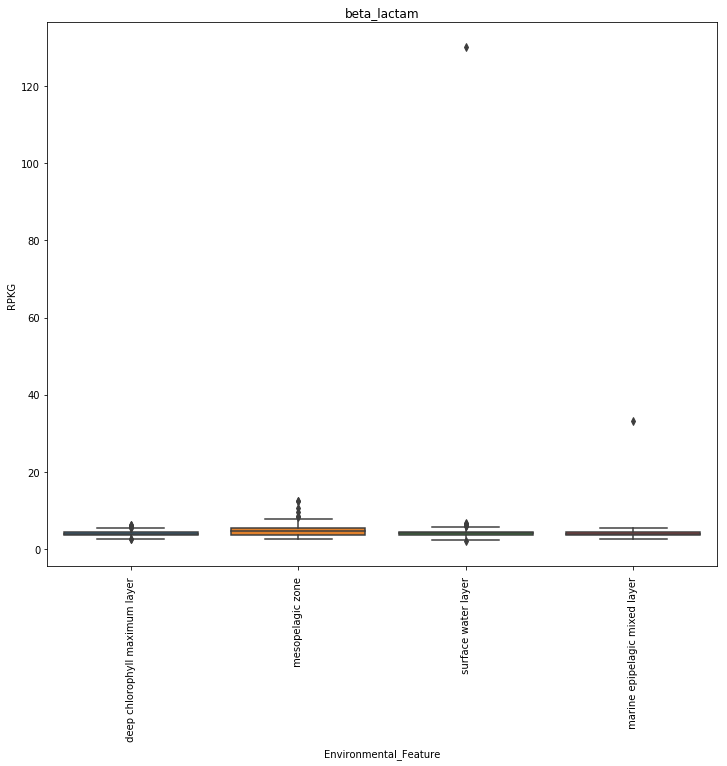

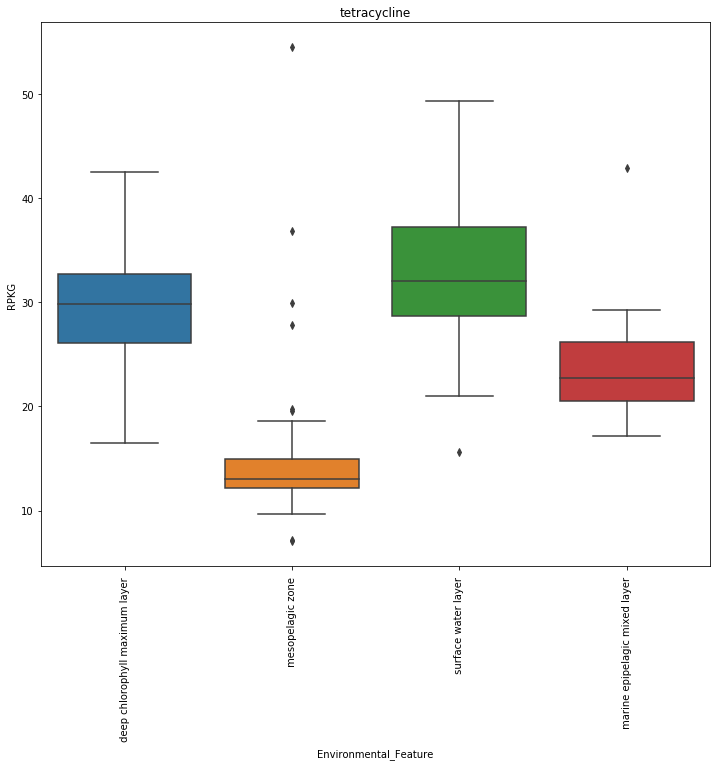

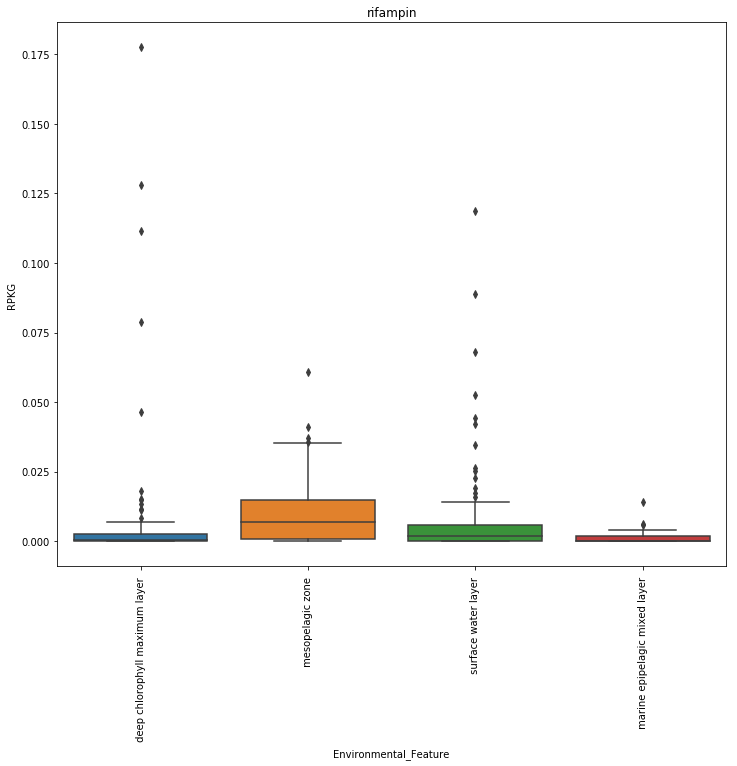

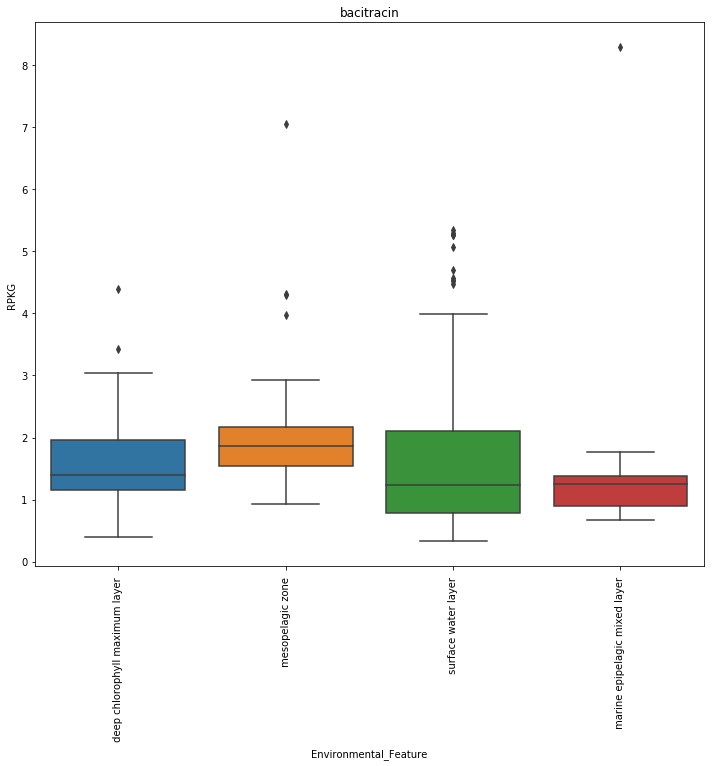

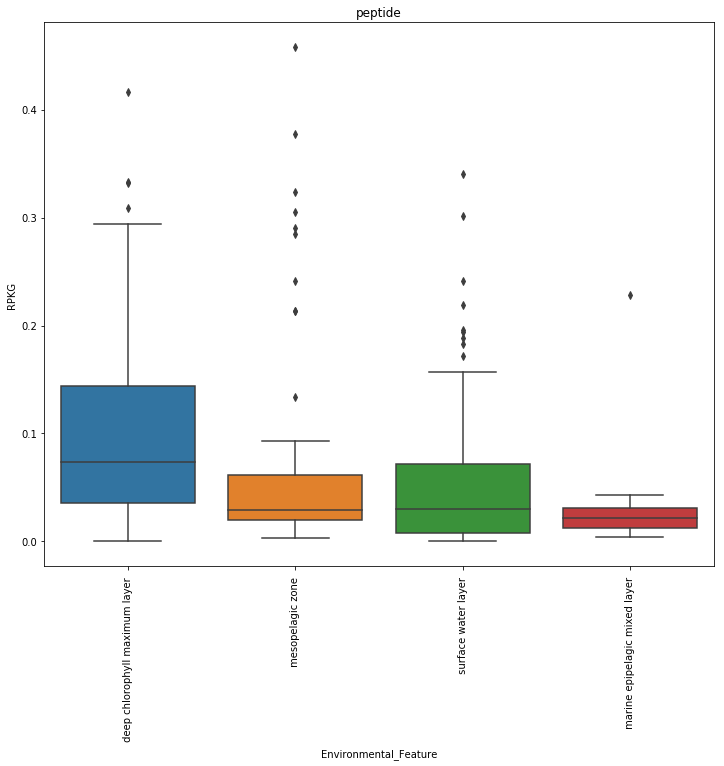

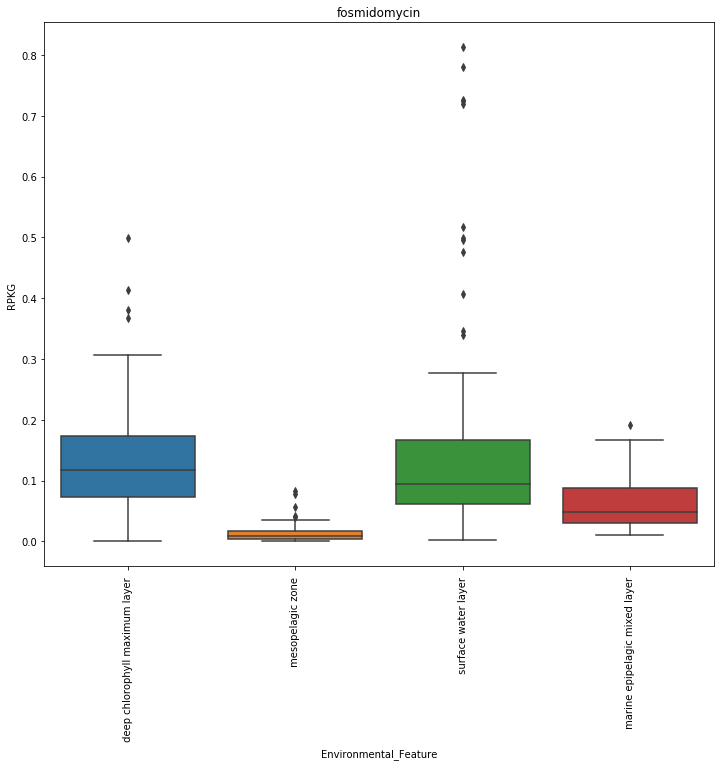

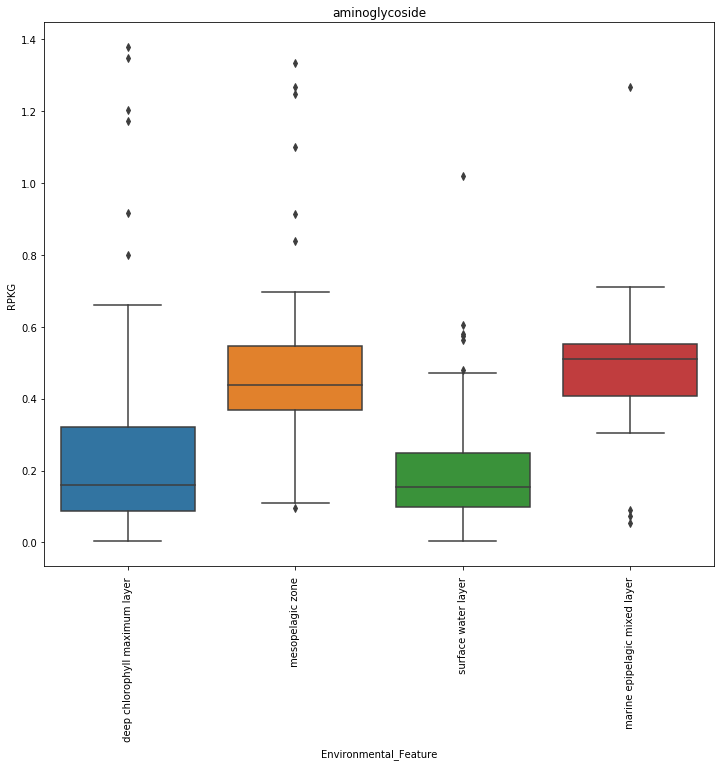

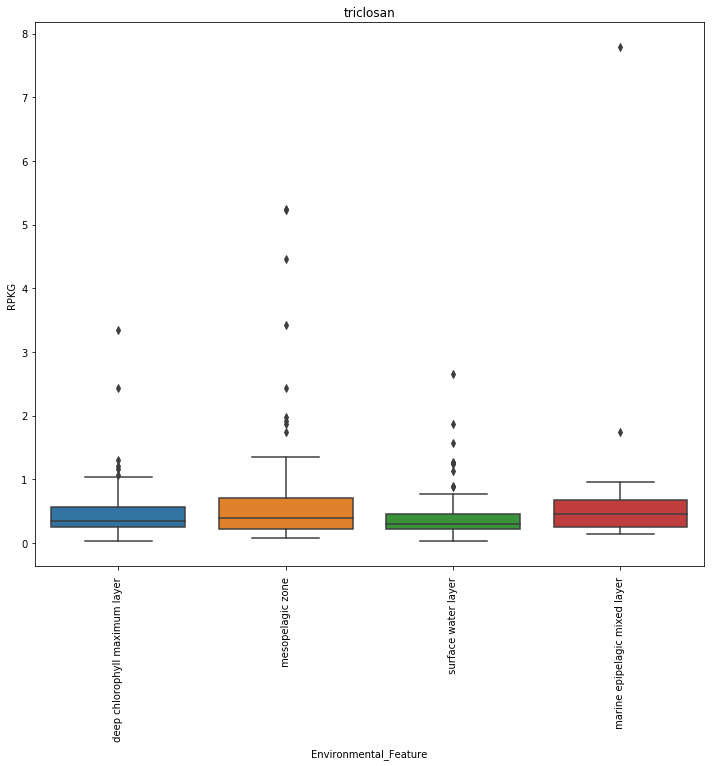

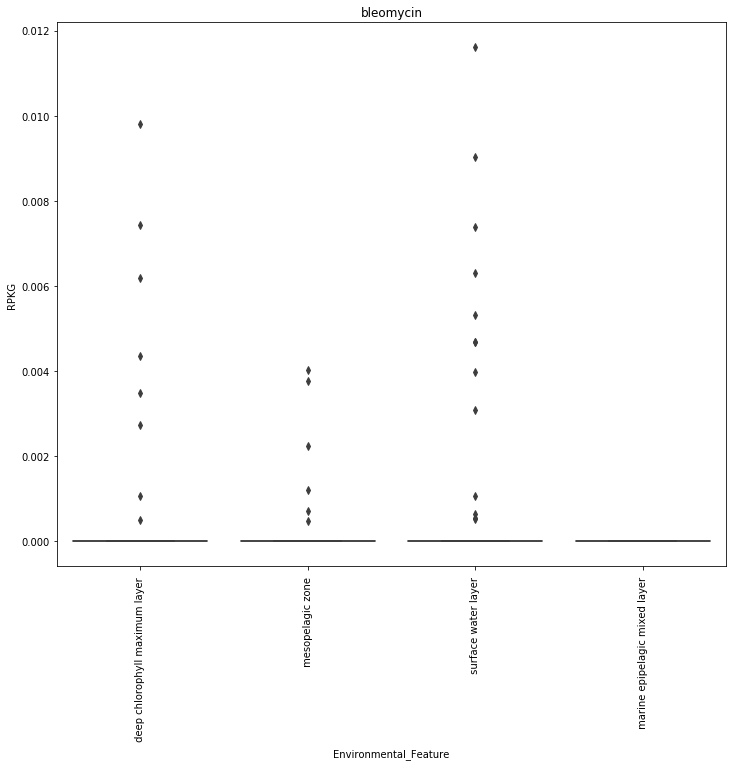

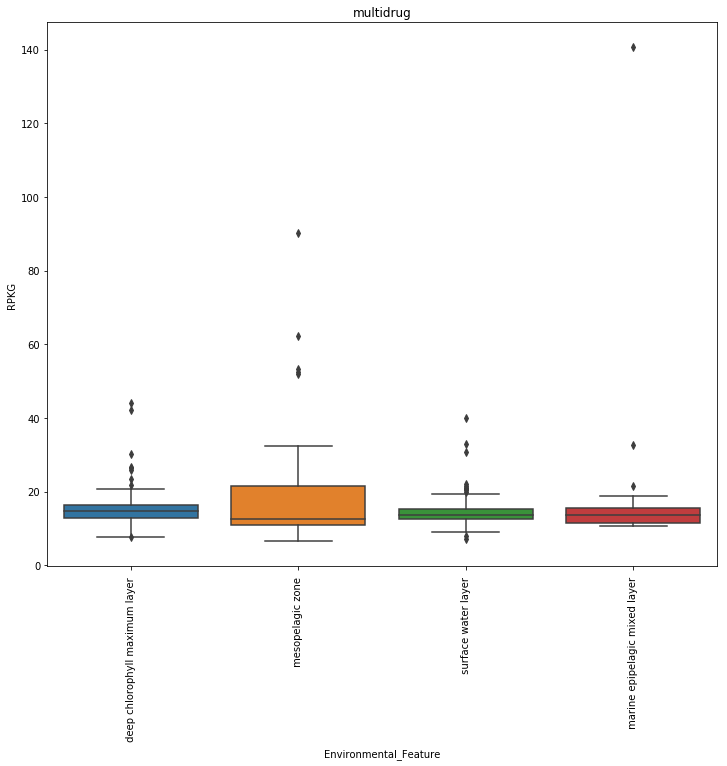

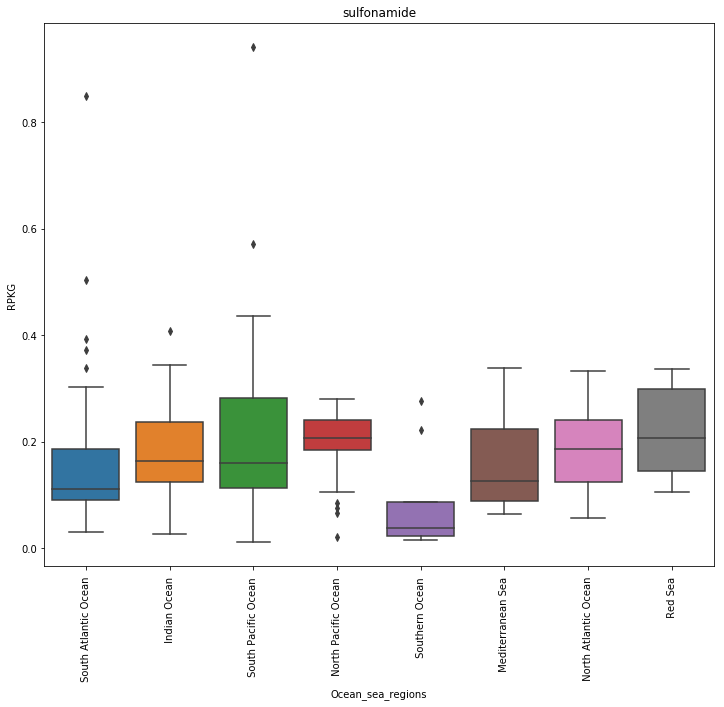

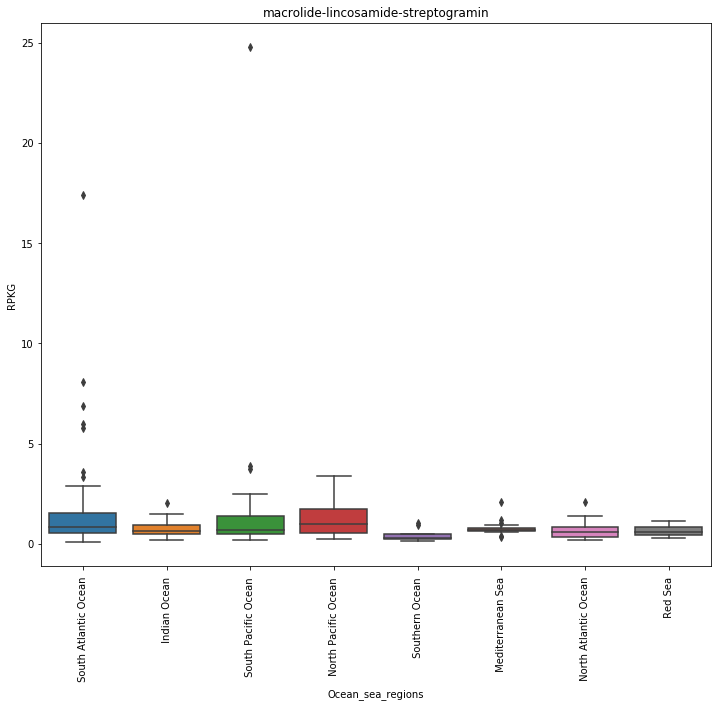

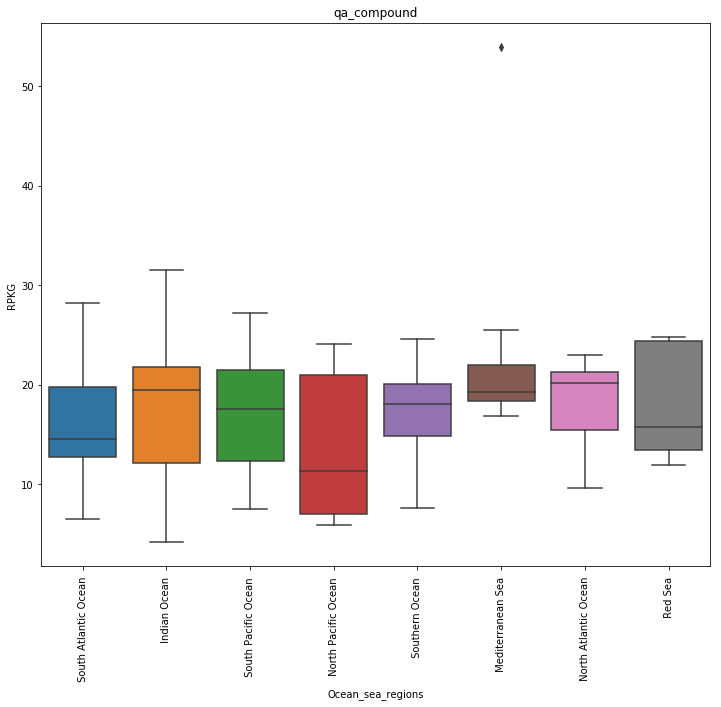

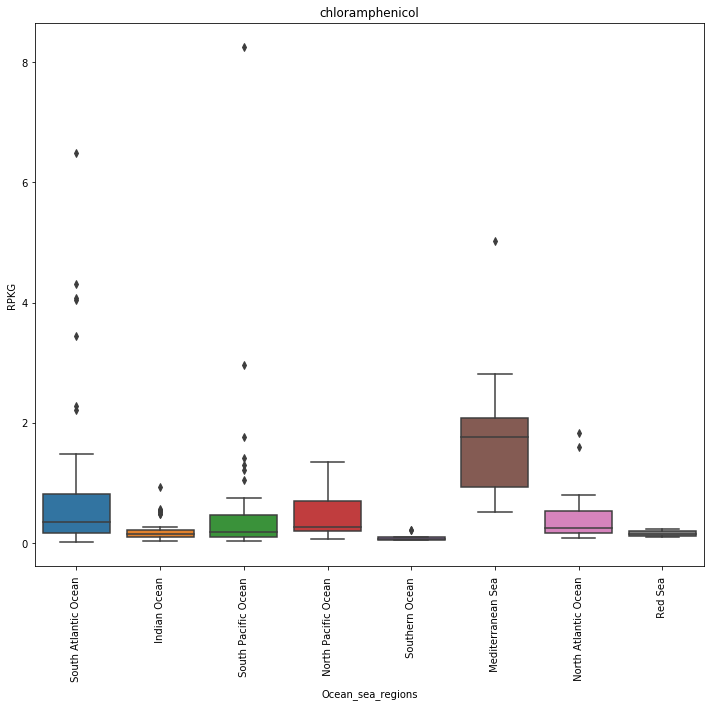

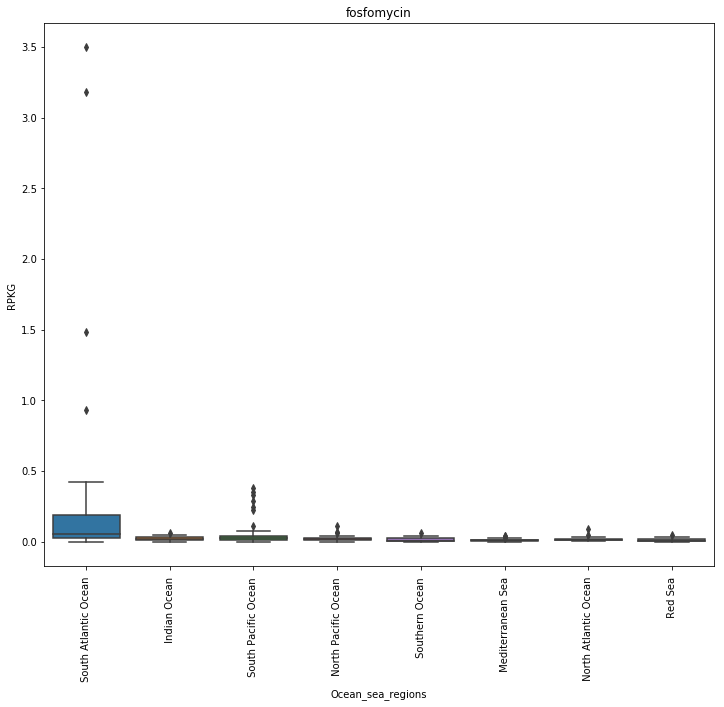

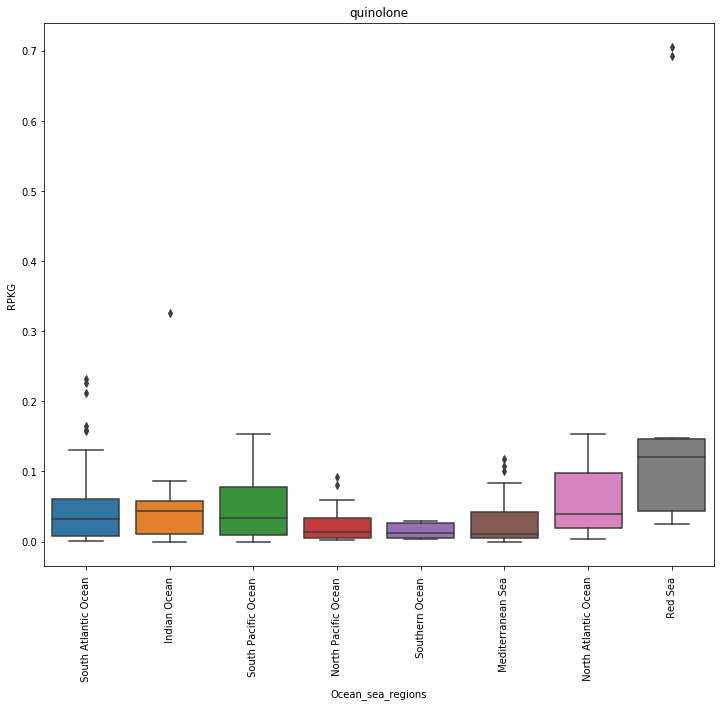

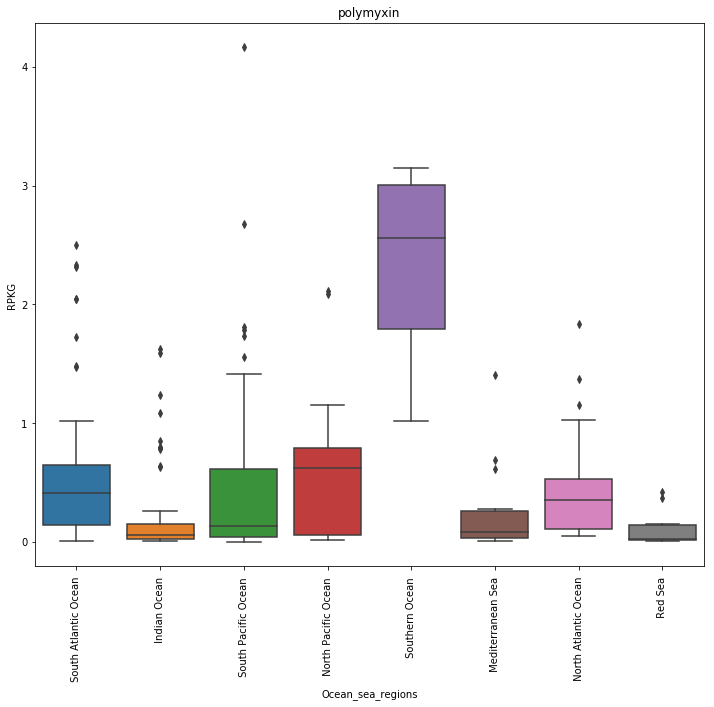

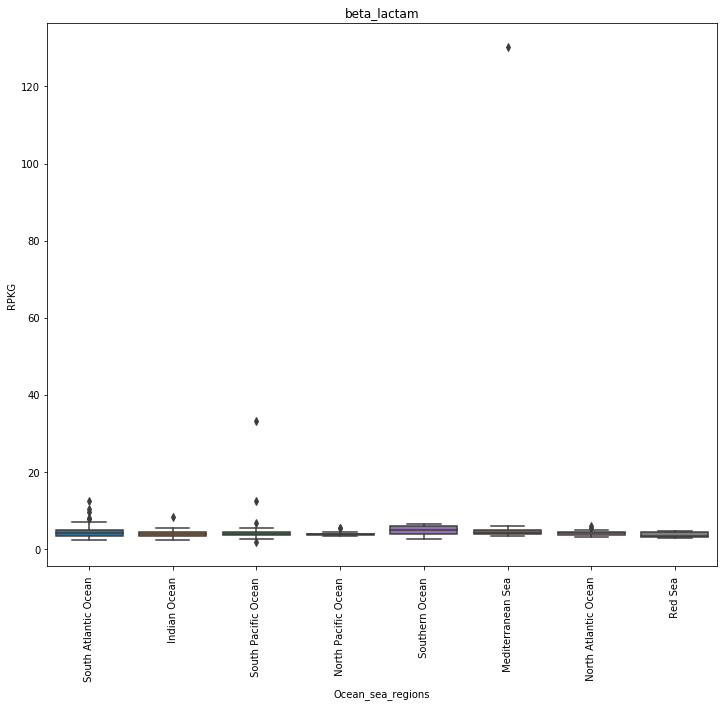

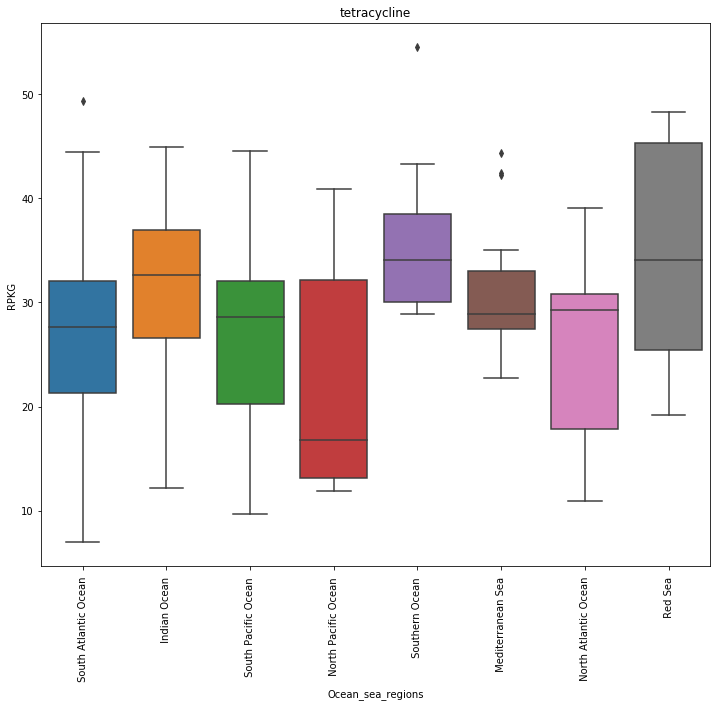

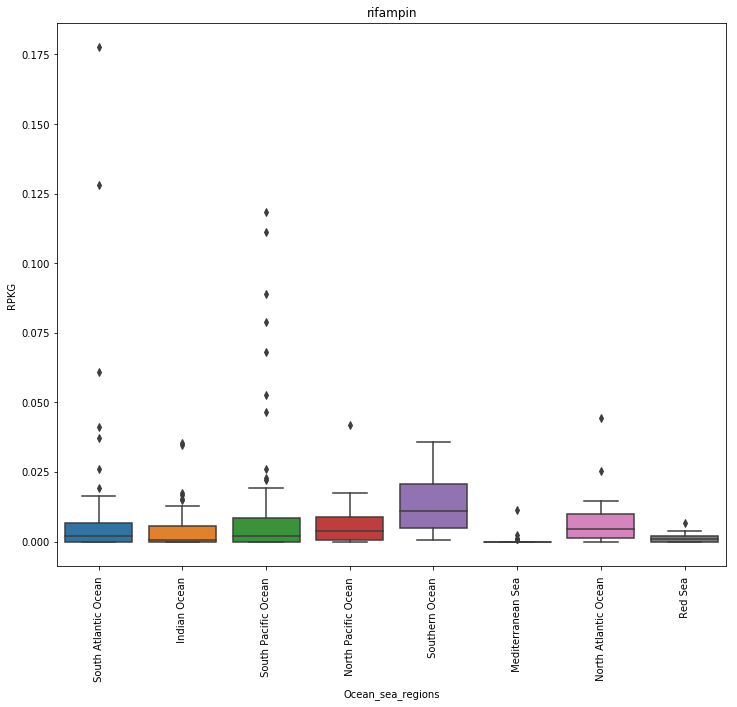

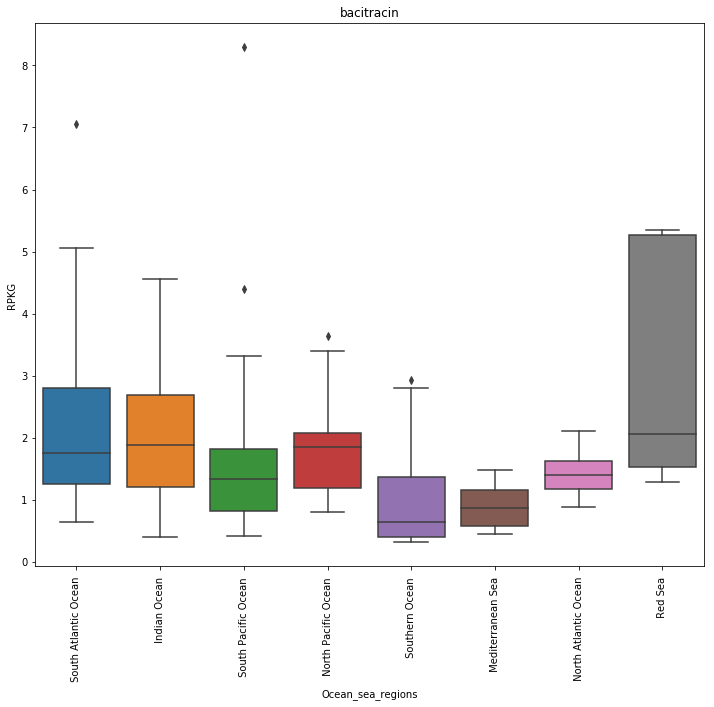

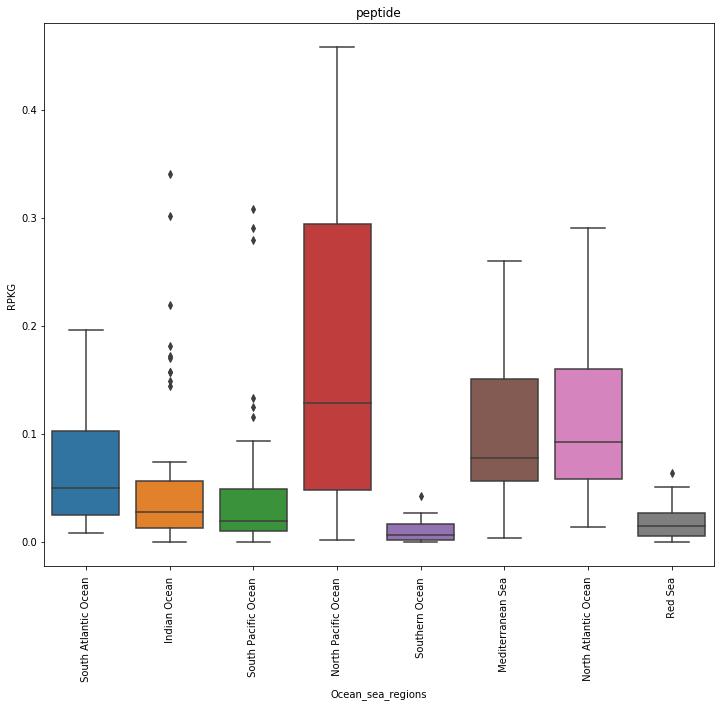

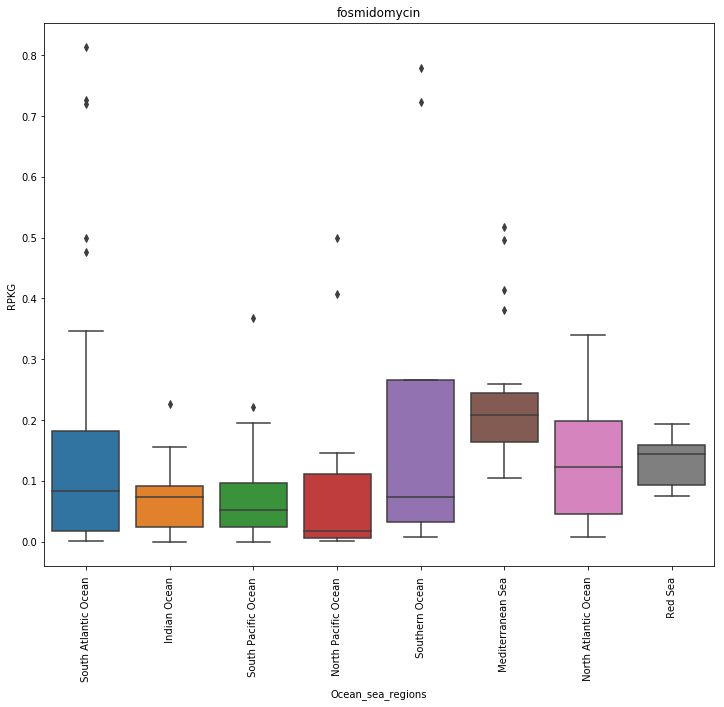

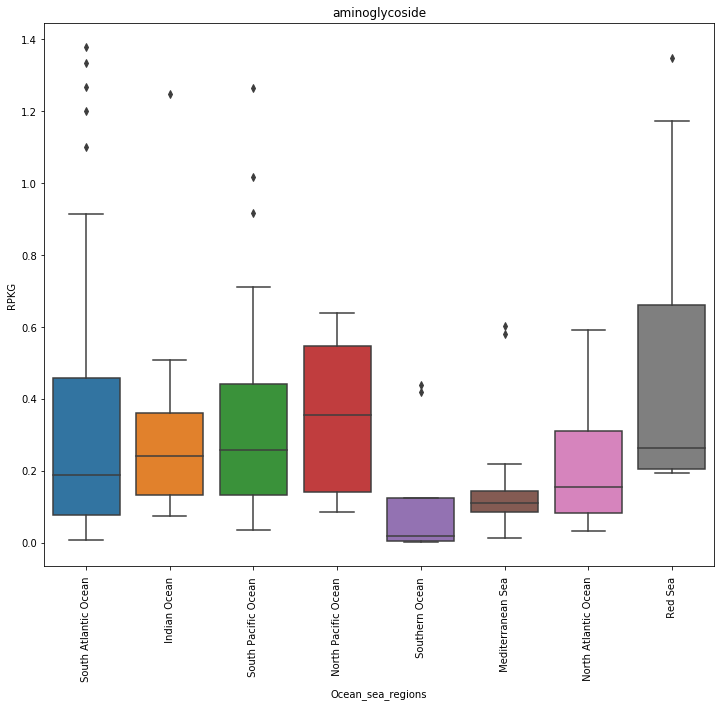

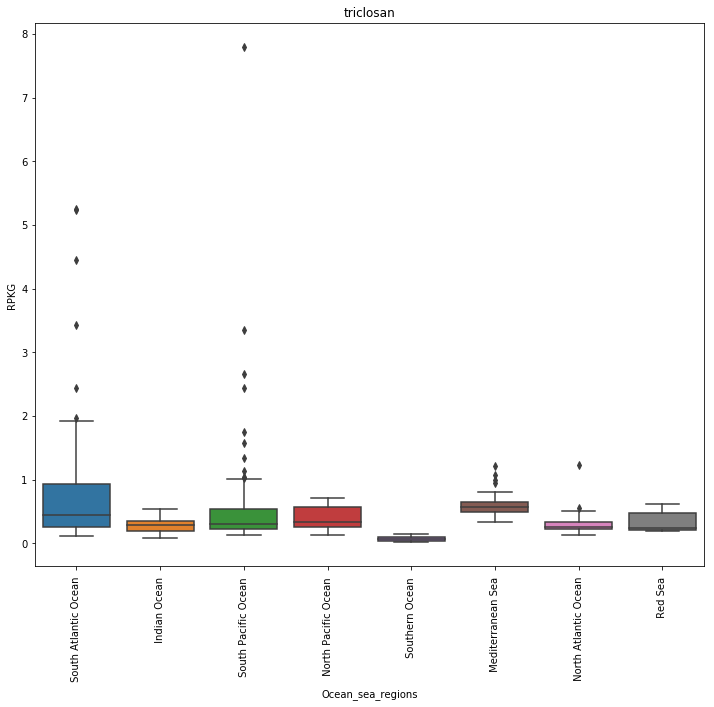

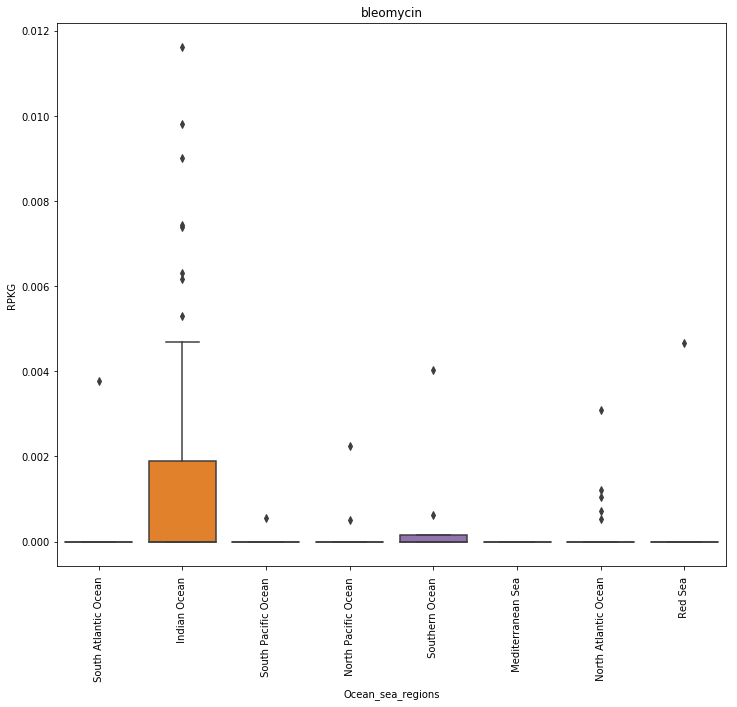

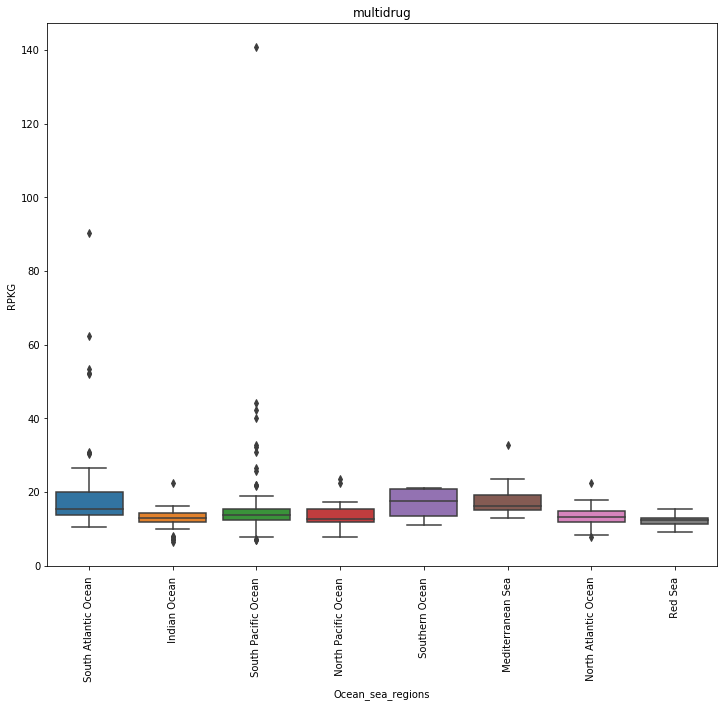

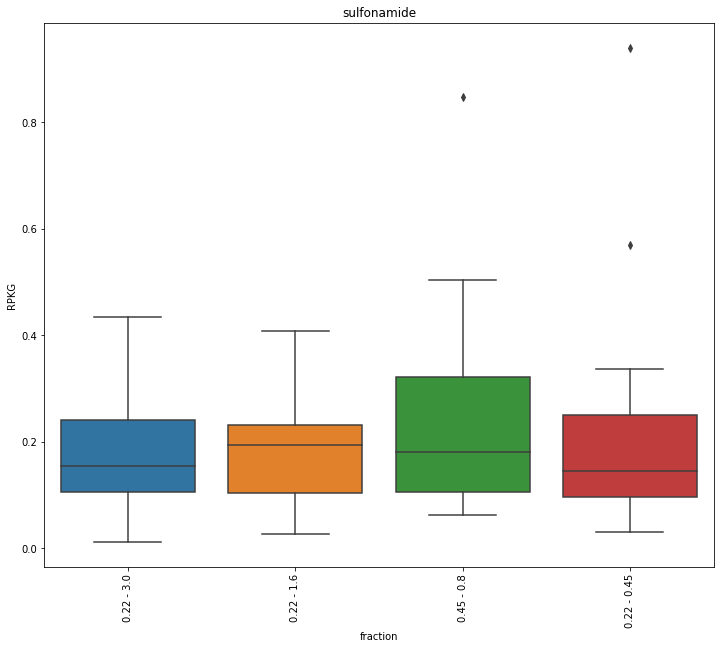

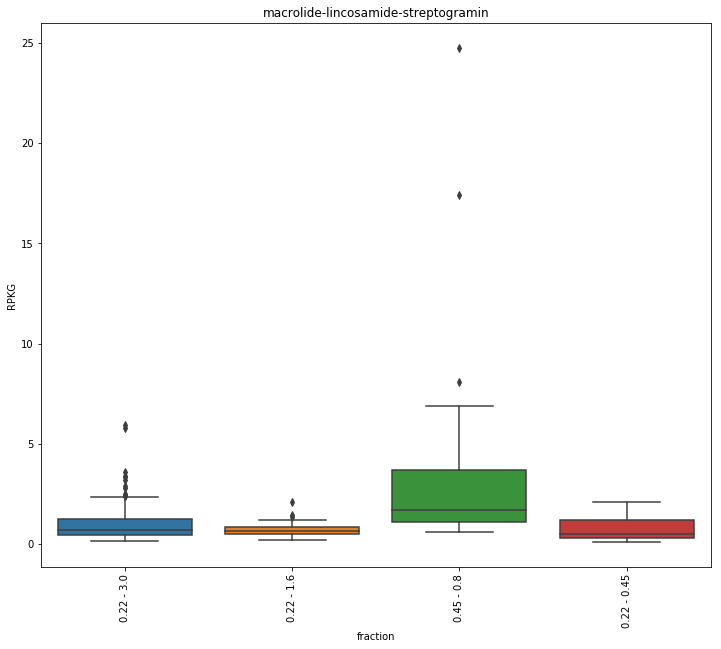

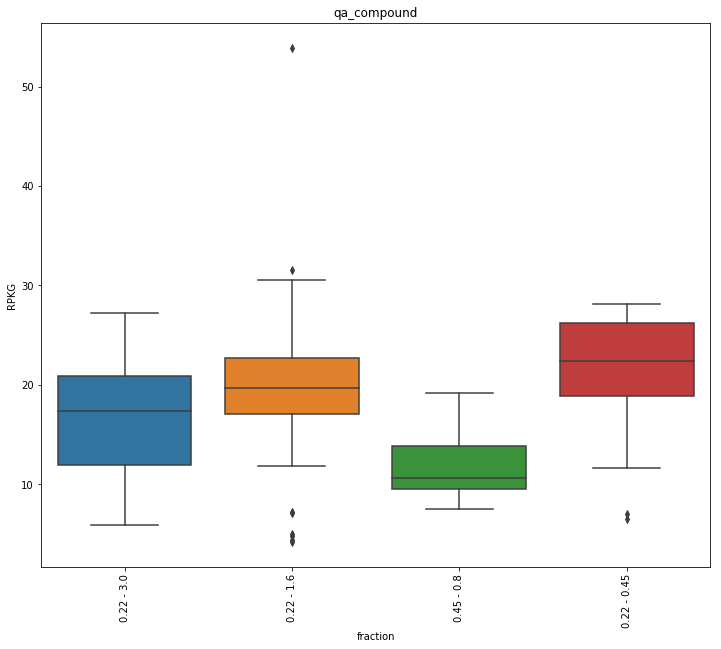

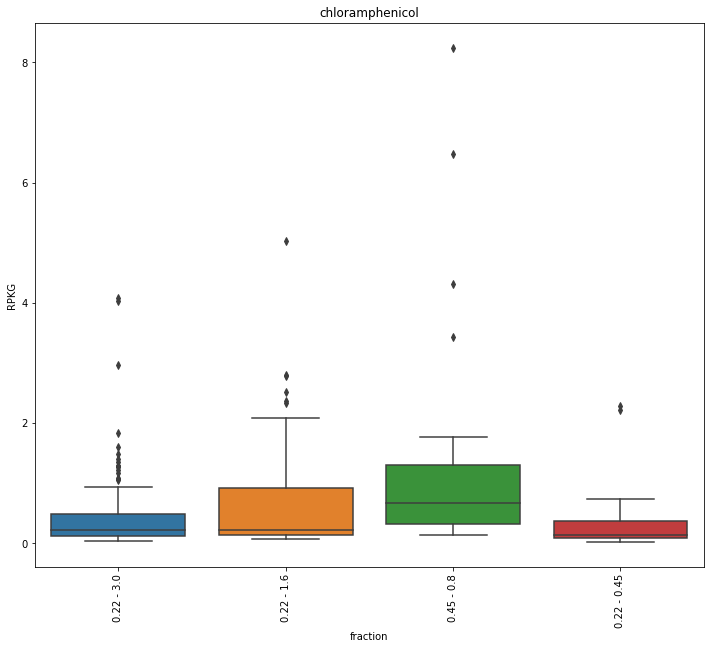

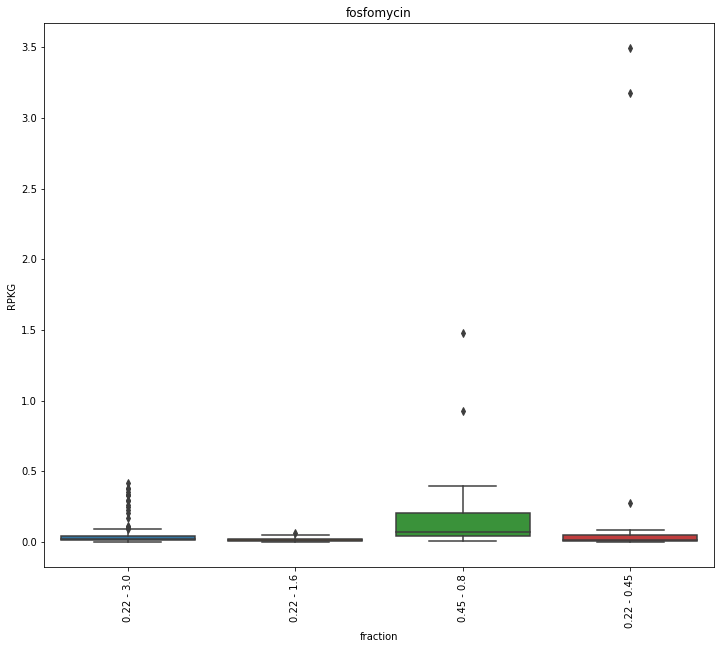

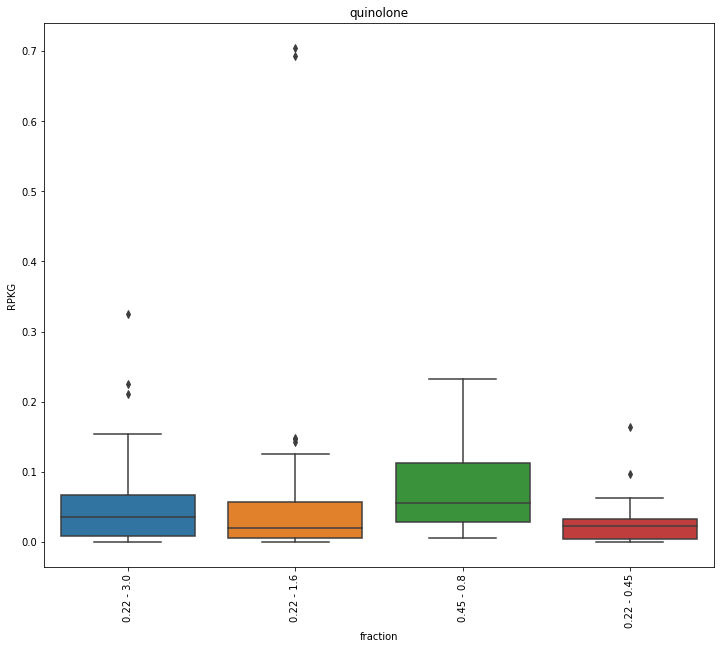

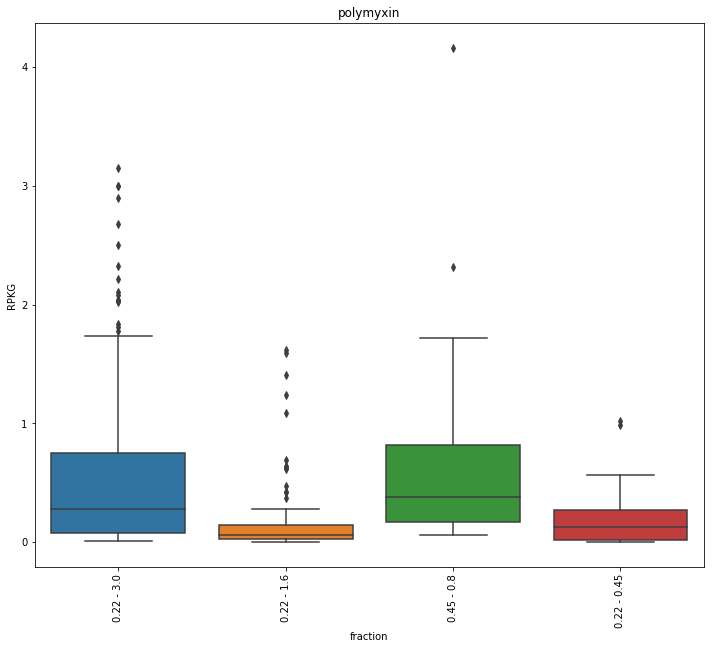

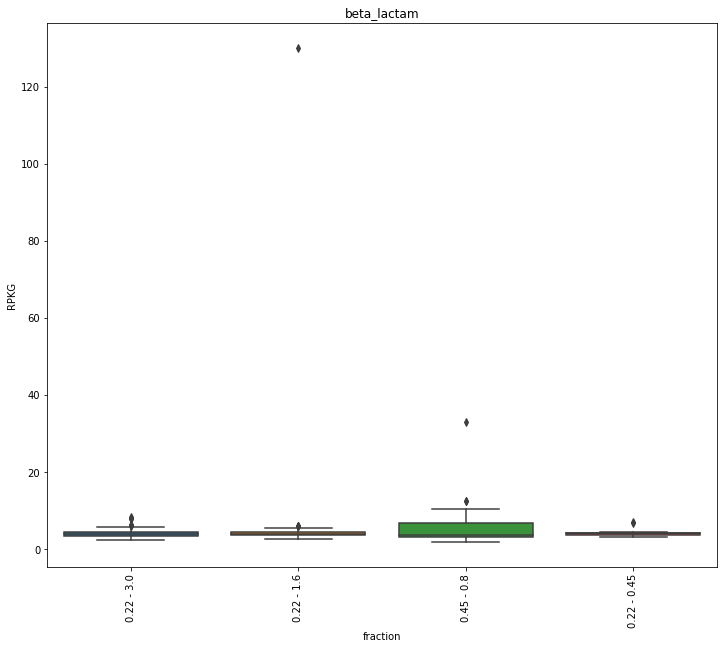

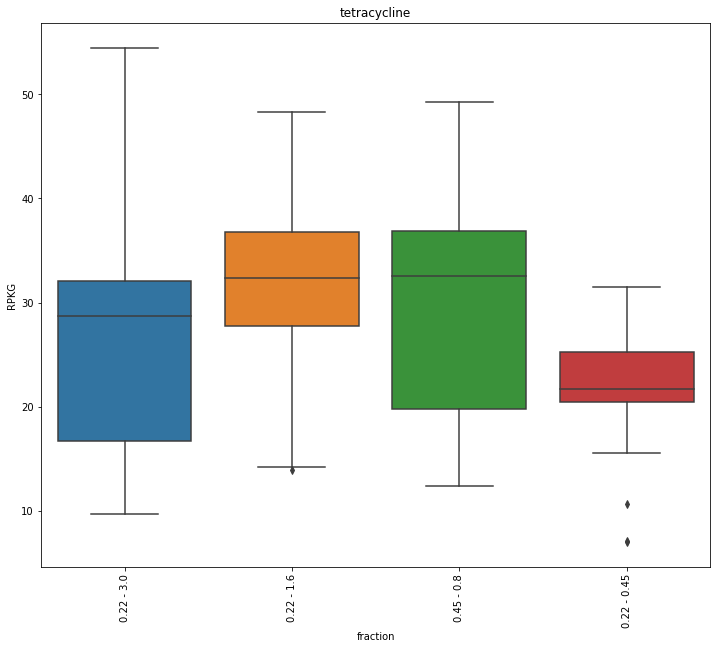

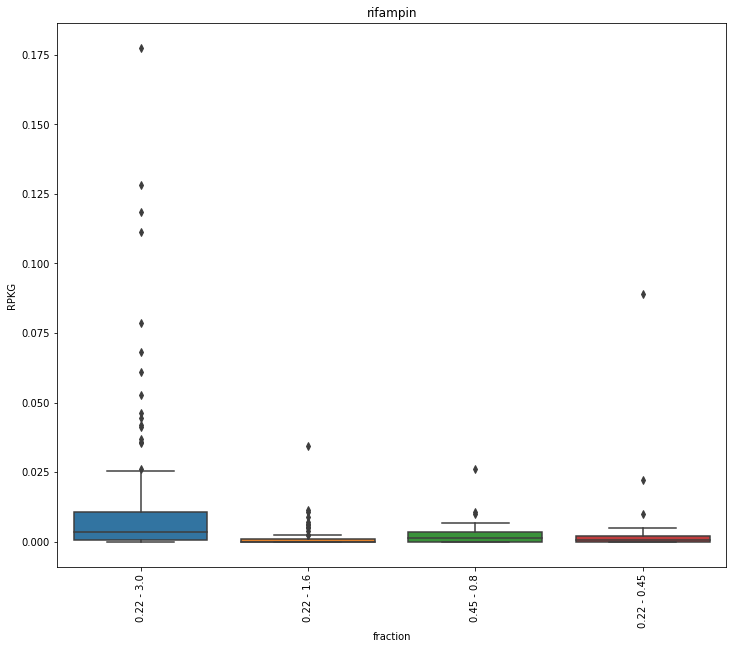

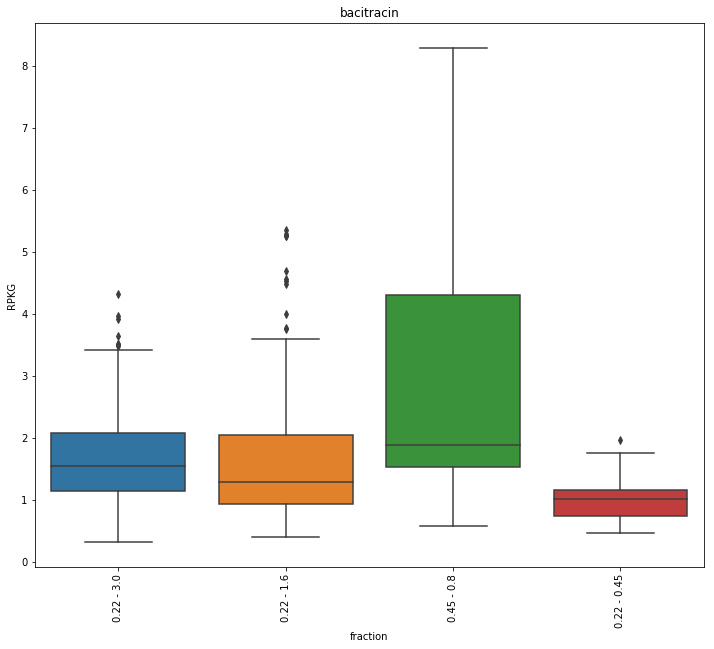

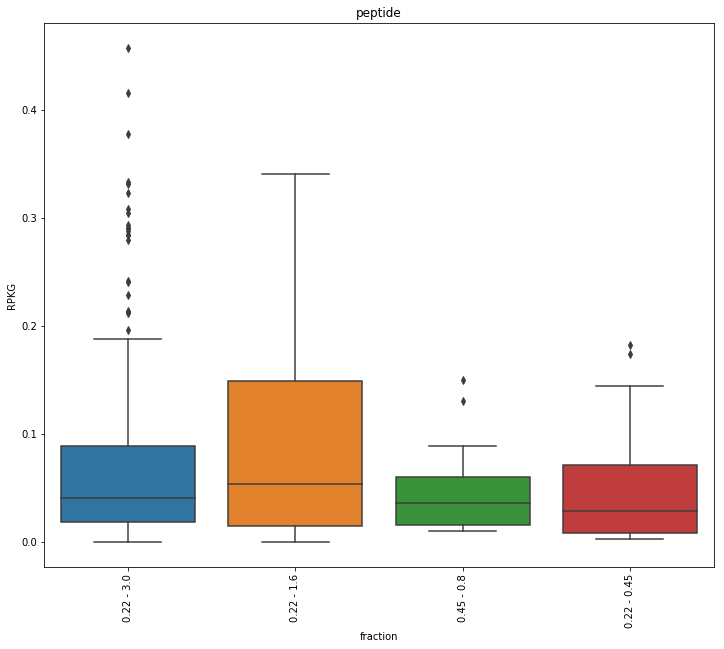

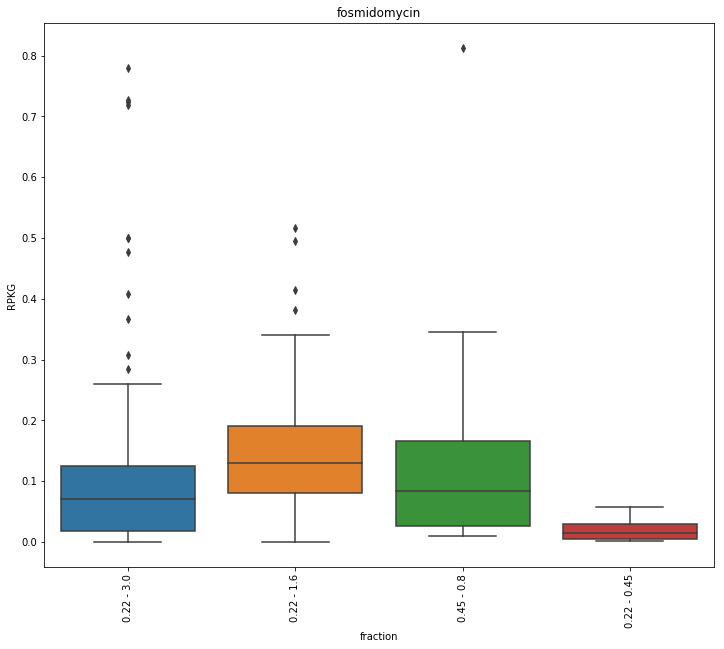

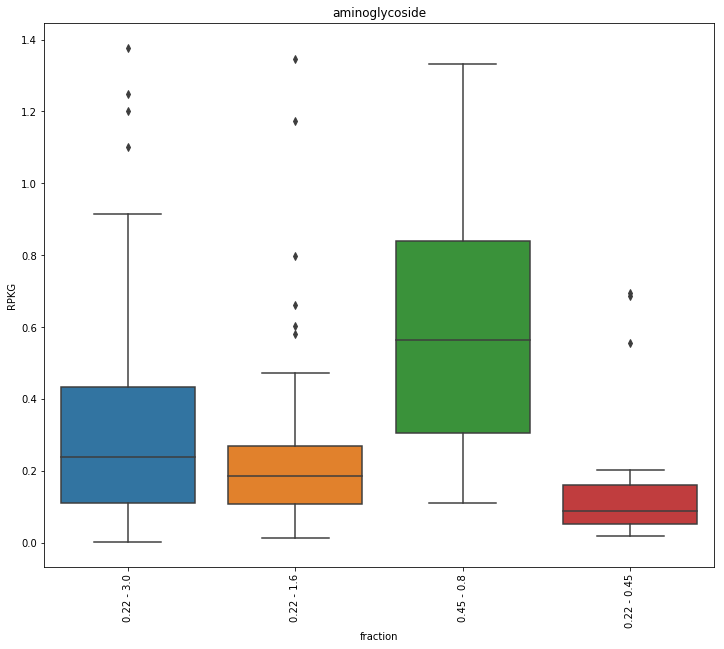

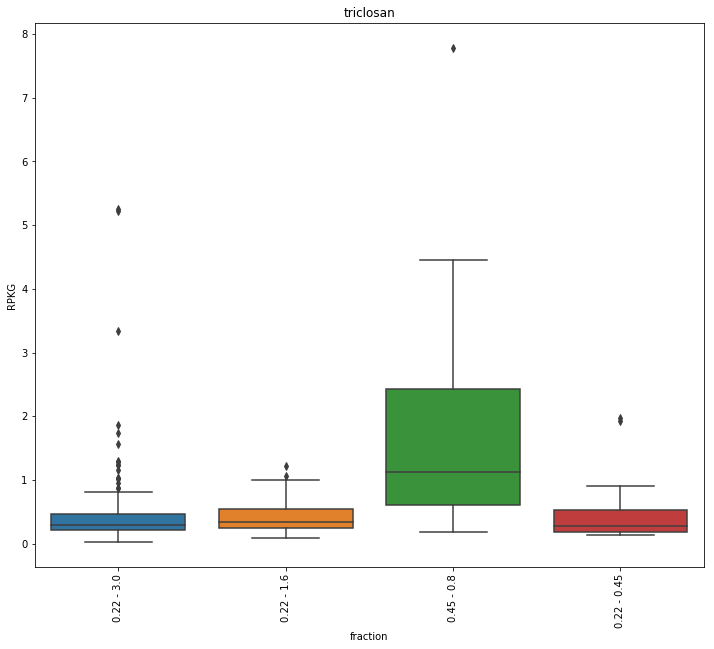

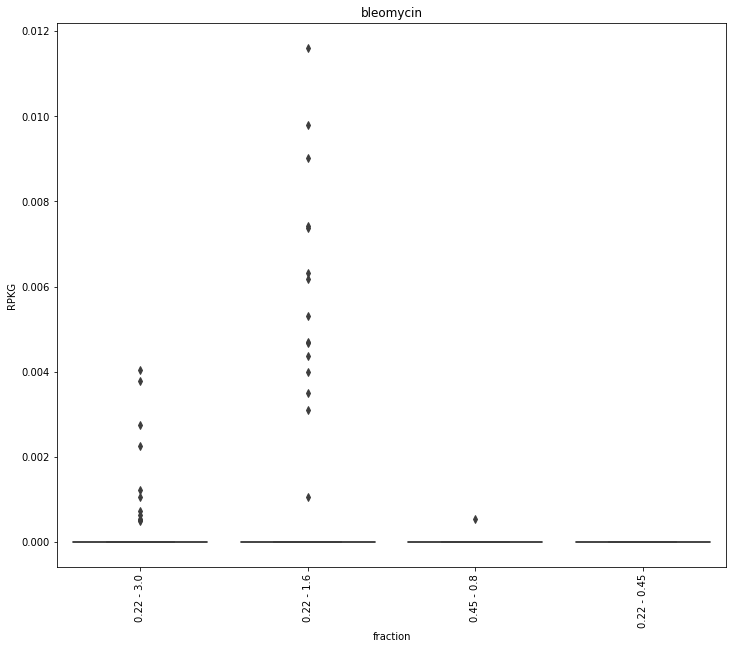

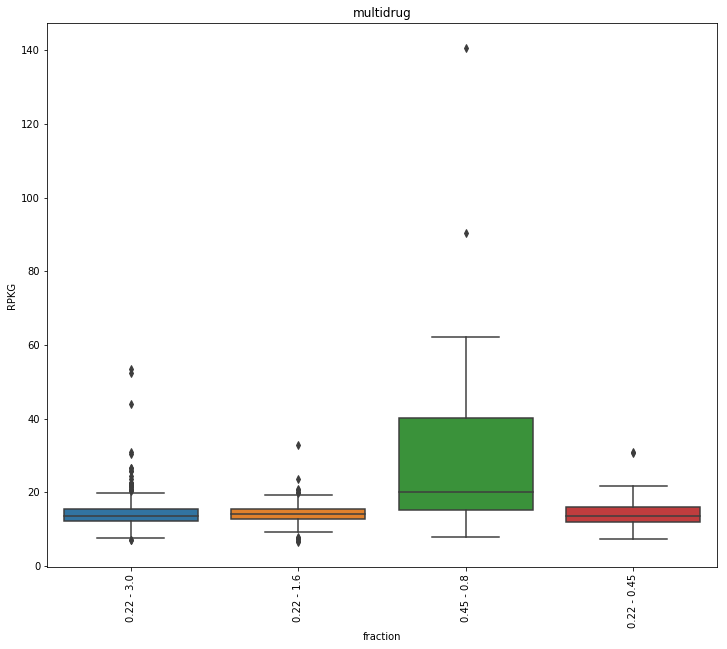

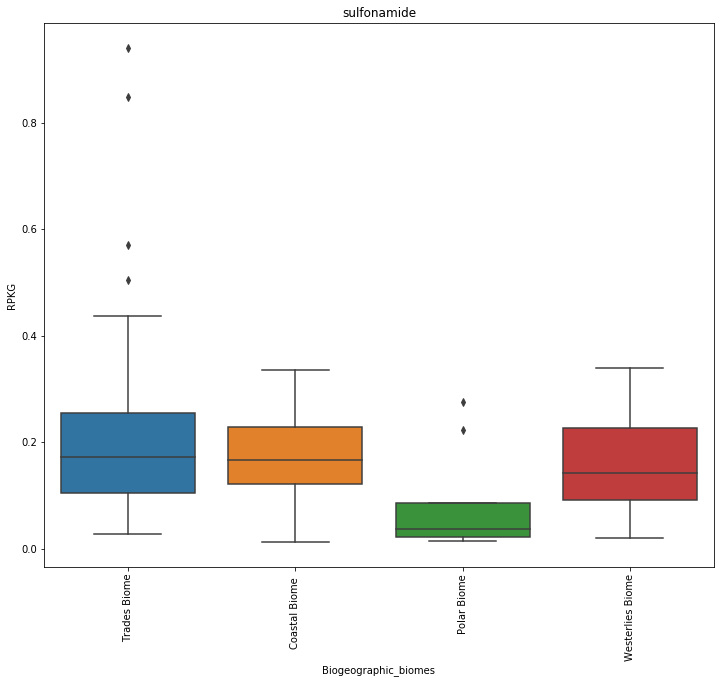

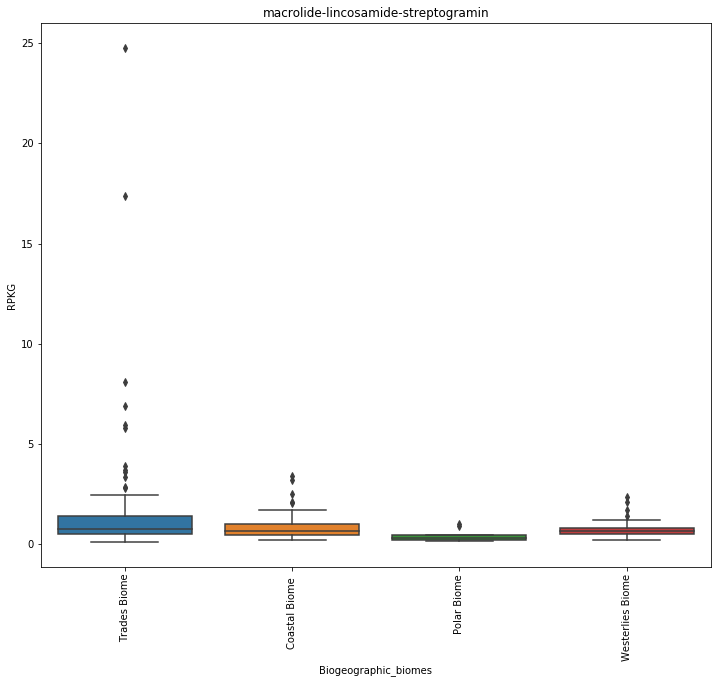

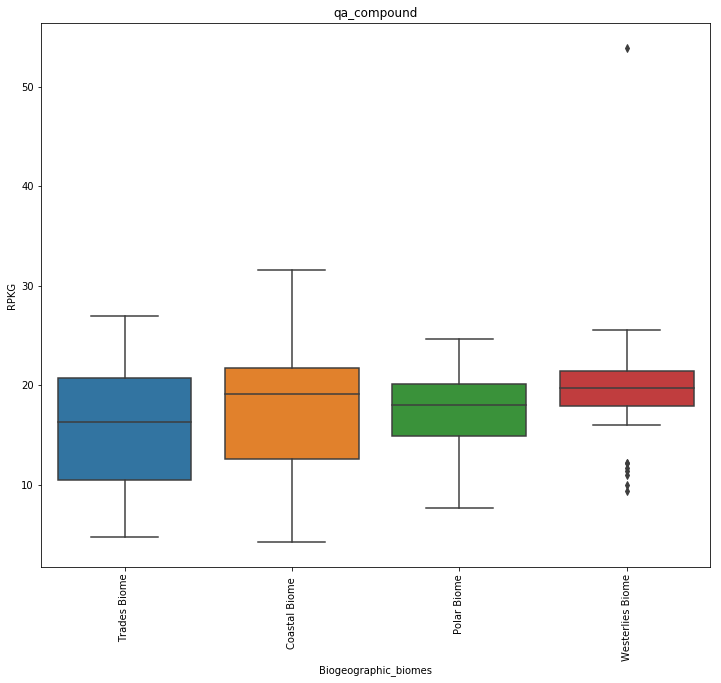

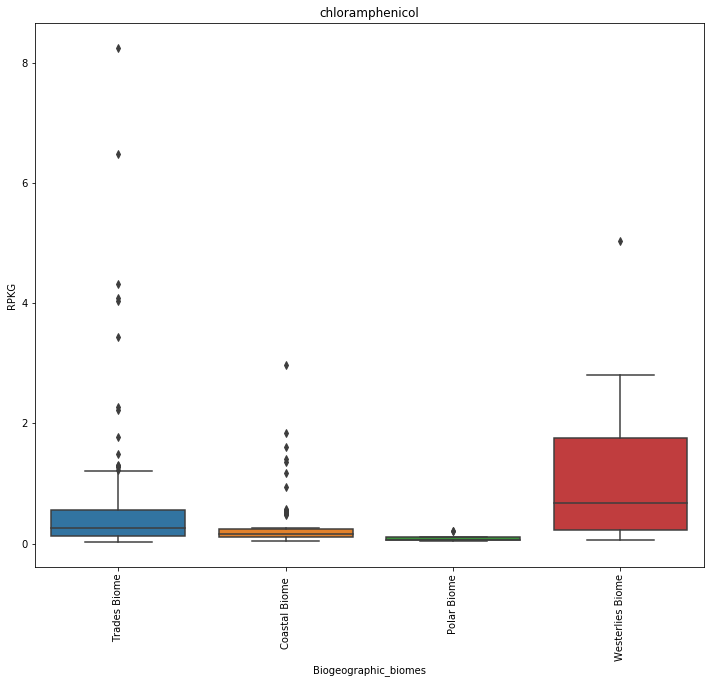

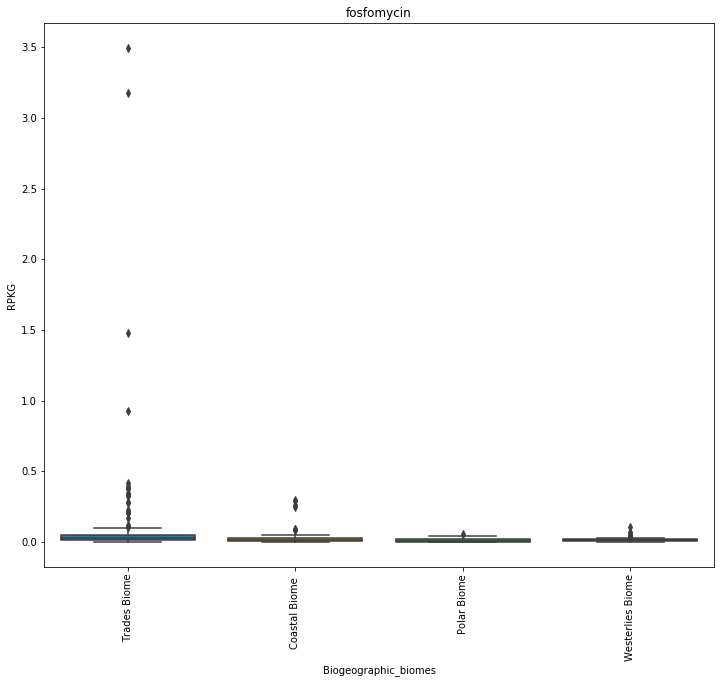

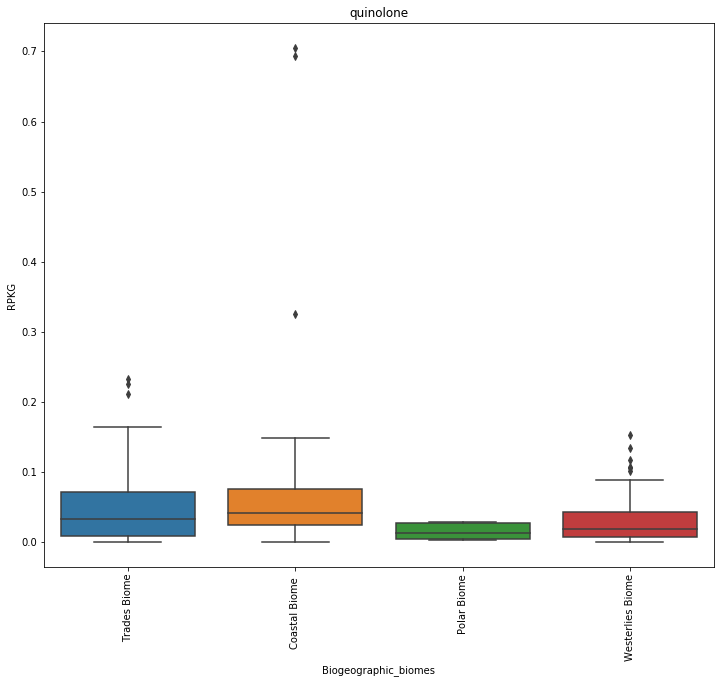

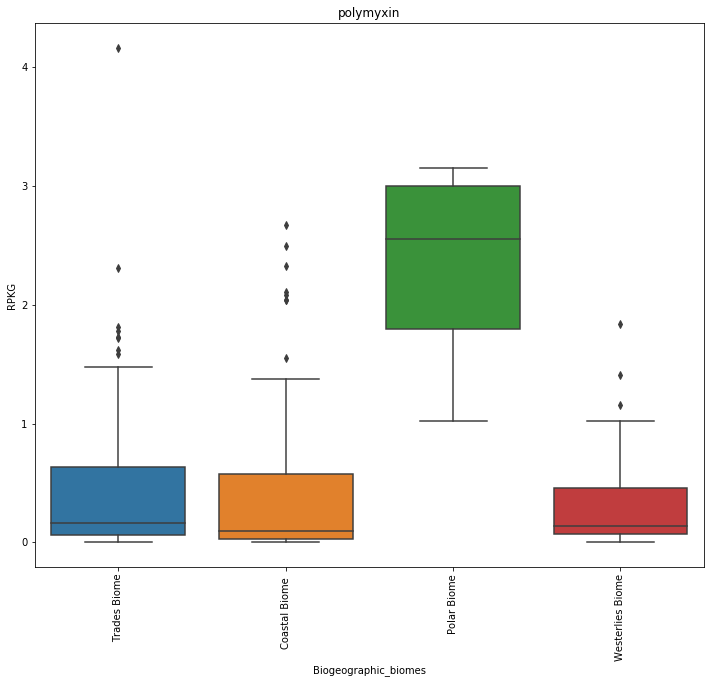

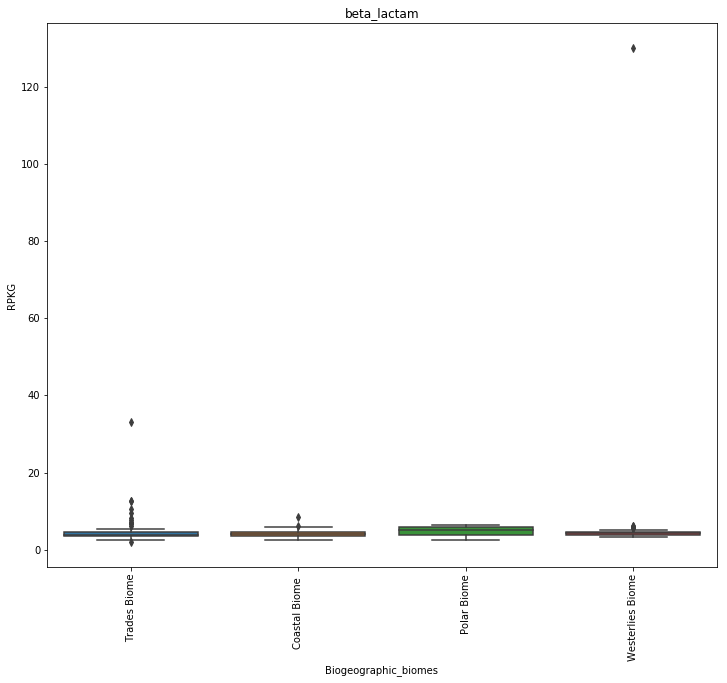

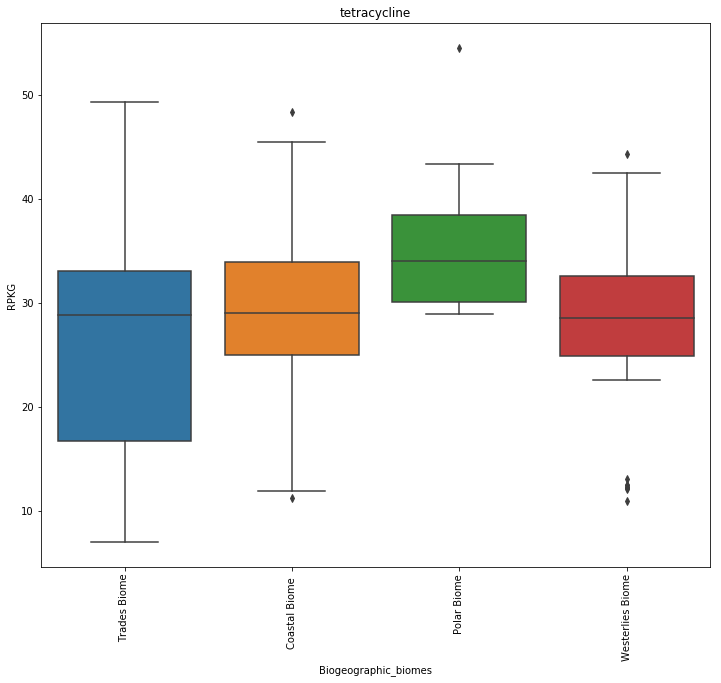

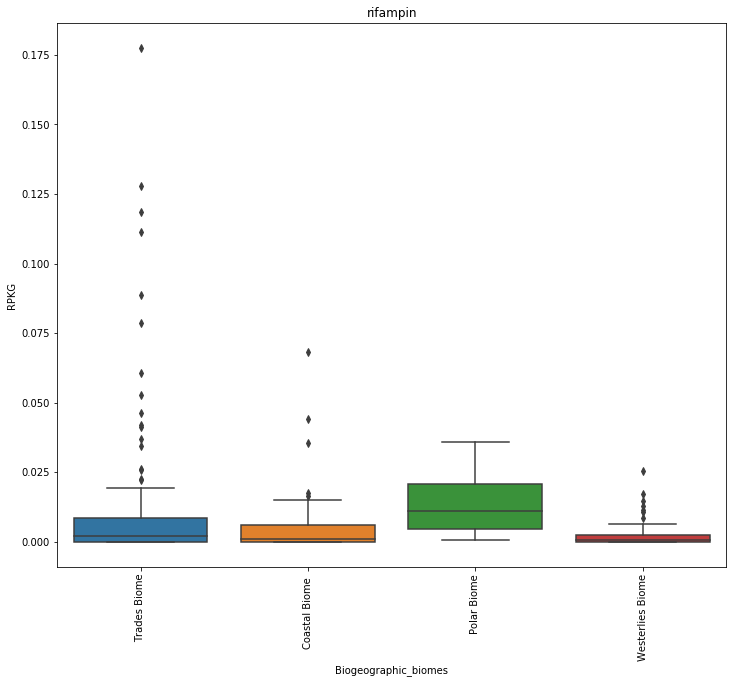

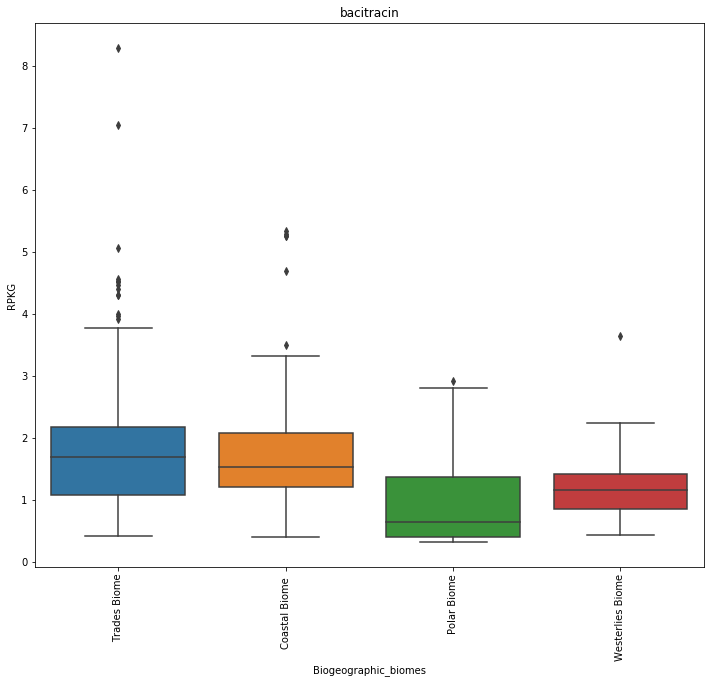

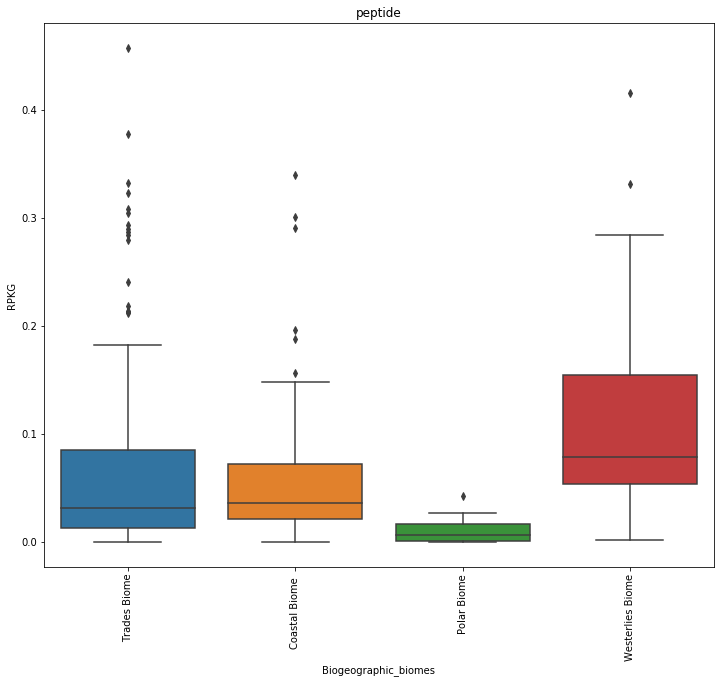

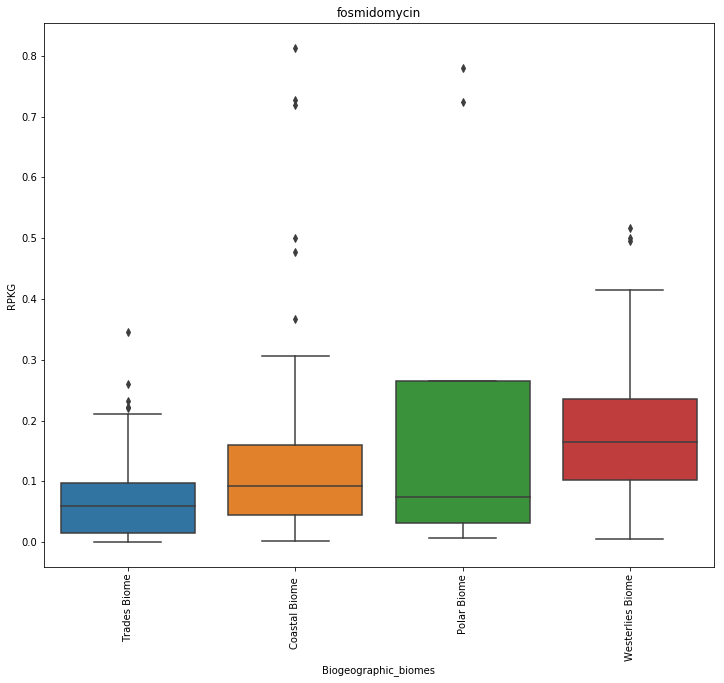

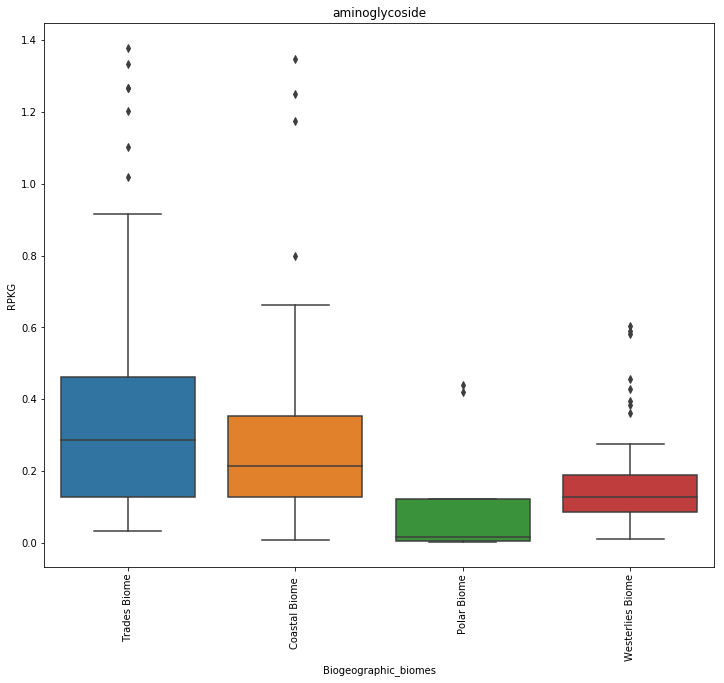

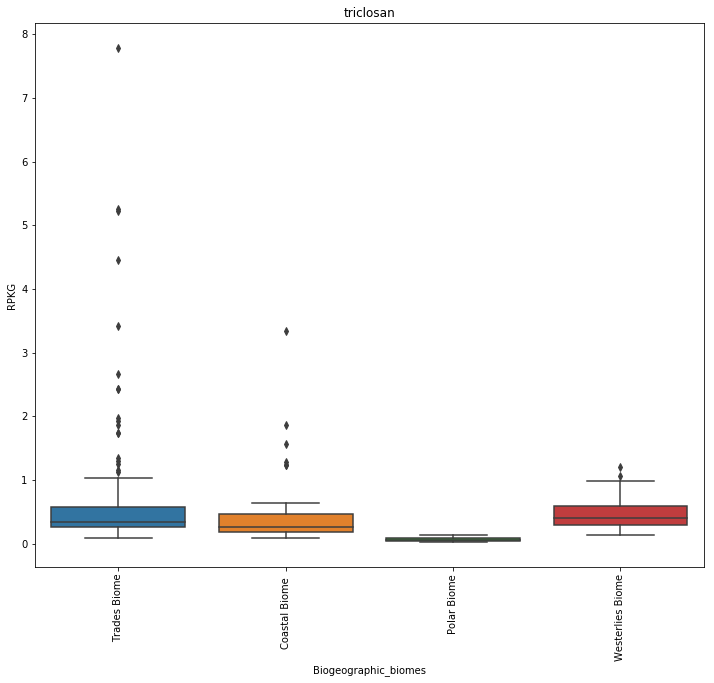

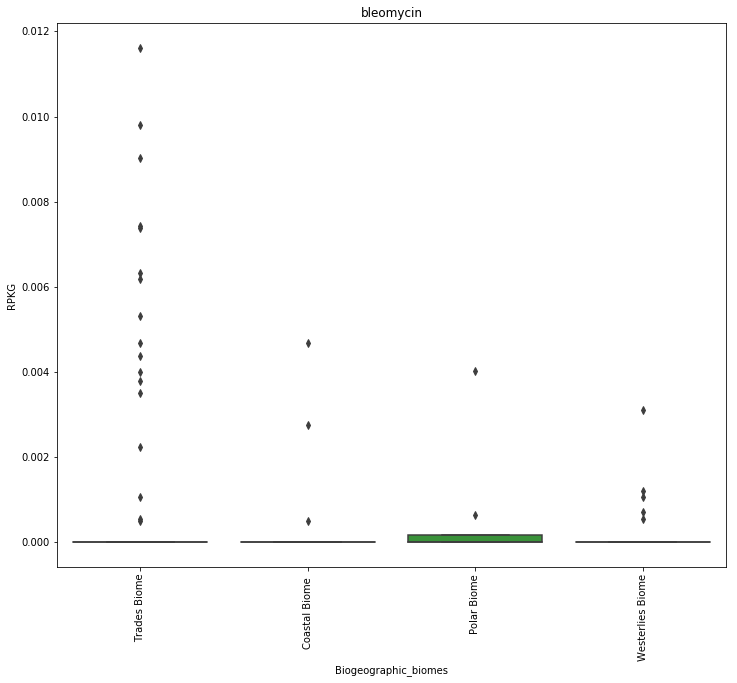

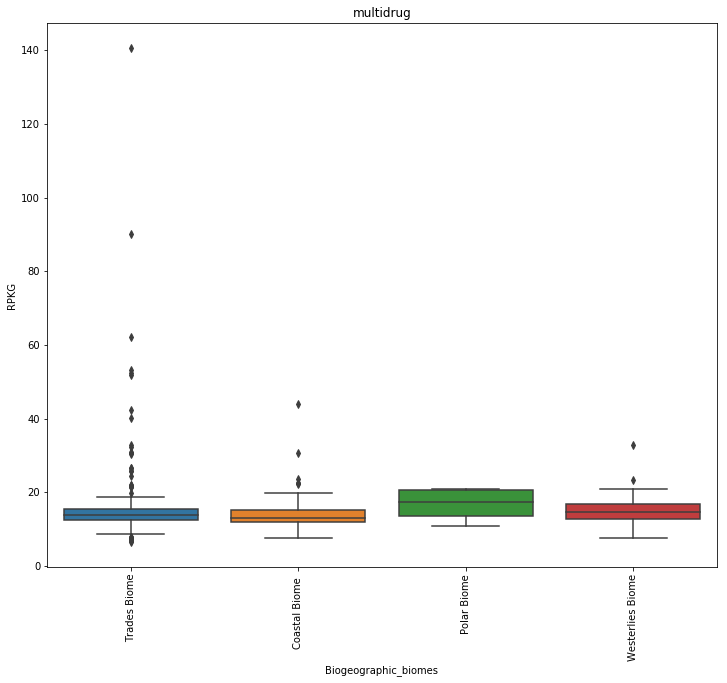

In [48]:
env=['Marine_provinces', 'Environmental_Feature', 'Ocean_sea_regions', 'fraction', 'Biogeographic_biomes']
for e in env:
    #pdf = matplotlib.backends.backend_pdf.PdfPages(out+"boxplots_RPKG_"+e +".pdf")
    for c in classes:
        fig=plt.figure(figsize=(12,10))
        sns.boxplot(class_RPKG[e],class_RPKG[c])
        plt.xticks(rotation=90)
        plt.ylabel("RPKG")
        plt.title(c)
        #pdf.savefig( fig )
        plt.show()
    #pdf.close()
    plt.close()

/home/rcuadrat/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


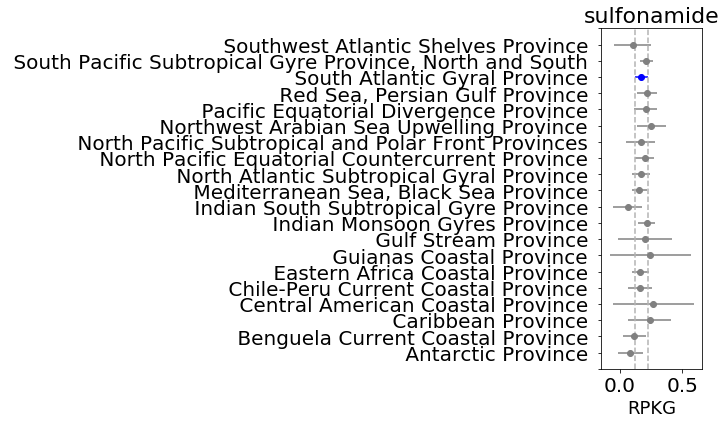

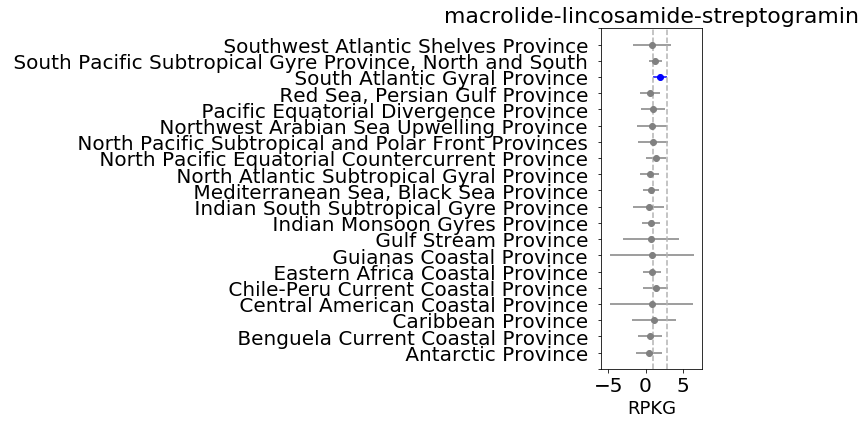

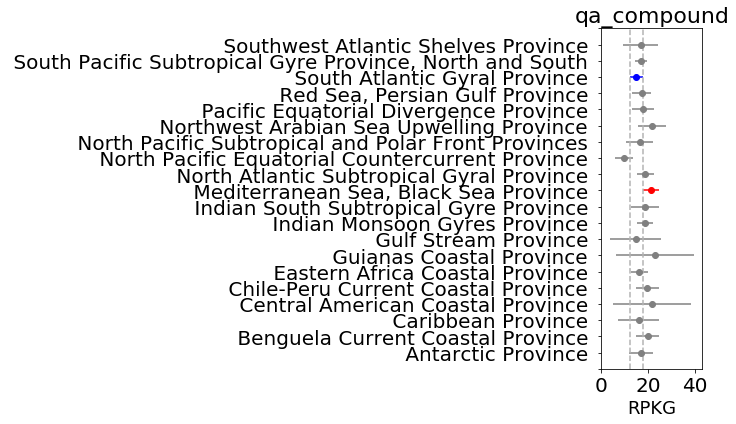

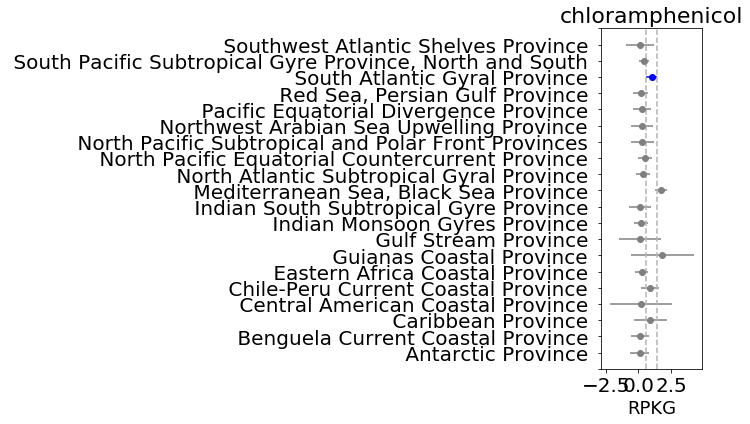

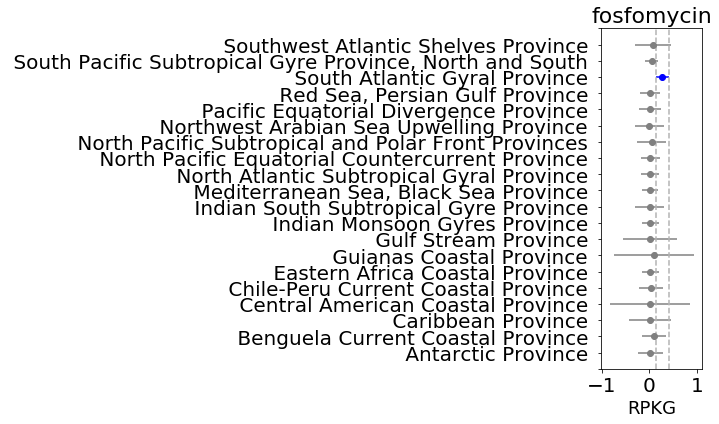

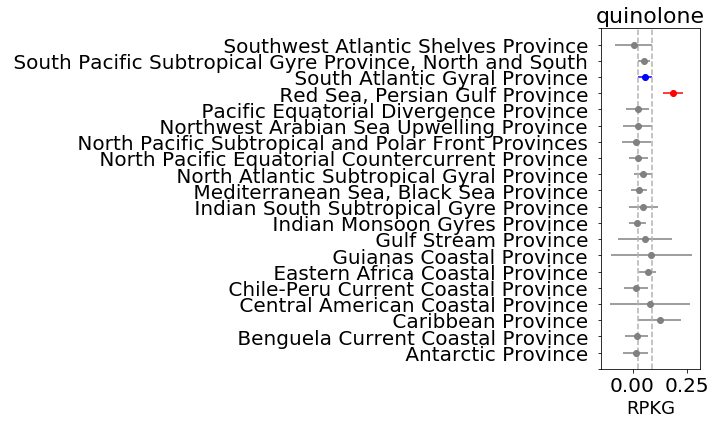

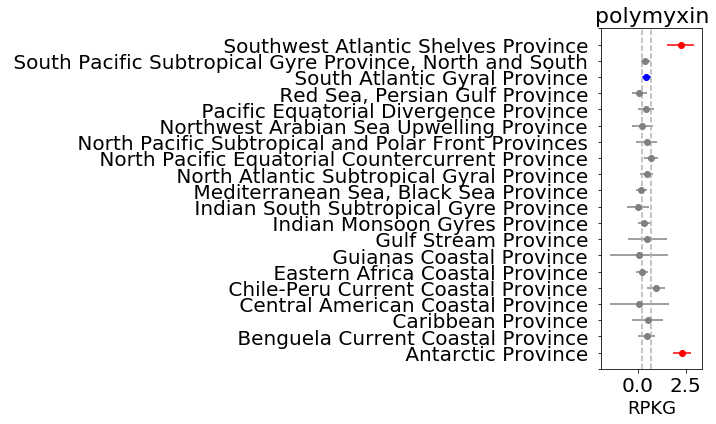

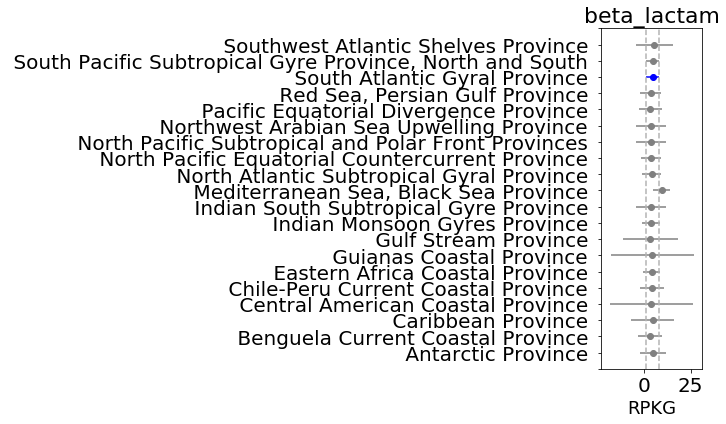

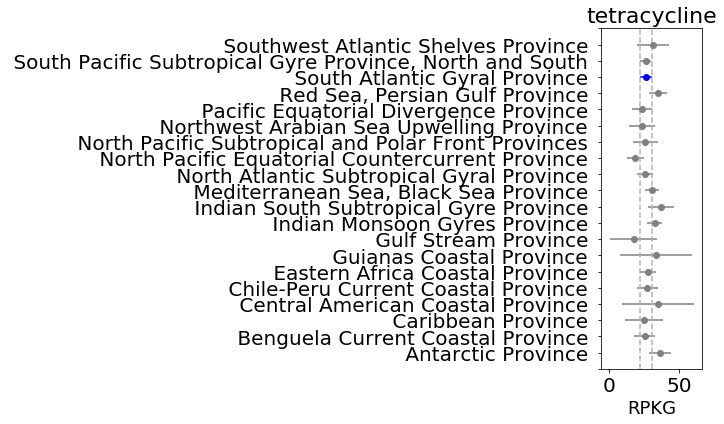

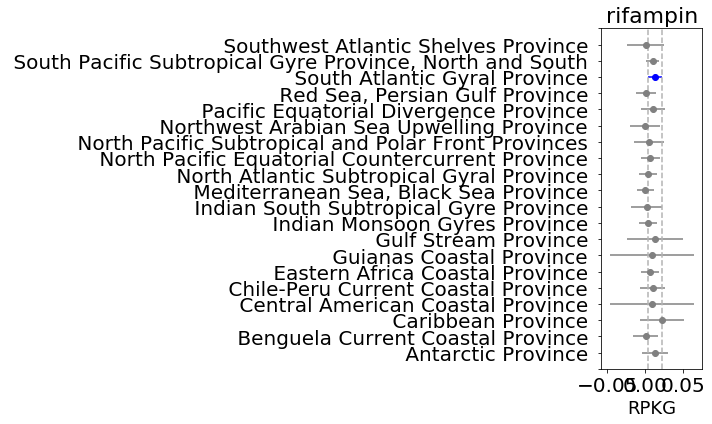

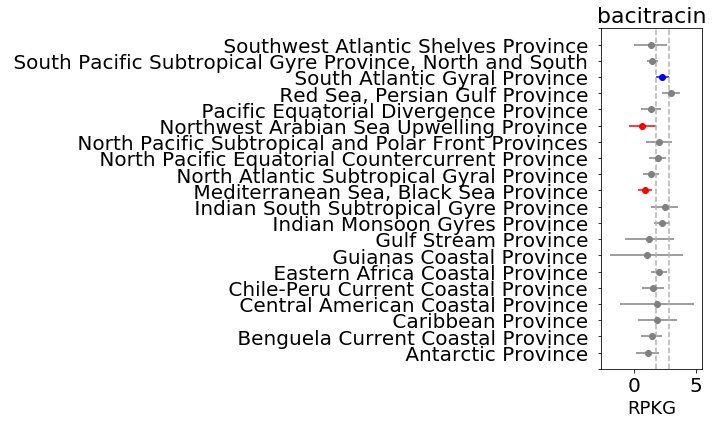

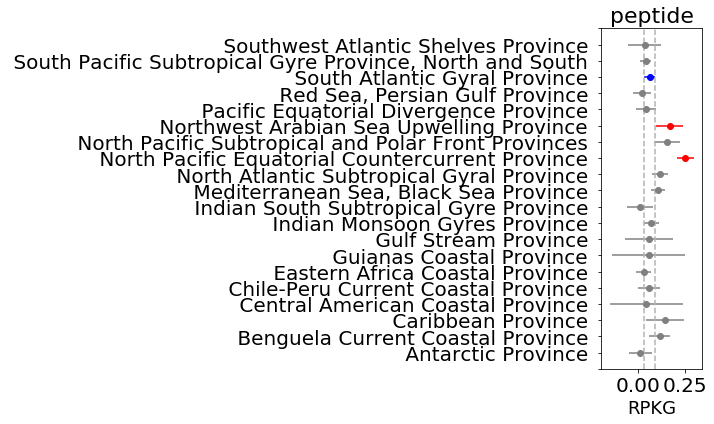

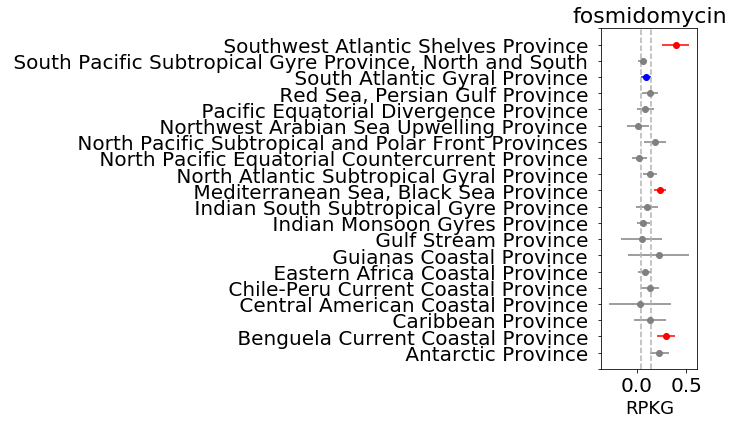

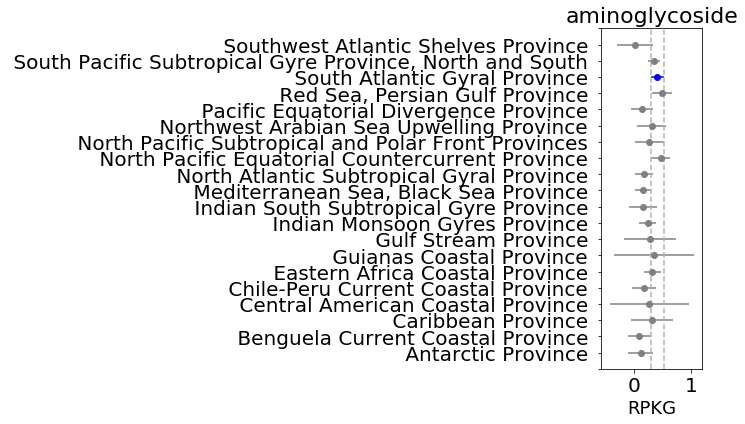

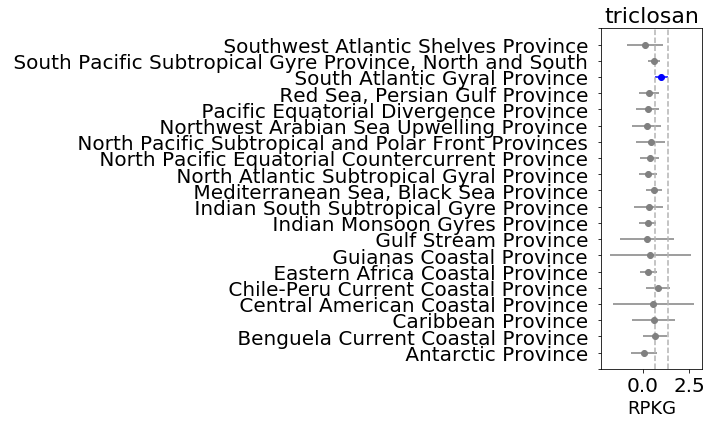

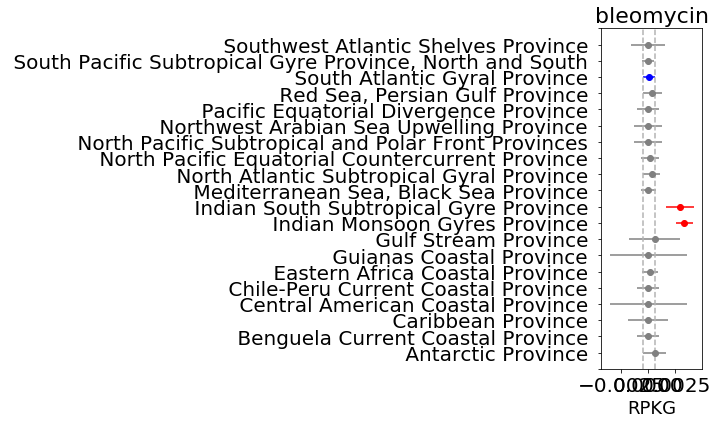

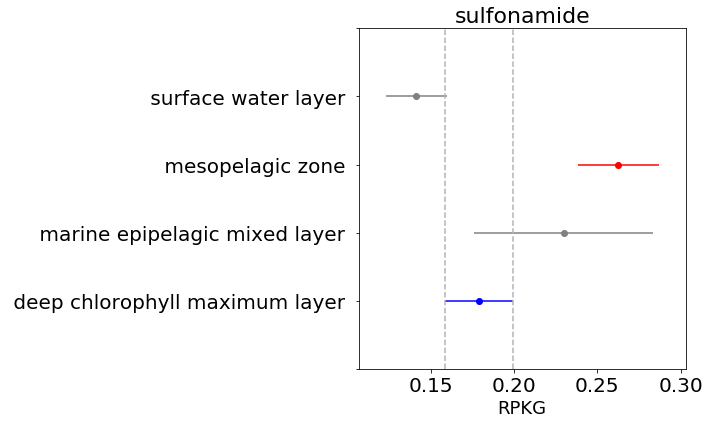

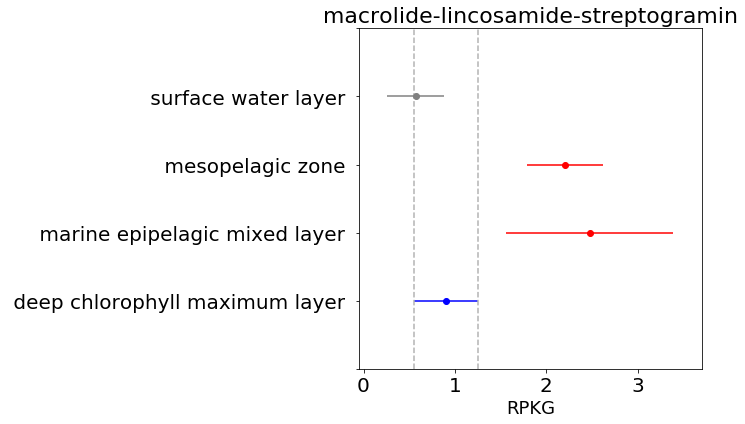

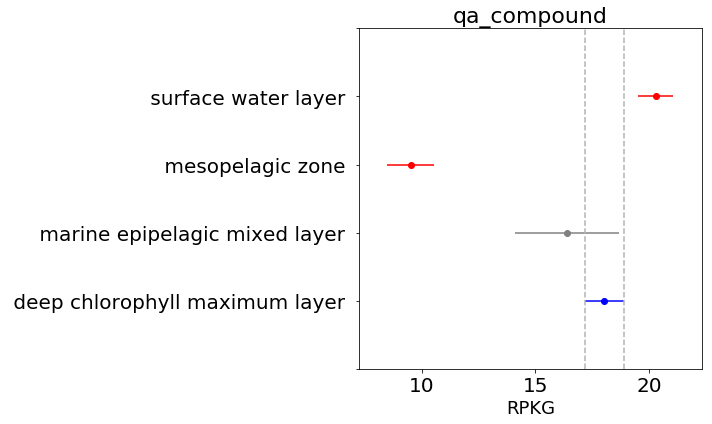

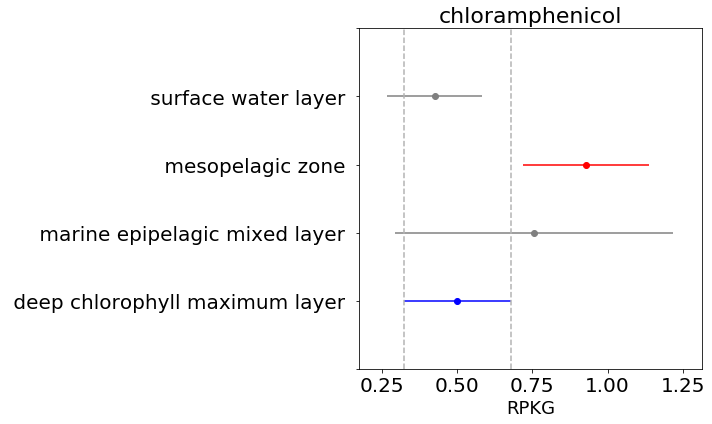

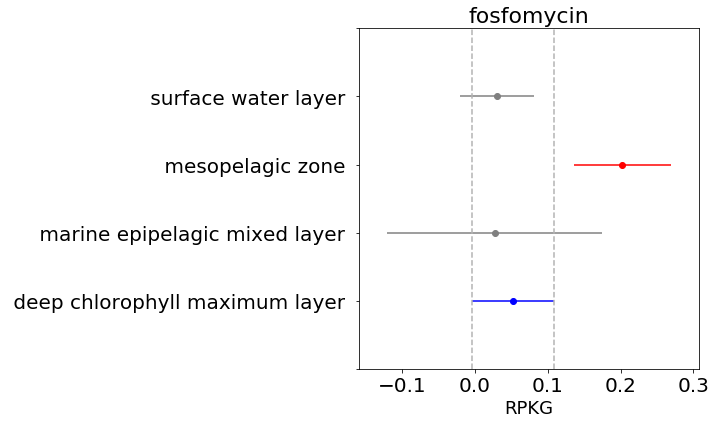

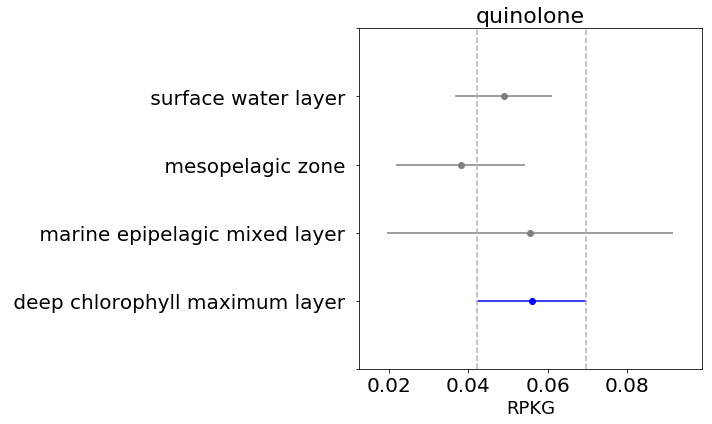

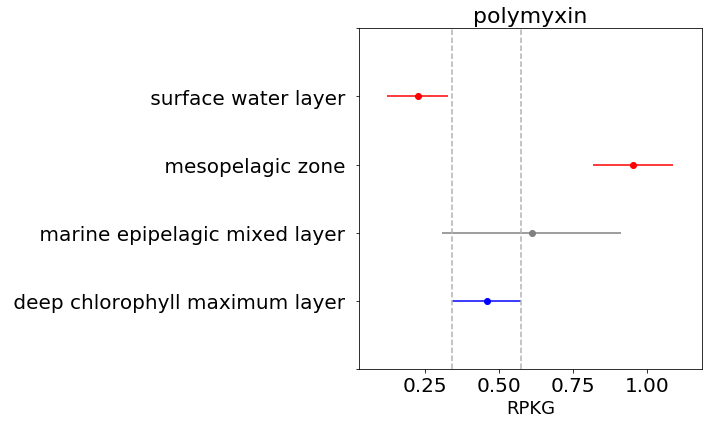

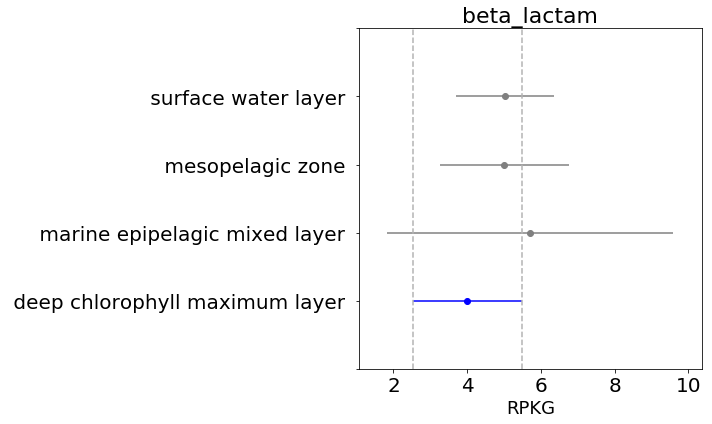

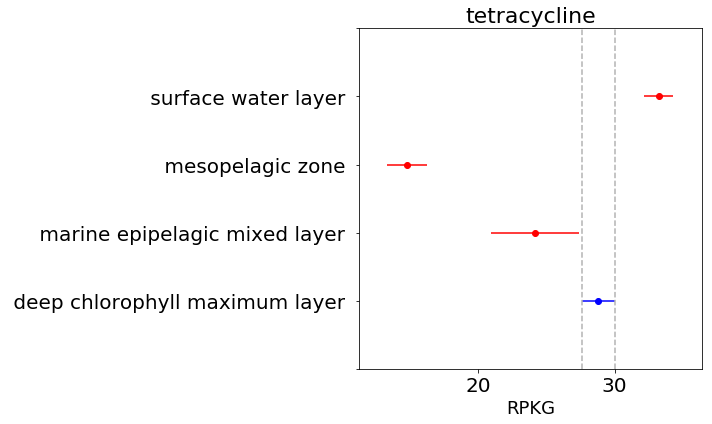

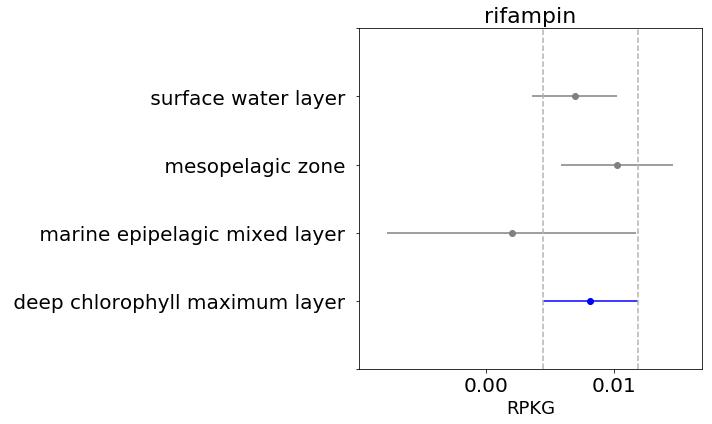

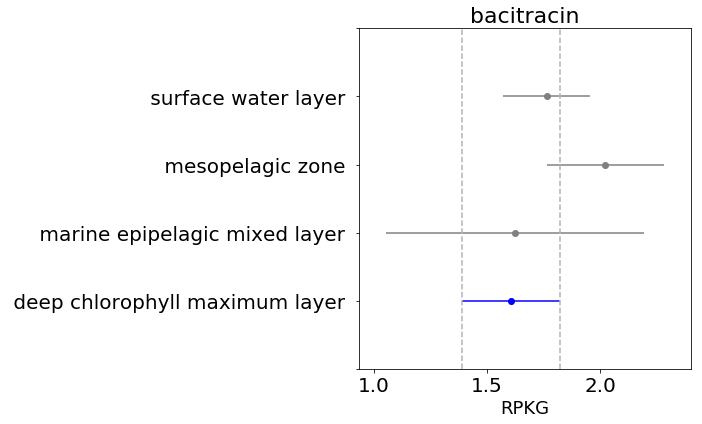

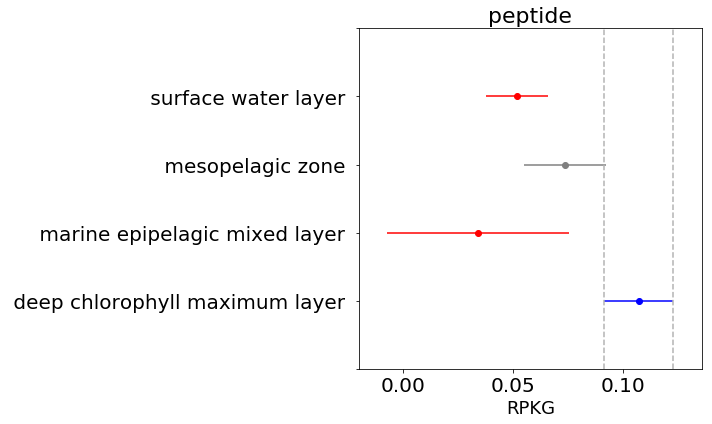

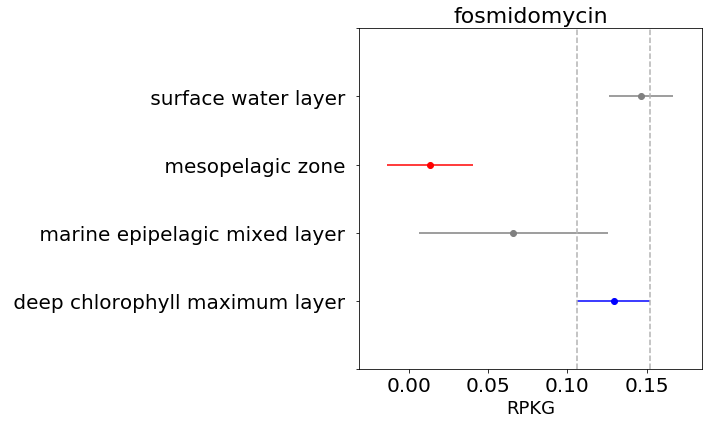

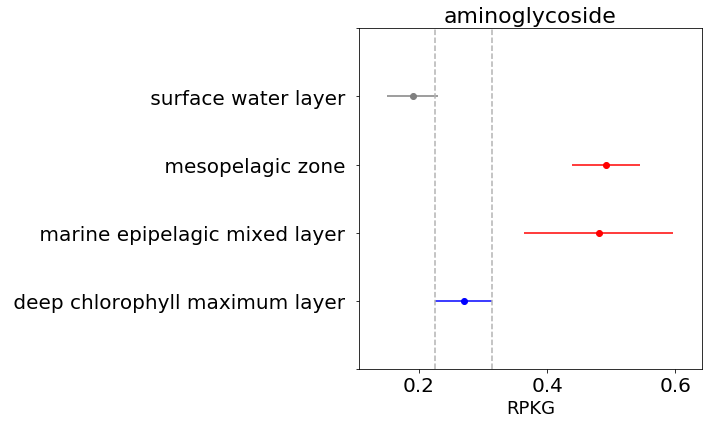

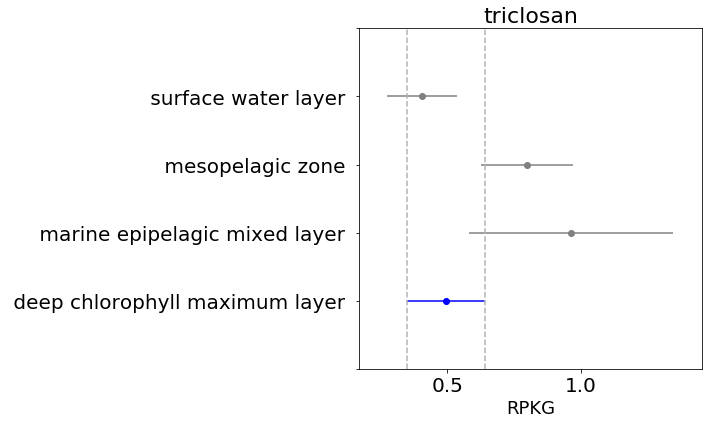

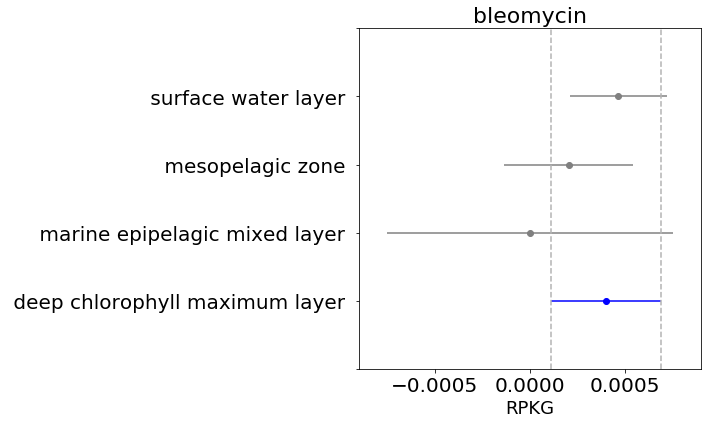

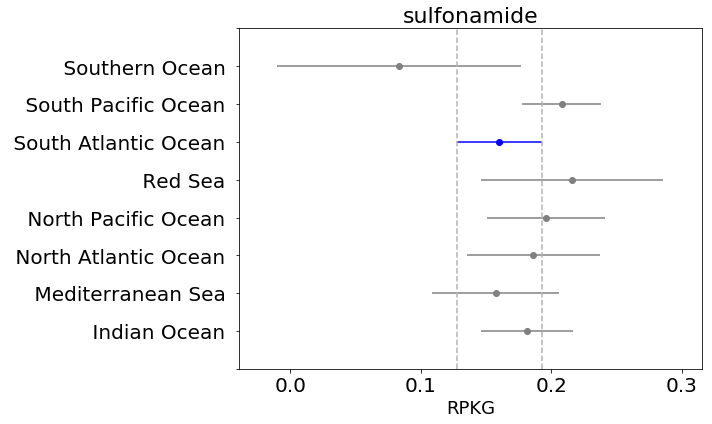

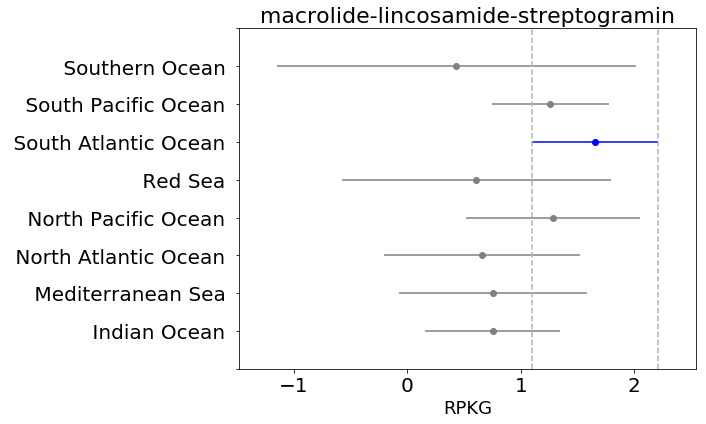

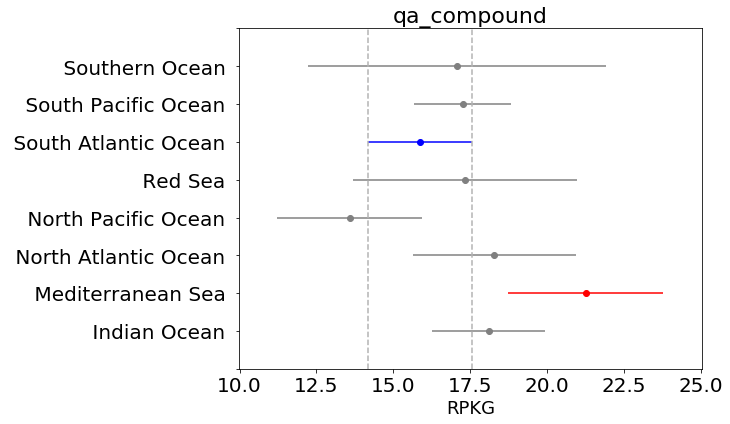

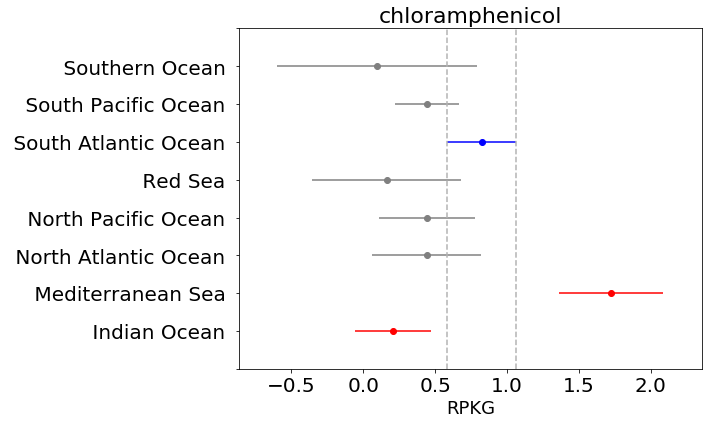

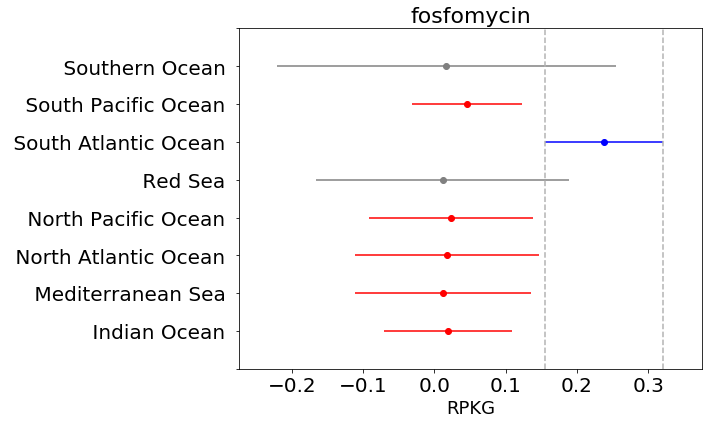

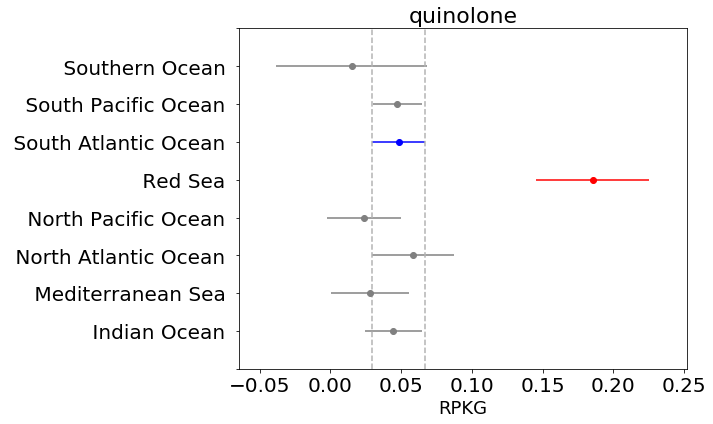

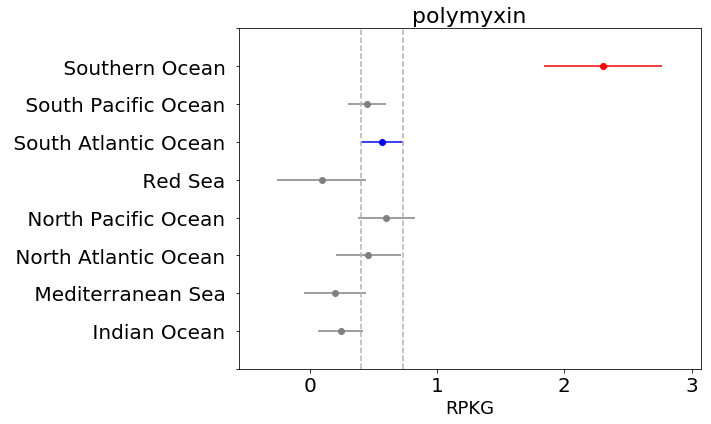

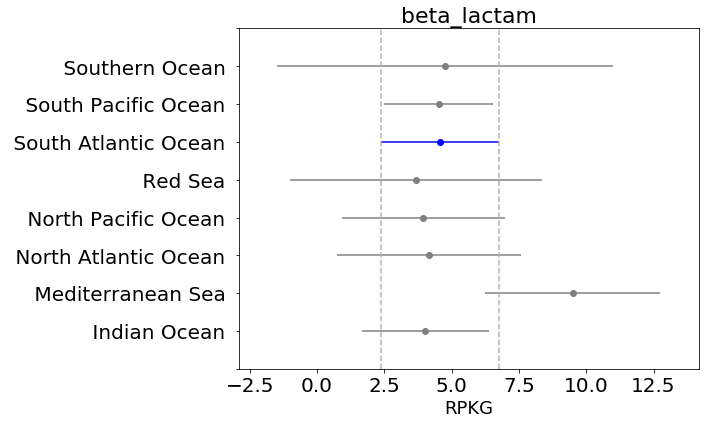

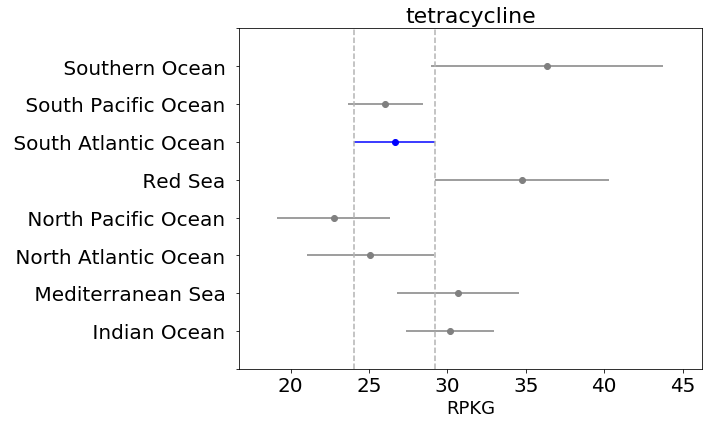

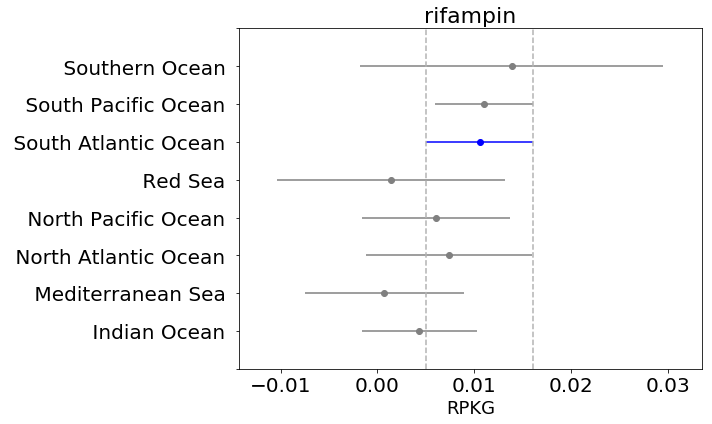

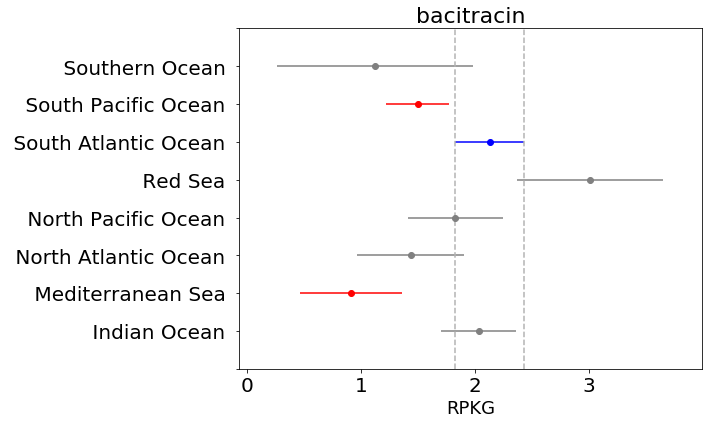

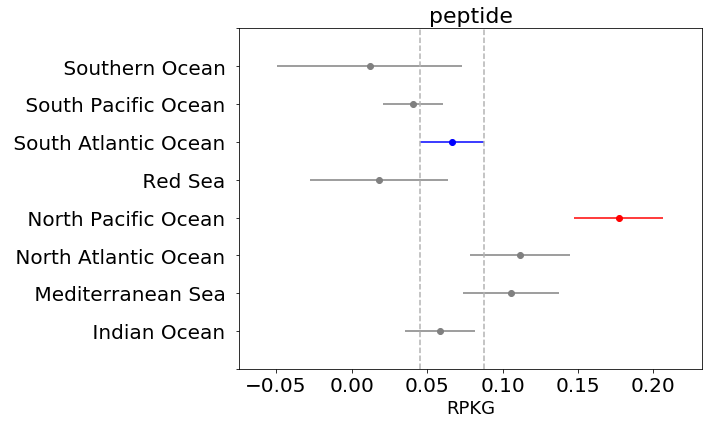

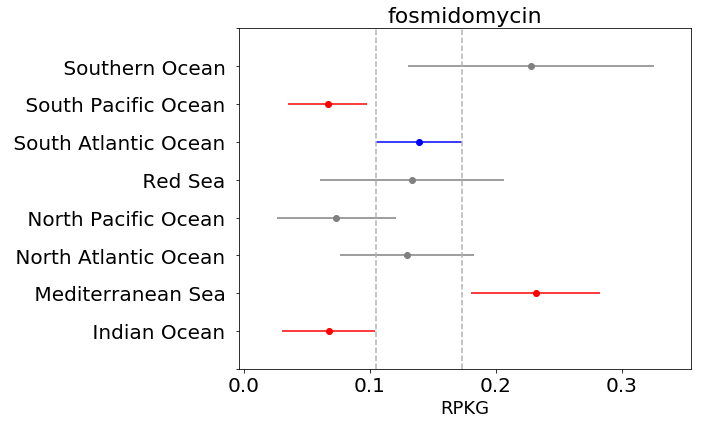

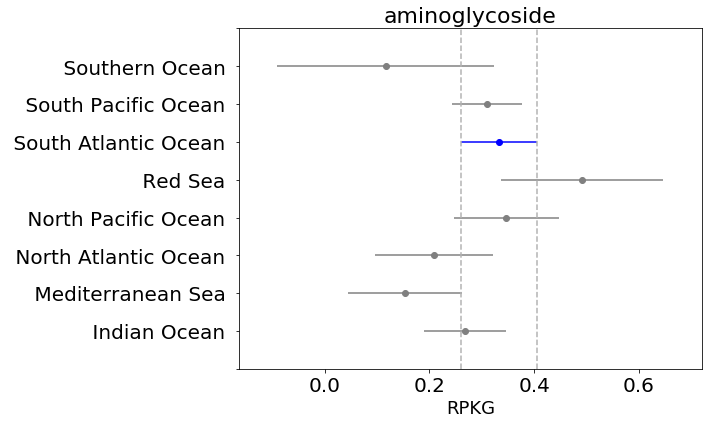

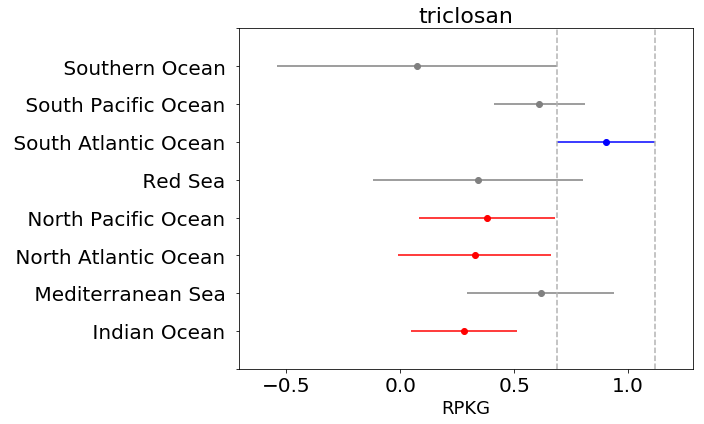

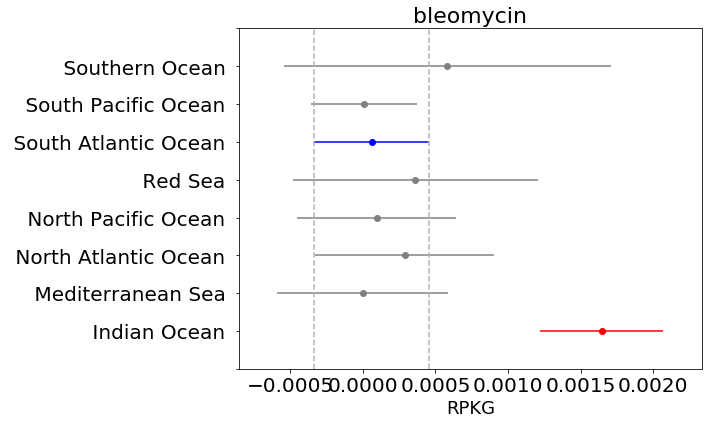

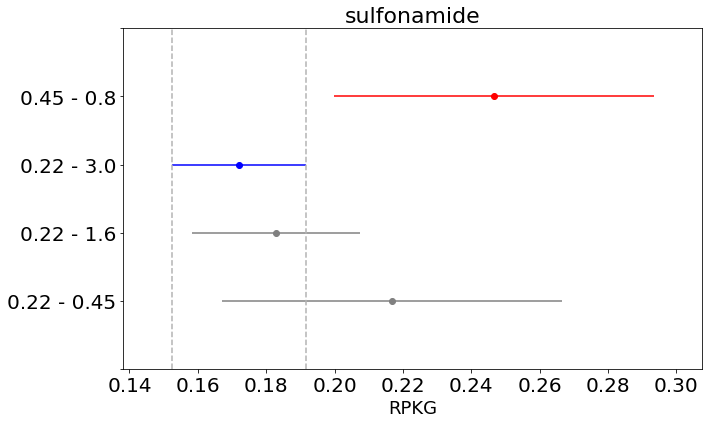

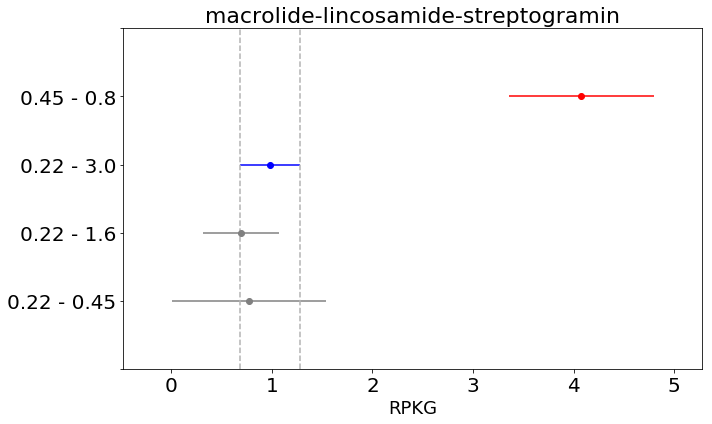

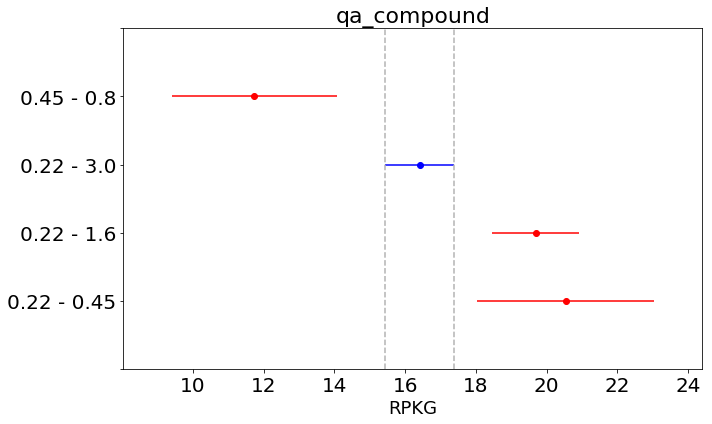

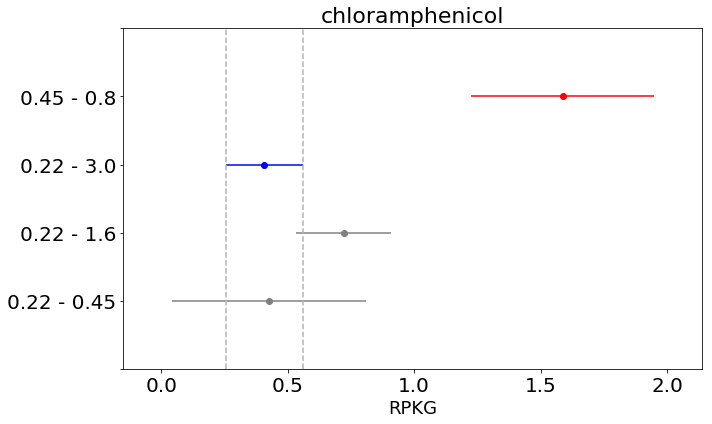

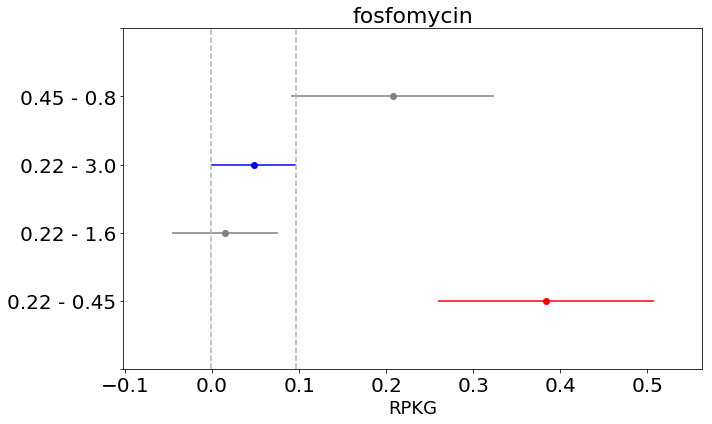

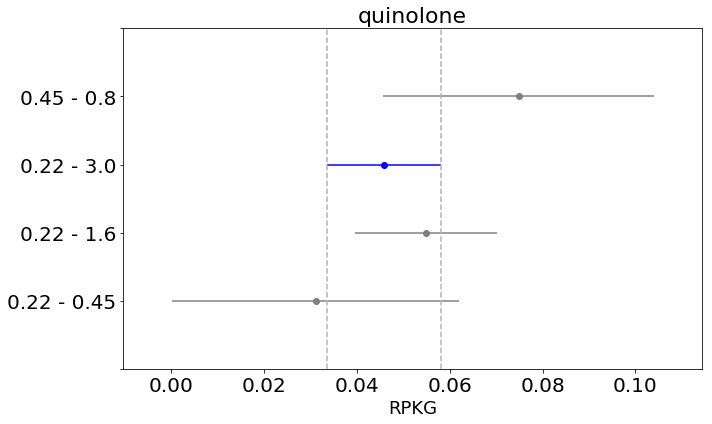

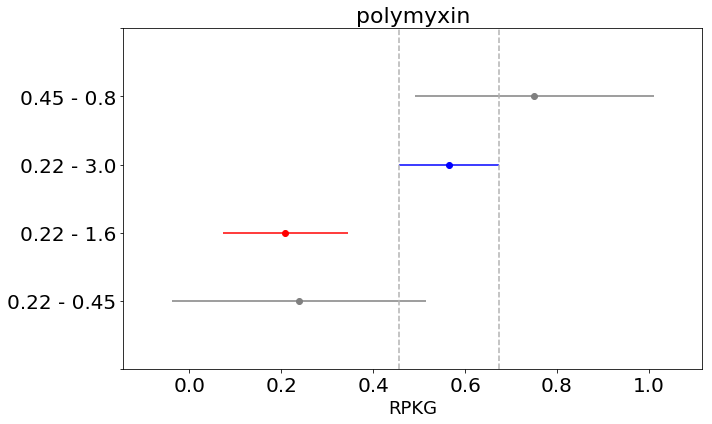

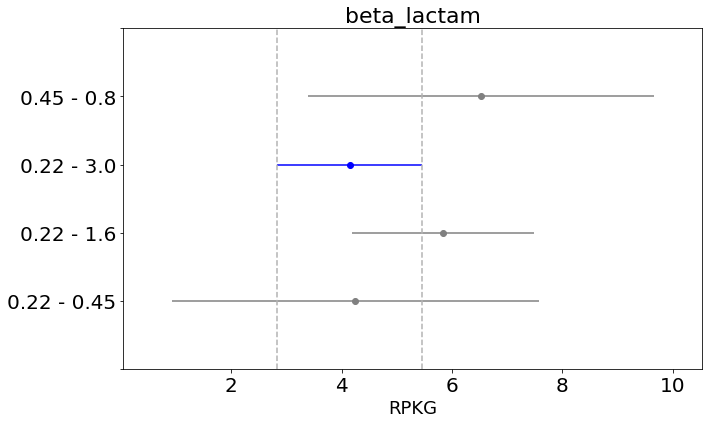

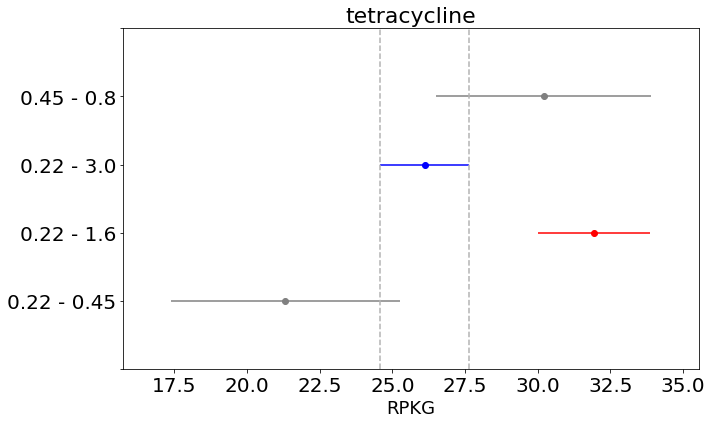

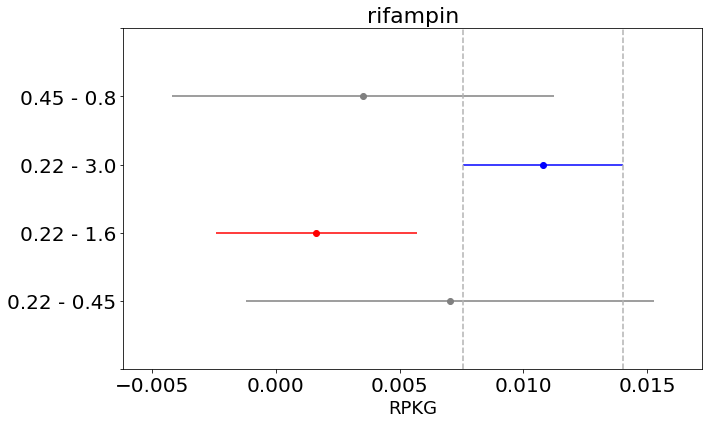

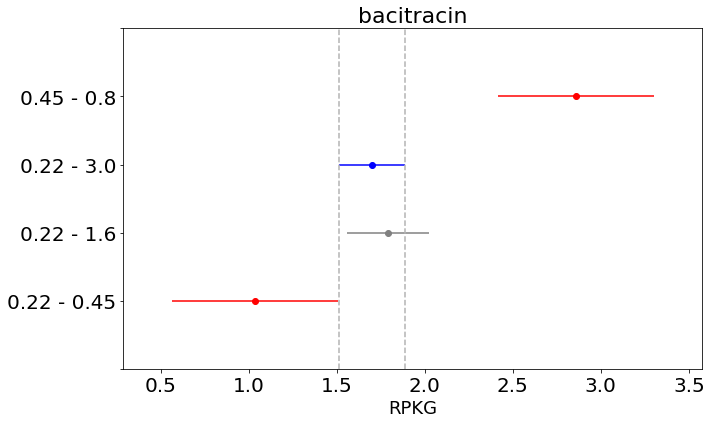

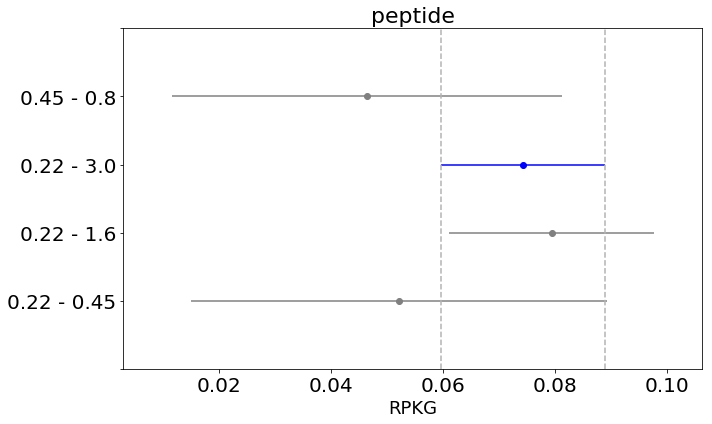

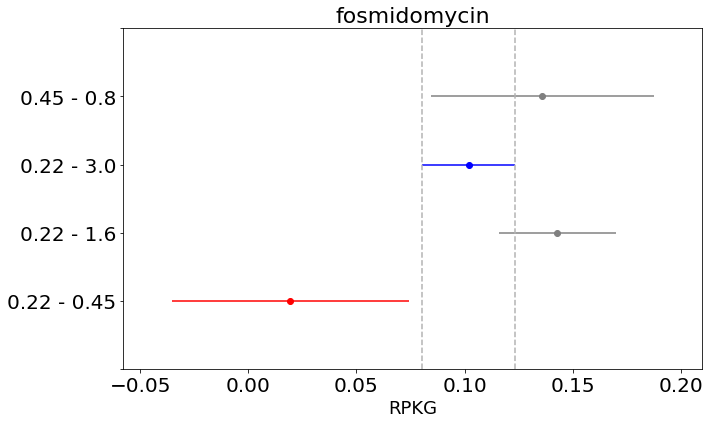

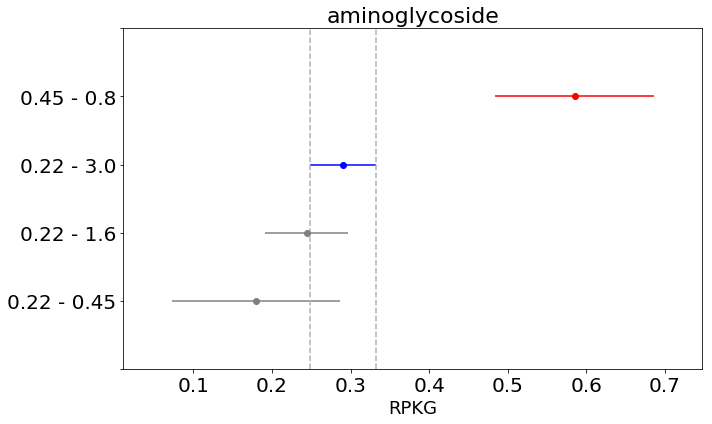

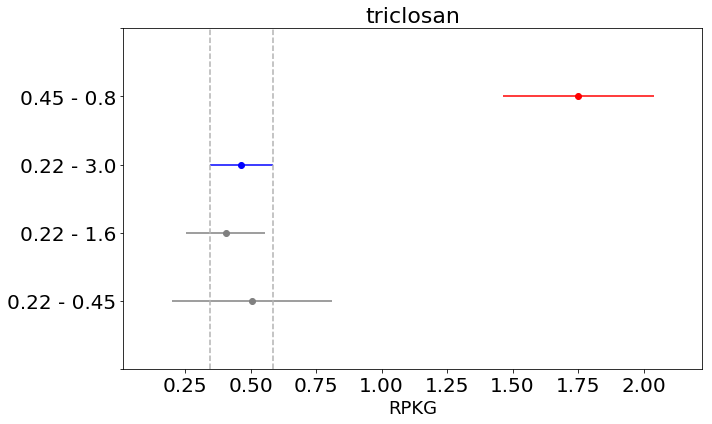

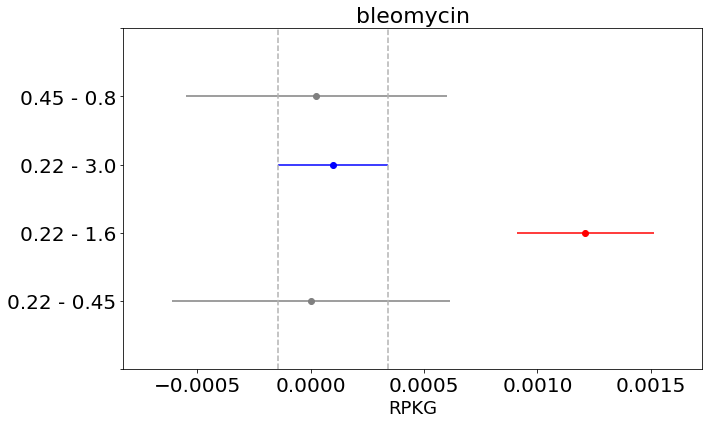

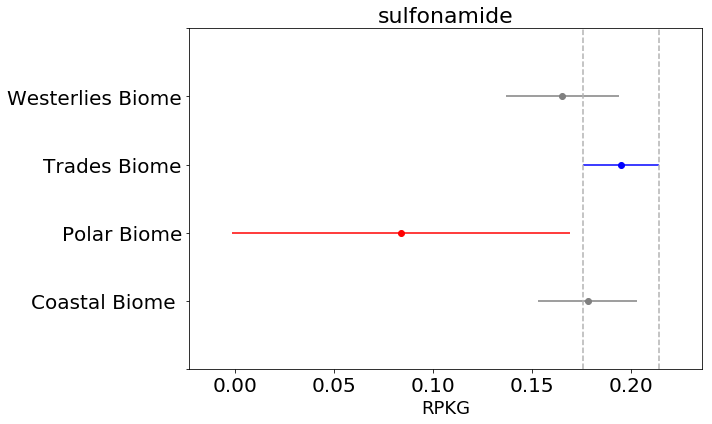

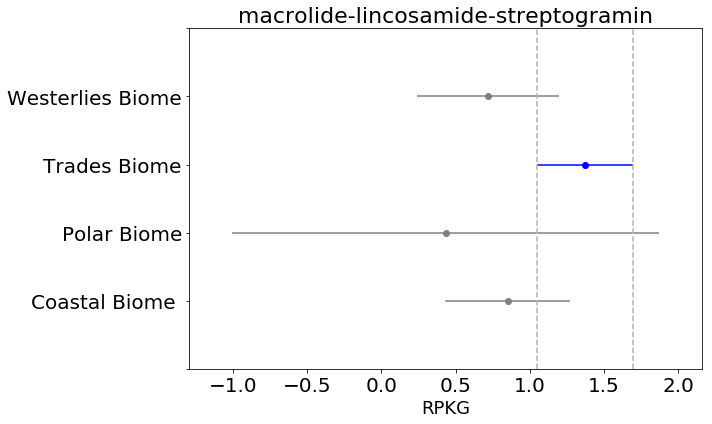

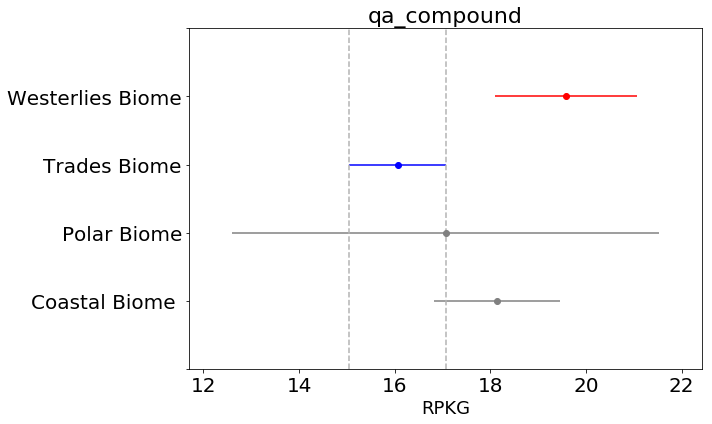

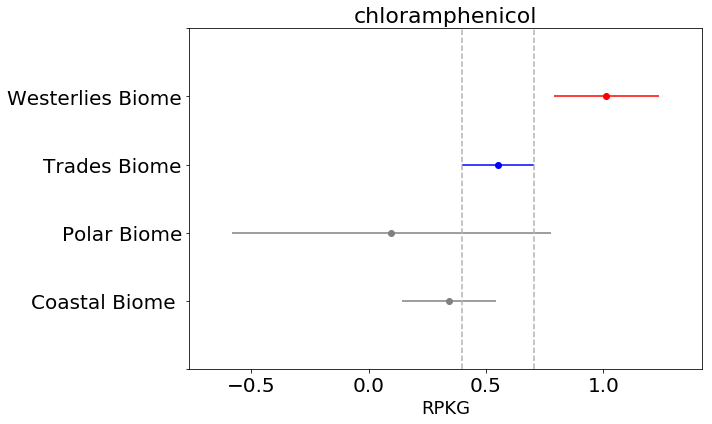

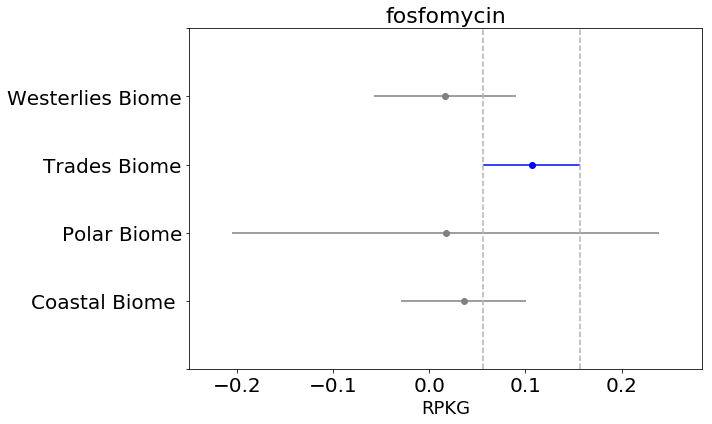

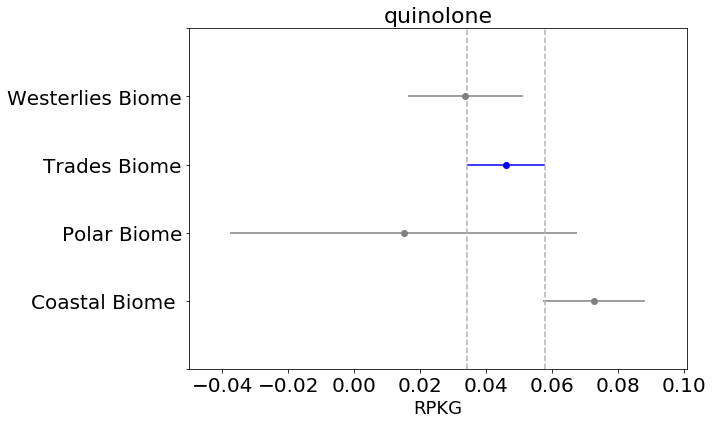

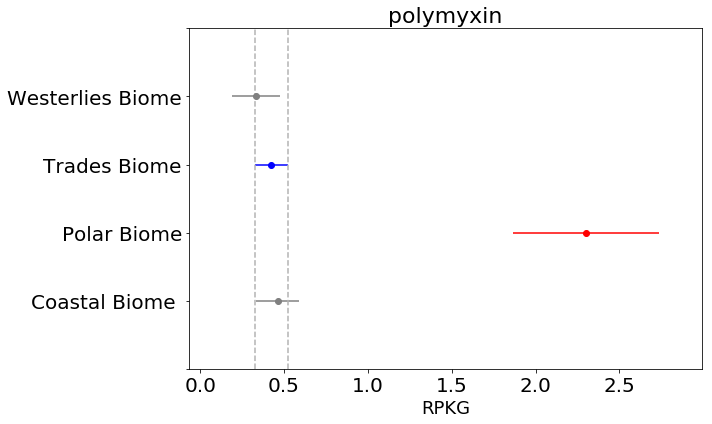

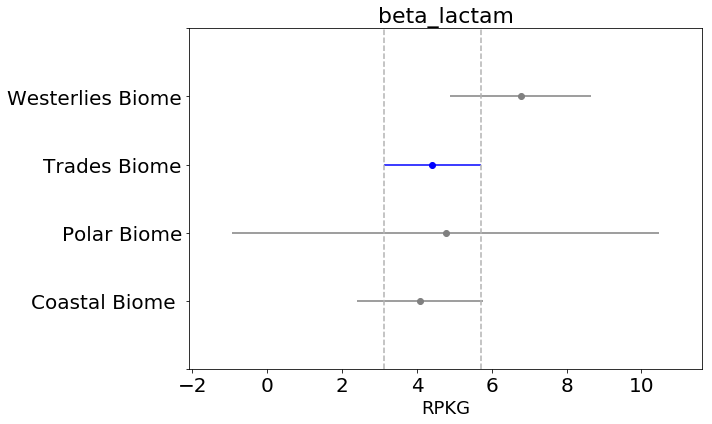

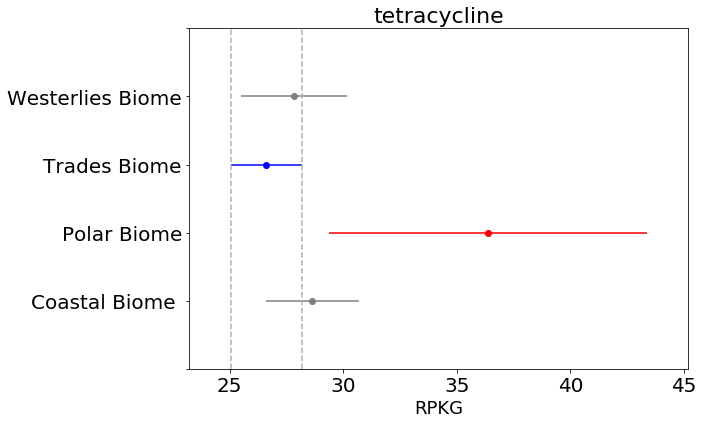

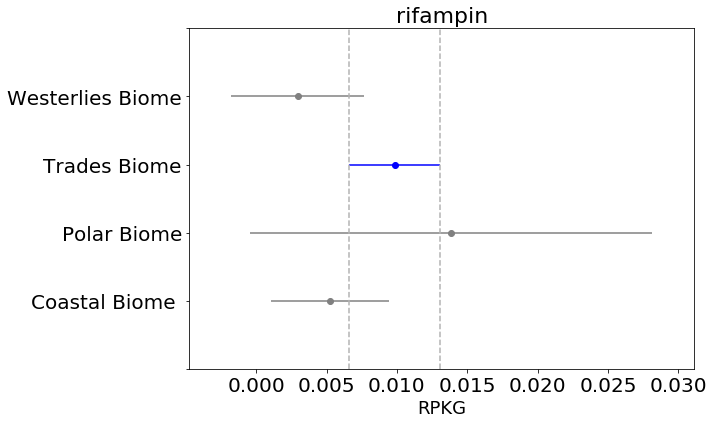

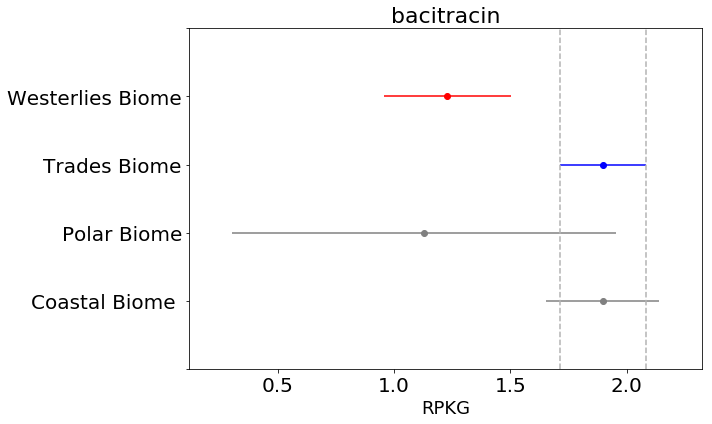

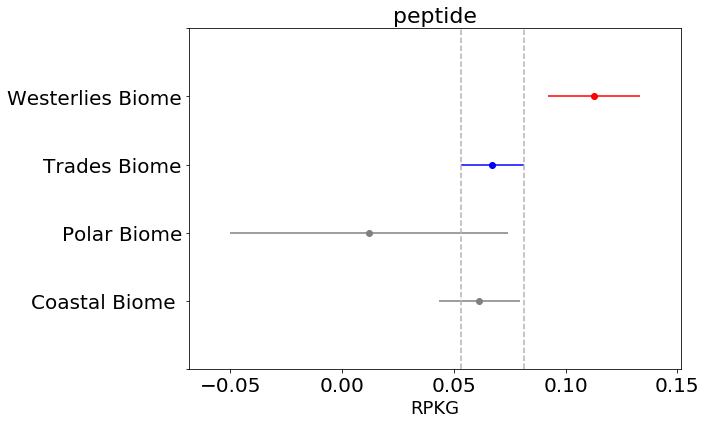

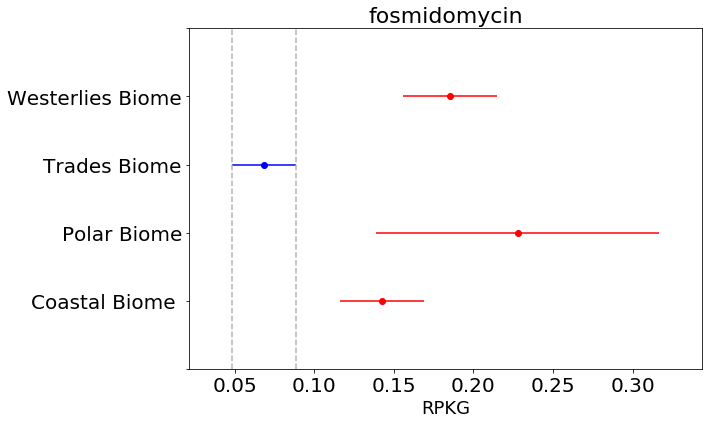

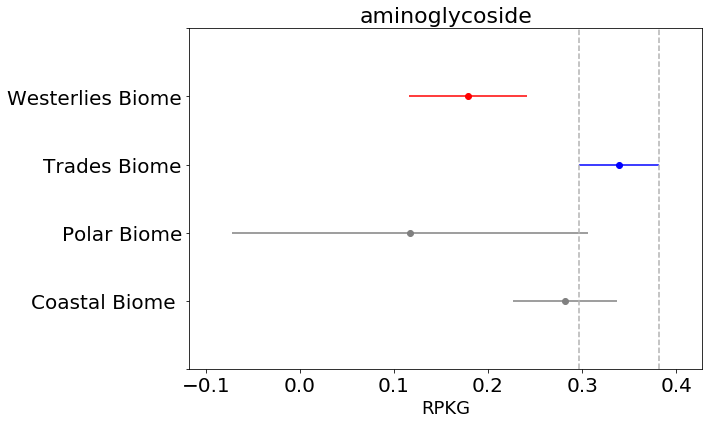

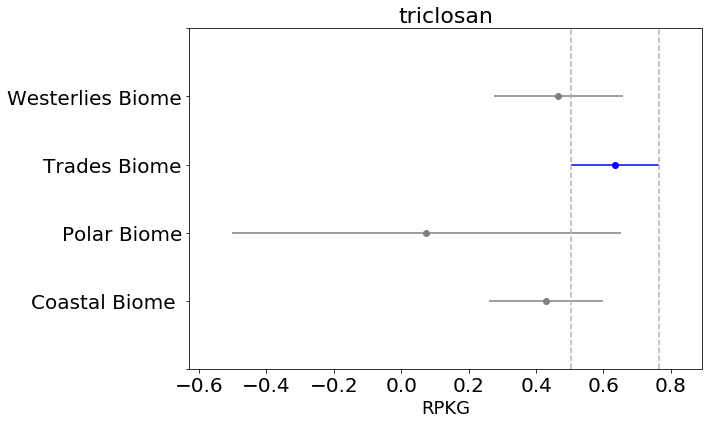

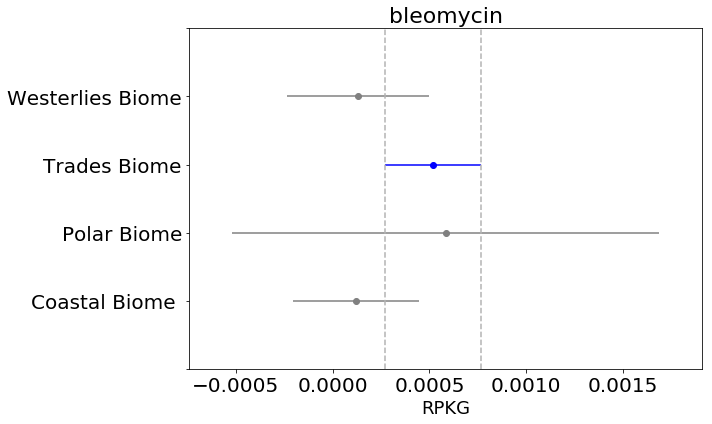

In [49]:
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

for e in env:
    #pdf = matplotlib.backends.backend_pdf.PdfPages(out+"tukey_class_RPKG_"+e +".pdf")

    all_c=pd.DataFrame()
    for c in classes:
        #print c

        tukey = pairwise_tukeyhsd(endog=class_RPKG[c],     # Data
                                  groups=class_RPKG[e],   # Groups
                                  alpha=0.05)          # Significance level

        fig=tukey.plot_simultaneous(comparison_name=class_RPKG[e][1],xlabel="RPKG")    # Plot group confidence intervals
        plt.title(c,size=22)
        plt.xlabel("RPKG",fontsize=18)

        plt.tight_layout()
        #pdf.savefig( fig )
        #plt.show()
        df=tukey.summary()
        res=pd.DataFrame(df.data[1:],columns=df.data[0])
        res["class"]=str(c)
        res["env"]=str(e)
        all_c=pd.concat([all_c,res])
        #all_c.to_excel(out+"/tukey_class_tests_FPKM_" +e +".xlsx",index=None)
        
    #pdf.close()
    plt.close()

In [50]:
all_c.head()

group1            group2  meandiff   p-adj   lower   upper  reject  \
0  Coastal Biome   Polar Biome      -0.0943    0.1235 -0.2046  0.0160  False    
1  Coastal Biome   Trades Biome      0.0169    0.7117 -0.0259  0.0597  False    
2  Coastal Biome   Westerlies Biome -0.0127    0.9000 -0.0680  0.0425  False    
3  Polar Biome     Trades Biome      0.1112    0.0372  0.0046  0.2179  True     
4  Polar Biome     Westerlies Biome  0.0816    0.2398 -0.0307  0.1938  False    

         class                   env  
0  sulfonamide  Biogeographic_biomes  
1  sulfonamide  Biogeographic_biomes  
2  sulfonamide  Biogeographic_biomes  
3  sulfonamide  Biogeographic_biomes  
4  sulfonamide  Biogeographic_biomes

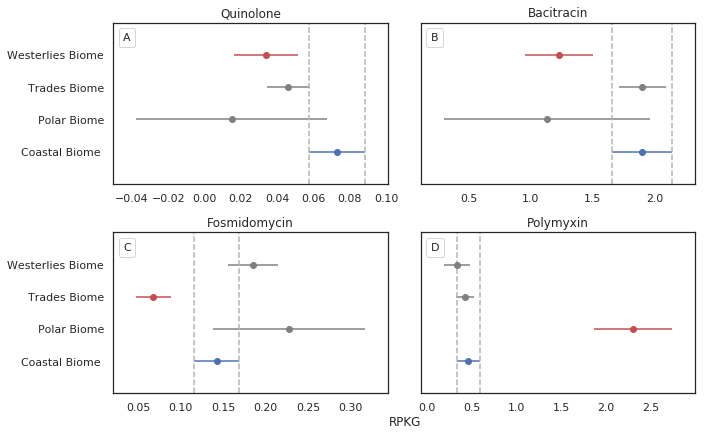

In [181]:
fig, ax =plt.subplots(2,2,figsize=(25, 25),sharey=True)

sns.set(style="white")


tukey = pairwise_tukeyhsd(endog=class_RPKG["quinolone"],     # Data
                                  groups=class_RPKG["Biogeographic_biomes"],   # Groups
                                  alpha=0.05)          # Significance level

fig=tukey.plot_simultaneous(comparison_name=class_RPKG["Biogeographic_biomes"][9],ax=ax[0,0])    # Plot group confidence intervals
ax[0,0].set_title("Quinolone")
#ax[0,0].text(0.01,0.1,"A",ha='center', va='bottom')


ax[0,0].legend('A',numpoints=None, loc=2,handlelength=0, handletextpad=0) 

tukey = pairwise_tukeyhsd(endog=class_RPKG["bacitracin"],     # Data
                                  groups=class_RPKG["Biogeographic_biomes"],   # Groups
                                  alpha=0.05)          # Significance level

fig=tukey.plot_simultaneous(comparison_name=class_RPKG["Biogeographic_biomes"][9],ax=ax[0,1],xlabel=None)    # Plot group confidence intervals
ax[0,1].set_title("Bacitracin")
ax[0,1].legend('B',numpoints=None, loc=2,handlelength=0, handletextpad=0) 


tukey = pairwise_tukeyhsd(endog=class_RPKG["fosmidomycin"],     # Data
                                  groups=class_RPKG["Biogeographic_biomes"],   # Groups
                                  alpha=0.05)          # Significance level

fig=tukey.plot_simultaneous(comparison_name=class_RPKG["Biogeographic_biomes"][9],ax=ax[1,0],xlabel=None)    # Plot group confidence intervals
ax[1,0].set_title("Fosmidomycin")

ax[1,0].legend('C',numpoints=None, loc=2,handlelength=0, handletextpad=0) 


tukey = pairwise_tukeyhsd(endog=class_RPKG["polymyxin"],     # Data
                                  groups=class_RPKG["Biogeographic_biomes"],   # Groups
                                  alpha=0.05)          # Significance level

fig=tukey.plot_simultaneous(comparison_name=class_RPKG["Biogeographic_biomes"][9],ax=ax[1,1],xlabel=None)    # Plot group confidence intervals
ax[1,1].set_title("Polymyxin")

ax[1,1].legend('D',numpoints=None, loc=2,handlelength=0, handletextpad=0) 

#plt.xlabel("RPKG",fontsize=18)

fig.text(0.57, 0.0001, 'RPKG', ha='center')


plt.tight_layout()



plt.savefig("Figure_3.png",format="png",resolution="300dpi")
plt.savefig("Figure_3.svg",format="svg")
plt.savefig("Figure_3.eps",format="eps")
plt.show()

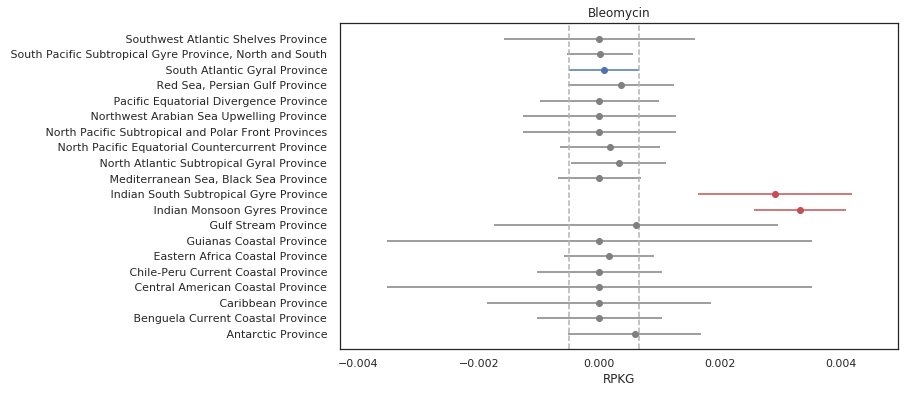

In [52]:
tukey = pairwise_tukeyhsd(endog=class_RPKG["bleomycin"],     # Data
                          groups=class_RPKG["Marine_provinces"],   # Groups
                          alpha=0.05)          # Significance level

fig=tukey.plot_simultaneous(comparison_name=class_RPKG["Marine_provinces"][1],xlabel="RPKG")    # Plot group confidence intervals
plt.title("Bleomycin")
plt.xlabel("RPKG")
plt.savefig("Figure_4.png",format="png",resolution="300dpi")
plt.savefig("Figure_4.svg",format="svg")
plt.savefig("Figure_4.eps",format="eps")

In [53]:
# Runing OLS generic model with all covariates

In [54]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

In [55]:
formula1="Marine_provinces + Environmental_Feature + Ocean_sea_regions + fraction + Biogeographic_biomes + Latitude + Longitude + NO2 +  PO4 + NO2NO3 + SI + miTAG_SILVA_Taxo_Richness + miTAG_SILVA_Phylo_Diversity + miTAG_SILVA_Chao + miTAG_SILVA_ace + miTAG_SILVA_Shannon + OG_Shannon + OG_Richness + OG_Evenness +         FC_heterotrophs_cells_mL + FC_autotrophs_cells_mL + FC_bacteria_cells_mL + FC_picoeukaryotes_cells_mL" 

/home/rcuadrat/.local/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
/home/rcuadrat/.local/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
/home/rcuadrat/.local/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
/home/rcuadrat/.local/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
/home/rcuadrat/.local/lib/python3.6/site-packages/statsmodels/base/m

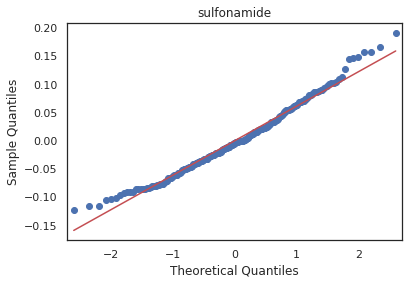

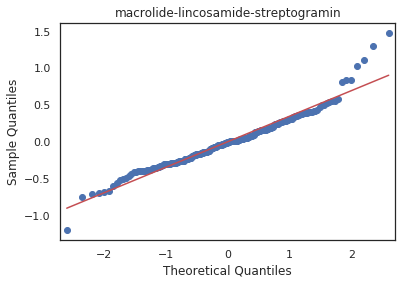

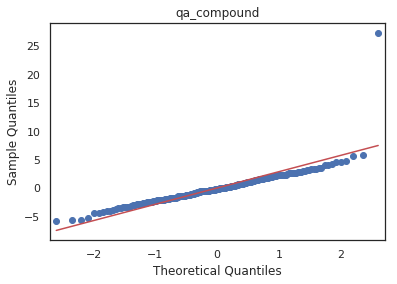

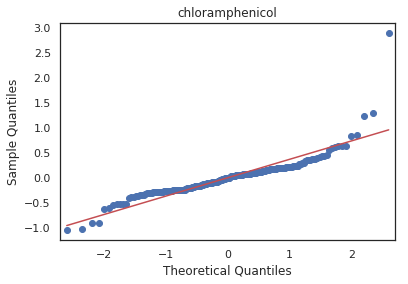

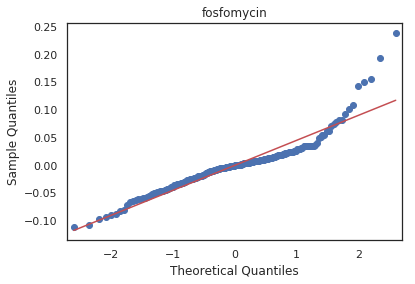

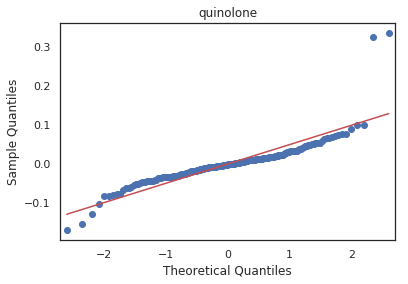

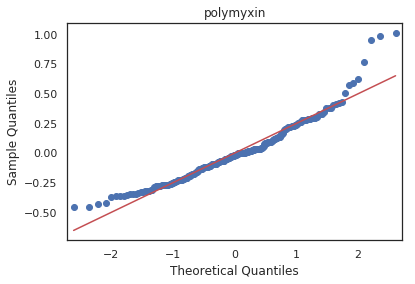

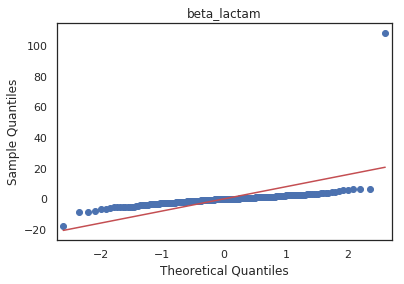

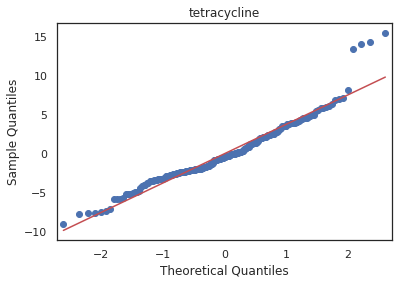

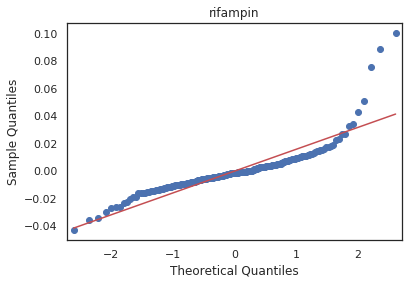

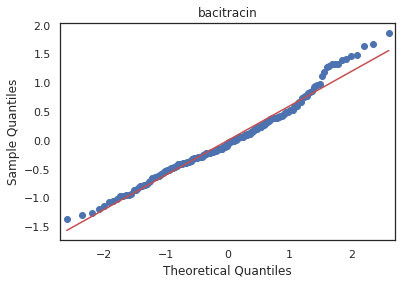

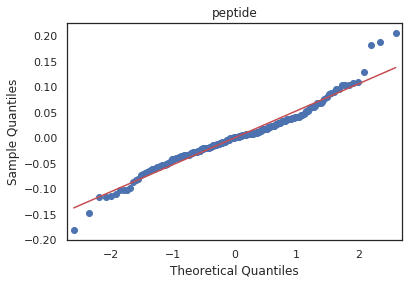

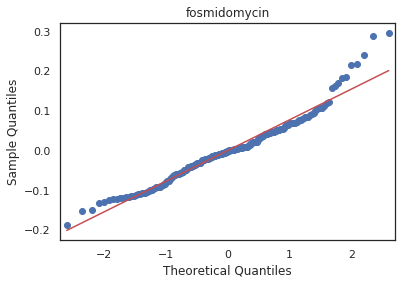

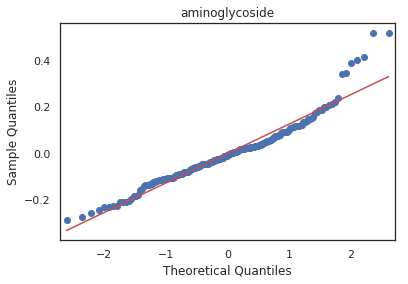

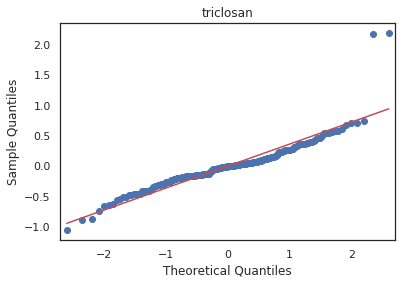

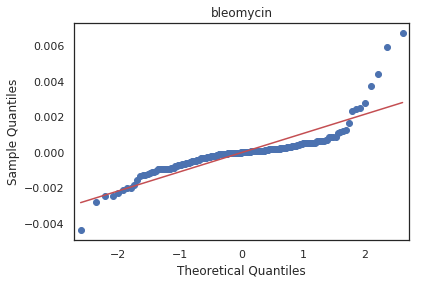

In [56]:
out="TSV/"
ols_df=class_RPKG

ols_df.rename(columns={"Latitude [degrees North]":"Latitude","Longitude [degrees East]":"Longitude",
                       "Date/Time [yyyy-mm-ddThh:mm]":"Data_Time","NO2NO3 [umol/L]**":"NO2NO3",
                       "NO2 [umol/L]**":"NO2","PO4 [umol/L]**":"PO4",
                       "SI [umol/L]**":"SI","FC - heterotrophs [cells/mL]":"FC_heterotrophs_cells.mL",
                      "FC - autotrophs [cells/mL]":"FC_autotrophs_cells.mL","FC - bacteria [cells/mL]":"FC_bacteria_cells.mL",
                      "FC - picoeukaryotes [cells/mL]":"FC_picoeukaryotes_cells.mL"},inplace=True)
#ols_df.drop("run_id",axis=1,inplace=True)

#'Date/Time [yyyy-mm-ddThh:mm]'
ols_df.columns=ols_df.columns.str.replace(r".", "_").str.replace(r"-", "_").str.replace(r" ", "_").str.replace(r":", "_").str.replace(r"*", "_").str.replace(r"[","_").str.replace(r"]","_")
par=list(ols_df.columns)
parameters=[x for x in par if x not in classes]
parameters.remove("macrolide_lincosamide_streptogramin")
#parameters.remove("multidrug_mutation")

# formula1="+".join(parameters)
# OLS with all the metadata 
reg3 = pd.DataFrame()
reg3_ = pd.DataFrame()
aov=pd.DataFrame()
# pdf = matplotlib.backends.backend_pdf.PdfPages(out+"models_aov.pdf")
# writer = pd.ExcelWriter(out+'aov_results.xlsx', engine='xlsxwriter')
# writer2 = pd.ExcelWriter(out+'aov_results_significant.xlsx', engine='xlsxwriter')
for c in classes:
    formula="%s ~ "%(c.replace(r"-", "_")) + formula1
    res = ols(formula, ols_df).fit()
    dfres={"coeficient":res.params,"p values":res.pvalues}
    ddd=pd.DataFrame(dfres)
    ddd["coeficient"]=ddd["coeficient"].apply(lambda x: "%.4f" % (x))
    ddd["variable"]=c.replace(r"-", "_")
    ddd["Formula"] = formula
    ddd["model p value"]=res.f_pvalue
    ddd["model Adjusted r squared"]=res.rsquared_adj
    ddd["r squared"]=res.rsquared
    #final result of OLS
    reg3=pd.concat([reg3,ddd],axis=0)
    
    reg3_ = reg3[(reg3["p values"] < 0.05) | (reg3["model p value"]< 0.05)] 
    reg3_["coeficient"]=reg3_["coeficient"].astype(float)
    reg3_ = reg3_.sort_values(by=["coeficient"],ascending=False)
    aov_table = anova_lm(res,typ=2)
    aov_table["classe"]=c
    
    eta_squared(aov_table)
    omega_squared(aov_table)
    #print(aov_table)
    aov_sig=aov_table[aov_table["PR(>F)"]<0.05]
    
    #aov_table.to_excel(writer, sheet_name=c[0:30])
    #aov_sig.to_excel(writer2, sheet_name=c[0:30])

    aov=pd.concat([aov,aov_table],axis=0)

    res_ = res.resid 
    fig = sm.qqplot(res_, line='s')
    plt.title(c)
    #pdf.savefig( fig )
    
plt.close()
# pdf.close()
# writer.save()
# writer2.save()

In [72]:
ARGS_RPKG_fornet=ARGS_RPKG[ARGS_RPKG.columns[0:-45]]



In [83]:
corr = ARGS_RPKG_fornet.corr(method='spearman')

 
# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

 
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ ((links['value'] > 0.8 ) | (links['value'] < -0.8 )) & (links['var1'] != links['var2']) ]

links_filtered['color'] = np.where(links_filtered['value']>0, 'red', 'blue')
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
 

/home/rcuadrat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [84]:
node_att=all_results[["#ARG","predicted_ARG-class"]].drop_duplicates()
node_att.reset_index(drop=True,inplace=True)
node_att=node_att[node_att["#ARG"].isin(G.nodes())]

In [86]:
# df = pd.DataFrame(index=G.nodes(), columns=G.nodes())
# for row, data in nx.shortest_path_length(G):
#     for col, dist in data.items():
#         df.loc[row,col] = dist

# df = df.fillna(df.max().max())

#layout = nx.kamada_kawai_layout(G, dist=df.to_dict())
pos = nx.spring_layout(G,k=0.25,iterations=20)


In [88]:
carac= node_att.set_index('#ARG')
carac=carac.reindex(G.nodes())
 
# And I need to transform my categorical column in a numerical value: group1->1, group2->2...
carac['predicted_ARG-class']=pd.Categorical(carac['predicted_ARG-class'])


No handles with labels found to put in legend.


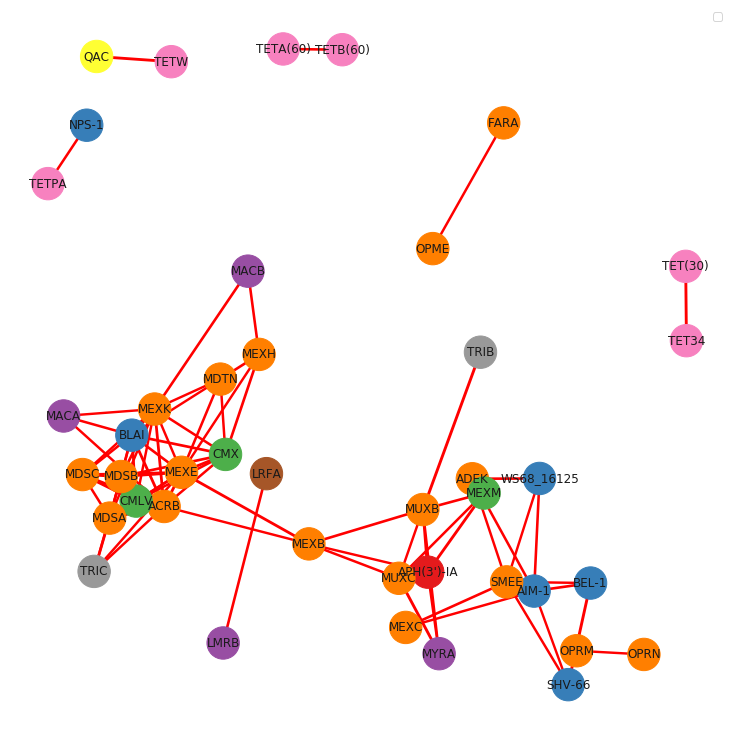

In [177]:
plt.figure(figsize=(10,10)) 


# nc = nx.draw_networkx_nodes(G, pos=pos, nodelist=G.nodes(), node_color=carac['predicted_ARG-class'].cat.codes, 
#                            with_labels=False, node_size=100, cmap=plt.cm.Set1)
# Plot the network:
nx.draw(G,pos=pos, with_labels=True,node_color=carac['predicted_ARG-class'].cat.codes,cmap=plt.cm.Set1,node_size=1050, edge_color=links_filtered['color'], 
        width=links_filtered["value"]*3, edge_cmap=plt.cm.Blues,legend=carac['predicted_ARG-class'])


plt.legend(carac['predicted_ARG-class'],loc="best",scatterpoints=1)


plt.show()

In [80]:
ARGS_CLASS_fornet=class_RPKG[class_RPKG.columns[0:-45]]
corr = ARGS_CLASS_fornet.corr(method='spearman')
corr
 
# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']
links
 
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ ((links['value'] > 0.6 ) | (links['value'] < -0.6 )) & (links['var1'] != links['var2']) ]
links_filtered
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
 
# Plot the network:
#nx.draw_random(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=5, font_size=10)
links_filtered['color'] = np.where(links_filtered['value']>0, 'red', 'blue')

/home/rcuadrat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


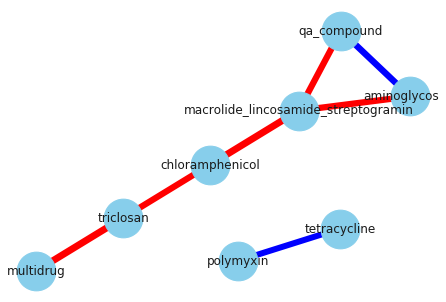

In [81]:
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', create_using=nx.Graph(),edge_attr=True )
 
# Custom the nodes:
nx.draw_kamada_kawai(G, with_labels=True, node_color='skyblue', node_size=1500, edge_color=links_filtered['color'], width=links_filtered["value"]*10, edge_cmap=plt.cm.Blues)


In [ ]:
#################

In [254]:
rna_list=pd.read_csv("RNA/rna_prok.list",sep="\t")

In [255]:
rna_met=pd.read_csv("RNA/rna_seq_tara.tsv",sep="\t",skiprows=2597)

In [256]:
rna=pd.merge(rna_list,rna_met,left_on="sample_accession",right_on="Sample ID (registered at the BioSamples ...)",how="left")

In [257]:
rna.drop(['sample_accession','tax_id','Basis','Device',
 'scientific_name',
 'instrument_model',
 'library_layout',
 'fastq_ftp',
 'fastq_galaxy',
 'submitted_ftp',
 'submitted_galaxy',
 'sra_ftp',
 'sra_galaxy',
 'cram_index_ftp',
 'cram_index_galaxy'],axis=1,inplace=True)

In [258]:
meta_stations=meta[['Station identifier [TARA_station#]', 'Ocean and sea regions (IHO General Sea Areas 1953) [MRGID registered at www.marineregions.com]',
       'Marine provinces  (Longhurst 2007)',
        'Ocean_sea_regions', 'Marine_provinces']].drop_duplicates()

In [259]:
rna=pd.merge(rna,meta_stations,left_on="Station",right_on="Station identifier [TARA_station#]",how="left")